This script use the FR1, catFR and pyFR datasets, looking into memory biomarkers in depression and anxiety 

In [3]:
# from imports import * 
from cmlreaders import CMLReader, get_data_index
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from scipy import stats
pd.set_option('display.max_columns', None)

# Start analysis - choose subject's list and their relevant trials for analysis

Choose subjects that will be used in the analysis.
(currently, 1. use all pyFR+FR subjects, and 2. all catFR1 subjects.)
Replace these subjects with the subjects that has BDI scores:

In [4]:
# 1. If I want all FR1 and pyFR subjects
df = get_data_index("r1")
FR1_subs=df[df['experiment']=='FR1']['subject'].unique() # all FR1 subjects
df = get_data_index("pyfr")
pyfr_subs=df[df['experiment']=='pyFR']['subject'].unique() # all pyFR subjects
exp = 'FR1' 

FR_subs=[]
FR_subs = list(FR1_subs)+list(pyfr_subs)
print('Total number of FR subjects: ',len(FR_subs))

Total number of FR subjects:  445


In [5]:
# 2. OR if I want the catFR dataset:
df = get_data_index("r1")
catFR1_subs=df[df['experiment']=='catFR1']['subject'].unique() # all catFR1 subjects
print('Total number of catFR subjects: ',len(catFR1_subs))
exp = 'catFR1'
FR_subs= catFR1_subs

Total number of catFR subjects:  240


In [6]:
# Load subject df of those with essential values (anxiety, depression, IQ, and age of implant, gender) by session from MH_Master.
# 111 subjects over both experiments with all values that are currently included in MH_Master mixed effects model
%store -r 
Noa_subs
Noa_FR_subs = list(Noa_subs[Noa_subs['experiment']=='FR1']['subject'].unique())
Noa_catFR_subs = list(Noa_subs[Noa_subs['experiment']=='catFR1']['subject'].unique())
Noa_catFR_subs

['R1013E',
 'R1015J',
 'R1024E',
 'R1032D',
 'R1044J',
 'R1065J',
 'R1066P',
 'R1083J',
 'R1092J',
 'R1093J',
 'R1105E',
 'R1107J',
 'R1108J',
 'R1170J',
 'R1207J',
 'R1226D',
 'R1230J',
 'R1236J',
 'R1239E',
 'R1254E',
 'R1273D',
 'R1275D',
 'R1277J',
 'R1313J',
 'R1317D',
 'R1330D',
 'R1343J',
 'R1348J',
 'R1354E',
 'R1376D',
 'R1379E',
 'R1383J',
 'R1384J',
 'R1385E',
 'R1389J',
 'R1394E',
 'R1397D',
 'R1398J',
 'R1404E',
 'R1405E',
 'R1413D',
 'R1414E',
 'R1415T',
 'R1436J',
 'R1443D',
 'R1450D',
 'R1456D',
 'R1457T',
 'R1468J',
 'R1474T',
 'R1482J',
 'R1498D',
 'R1501J',
 'R1505J',
 'R1542J']

Selecting subjects based on inclusion criteria and creating a df that summerizes their data:

In [12]:

subject_info=pd.DataFrame([]) # stores data through the analysis
output_position=pd.DataFrame([]) 
for sub in Noa_FR_subs: # ['TJ019']:
    data=[]
    chosen_trials=[]
    excluded_trials=[] # added

    try:
        df = get_data_index("r1")
        number_of_loc=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique()
       
        if len(number_of_loc)==0 and exp == 'FR1' :
            df = get_data_index("pyfr")
            exp=df[df['subject']==sub]["experiment"].iloc[0] # pyfr 
            number_of_loc=df[(df['subject']==sub) & (df['experiment']==exp)]['localization'].unique() 
        
#         if len(number_of_loc)!=1:  
#             print('subject ', sub,': check number of localization') #Localization: A subject will get a new localization if they were reimplanted after another surgery. Therefore, electrodes may be in different places altogether.
        
        for loc in number_of_loc:
            montages = df[(df['subject']==sub) & (df['experiment']==exp) & (df['localization']==loc)]['montage'].unique()
            assert len(montages)>0
           
            for mont in montages: # iterate over montages            
                data = df[np.logical_and(df["subject"] == sub, df['experiment']==exp)]
                sessions=data[np.logical_and(data['montage']==mont,data['localization']==loc)]['session'].unique()
                assert len(sessions)!=0
                
                for sess in sessions: # iterate over sessions
                    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)   #reader for loading CML data

                    evs = reader.load('task_events')#'events' will also do, but you'll get some extra stuff
                    evs=evs[evs['list']>=0] # delete negative lists
                    #evs=correctEEGoffset(sub,sess,exp,reader,evs) # correcting eeg-behavior misalignment is not needed at this stage
                    
                    if any(evs.columns=='item'): # for pyfr
                        item_column='item'
                    elif any(evs.columns=='item_name'): # for r1
                        item_column='item_name'
                                    
                    # number of lists
                    num_lists=evs.list.unique()
                    num_lists=len(num_lists[num_lists>=0])

                    # define the three classes of retrieval events
                    # choose recall events preceded by 5000 ms of silence:
                    recalled_events = evs[evs['type']=='REC_WORD']
                    assert all(recalled_events['list']>=0),'negative list number' # make sure no negative number of list exist

                    total_rec_events=len(recalled_events[recalled_events[item_column]!='<>']) # added to compute percentage of excluded trials
                    
                    # take events that were preceded by a 5,000ms of 'silence'
                    # I did not add more ms to account for the duration of vocalization ('rectime' signals the beginning of vocalization)
                    
                    silence_period = 3000 # or 5000 (in ms)
                    for list in recalled_events['list'].unique():
                        list_events=recalled_events[recalled_events['list']==list]
                        if len(list_events)>0 and list_events.iloc[0]['rectime']>=silence_period: # handle first response
                            excluded_trials.append([sess,mont,list_events.index[0]]) # I always discard the first recall. In order to include it, replace 'excluded_trials' here with 'chosen_trials'.
                        else:
                            excluded_trials.append([sess,mont,list_events.index[0]])
                        if len(list_events)>1:
                            for i in range(1,len(list_events)):
                                diff=list_events['rectime'].iloc[i]-list_events['rectime'].iloc[i-1] # time diff between recalls
                                if diff>=silence_period:
                                    chosen_trials.append([sess,mont,list_events.index[i]])               
                                else:
                                    excluded_trials.append([sess,mont,list_events.index[0]])
                                    
                    sess_excluded_trials=[trial for session,monti,trial in excluded_trials if (session==sess and monti==mont)]
                    sess_chosen_trials=[trial for session,monti,trial in chosen_trials if (session==sess and monti==mont)]
                    temp_data=recalled_events.loc[sess_chosen_trials]
                    
                    # delete events that were not eeg recorded
                    no_eeg_events=temp_data[temp_data['eegoffset']<0].index
                    temp_data=temp_data.drop(labels=no_eeg_events)
                    if len(no_eeg_events)>0:
                        for no_eeg_row in no_eeg_events:
                            sess_chosen_trials.remove(no_eeg_row)
                    
                    # Delete all word repetitions (Long et al. also rejected all repetitions in correct recall and intrusions)
                    rows_to_delete=[]
                    verbalization_indexes=[]
                    for list in temp_data['list'].unique():
                        list_events=temp_data[temp_data['list']==list]
                        words_in_session = list_events[item_column]
                        for word in words_in_session:
                            count=words_in_session.str.count(word)
                            if sum(count)>1:
                                rows_to_delete.extend(words_in_session.index[count!=0][1:]) # leave only the first index of occurance
                        verbalization_indexes.extend(words_in_session[words_in_session=='<>'].index) # reject non-word verbalization (which are coded as ELI's)


                    # unique row numbers to delete            
                    rows_to_delete_array = np.asarray(rows_to_delete)
                    rows_to_delete_array=np.unique(rows_to_delete_array)

                     # delete repeating words
                    temp_data=temp_data.drop(labels=rows_to_delete_array);
                    for trial in rows_to_delete_array:
                        sess_chosen_trials.remove(trial)
                        if any(verbalization_indexes==trial):
                            verbalization_indexes.remove(trial)
                    
                    # participant had to have a minimum of five items per retrieval class to be
                    # included in the analysis;
                    
                    # count number of intrusions:
                    non_verbalization=temp_data[temp_data[item_column]!='<>'] # exclude verbalization from count of ELI's
                    intrusions_freq=sum(non_verbalization['intrusion']!=0)
                    extra_list_intrusions_freq=sum(non_verbalization['intrusion']==-1) #-1 for extra-list intrusion
                    prior_list_intrusions_freq=sum(non_verbalization['intrusion']>0)
                    assert extra_list_intrusions_freq + prior_list_intrusions_freq == intrusions_freq, f'there''s an error in calculating the number of intrusions'

                    # count number of correct recall:
                    correct_recall_freq=sum(non_verbalization['intrusion']==0)

                    for list in temp_data['list'].unique():
                        recalled_events_within_list=recalled_events[recalled_events['list']==list]
                        for recalled_word in temp_data[temp_data['list']==list][item_column]:
                            for jj in range(0,len(recalled_events_within_list)):
                                if recalled_events_within_list[item_column].iloc[jj]==recalled_word:
                                    output_pos={'subject':sub,'session':sess,'montage':mont,'localization':loc,'word recalled':[recalled_word],'intrusion': recalled_events_within_list['intrusion'].iloc[jj],'recalled': recalled_events_within_list['recalled'].iloc[jj],'list':[list],'output position': [jj+1]}
                                    output_position=output_position.append(pd.DataFrame(data=output_pos))
                                    break # so that the output position will reflect the first recall of the word

                    if len((sess_chosen_trials) and (verbalization_indexes))>0:
                        for elem in (sess_chosen_trials) and (verbalization_indexes):
                            sess_chosen_trials.remove(elem)
                    #print(str(sess)+' completed successfully!')

                    subject_info = subject_info.append({'subject': sub, 'experiment':exp,'localization': loc, 'montage': mont, 'session':sess, 
                                                'number of lists': num_lists,
                                                'number of trials left':len(temp_data),'total number of intrusions':intrusions_freq,
                                                'number of extra-list intrusions': extra_list_intrusions_freq,
                                                'number of prior-list intrusions':prior_list_intrusions_freq,
                                                'number of prior-list intrusions':prior_list_intrusions_freq,'number of correct recalls':correct_recall_freq,
                                                'trials for analysis':sess_chosen_trials,'trials excluded':sess_excluded_trials,'total_rec_events':total_rec_events,'<>verbalization_trials':verbalization_indexes},ignore_index=True )

    except:
        print('error: sub ',sub, 'session ',sess,' experiment is: ',exp)
        pass

In [13]:
# look at part of the output
subject_info[0:1]

,<>verbalization_trials,experiment,localization,montage,number of correct recalls,number of extra-list intrusions,number of lists,number of prior-list intrusions,number of trials left,session,subject,total number of intrusions,total_rec_events,trials excluded,trials for analysis
0,[],catFR1,0.0,0.0,4.0,0.0,13.0,1.0,5.0,0.0,R1032D,1.0,40.0,"[38, 38, 60, 60, 60, 84, 84, 107, 107, 107, 13...","[63, 86, 109, 134, 203]"


In [14]:
# check how many trials were excluded
excluded_data=pd.DataFrame([])
for i in range(0,len(subject_info)):
    trials_excluded_per_session=len(subject_info['trials excluded'].iloc[i])
    excluded_data=excluded_data.append({'subject':subject_info['subject'].iloc[i],'session':subject_info['session'].iloc[i],'number of lists':subject_info['number of lists'].iloc[i],'num_of_excluded_recalls':trials_excluded_per_session,'total_rec_events':subject_info['total_rec_events'].iloc[i]},ignore_index=True)
    
# print(np.mean(excluded_data[excluded_data['number of lists']==25]['num_of_excluded_recalls']))
# print(np.mean(excluded_data[excluded_data['number of lists']==25]['total_rec_events'])    )
percent_excluded=excluded_data['num_of_excluded_recalls']/excluded_data['total_rec_events']*100
print('percent of trials ecxluded:', np.mean(percent_excluded))

percent of trials ecxluded: 73.05759248301047


In [15]:
print('percent of remaining subjects:',len(subject_info['subject'].unique()) / len(FR_subs) *100)

percent of remaining subjects: 15.416666666666668


In [21]:
# remove subjects with <5 intrusions/correct recall (in each montage seperately)
remove_data=[]
remove_subejectsMontage=[]
for sub in subject_info['subject'].unique():
    #print(sub)
    sub_data=subject_info[subject_info['subject']==sub]
    for loc in sub_data['localization'].unique():
        loc_data=sub_data[sub_data['localization']==loc]
        for mont in loc_data['montage'].unique():
            mont_data = sub_data[sub_data['montage']==mont]
            if np.sum(mont_data['total number of intrusions'])<5:
#                 print('sub' ,sub, 'montage: ',mont,' has less than 5 intrusions')
                remove_data.extend(mont_data.index)
                remove_subejectsMontage.append([sub,int(mont),int(loc)]) # used later for output position mat
            elif np.sum(mont_data['number of correct recalls'])<5:
#                 print('sub' ,sub, 'montage: ',mont,' has less than 5 correct recalls')
                remove_data.extend(mont_data.index)
                remove_subejectsMontage.append([sub,int(mont),int(loc)]) # used later for output position mat
subject_info=subject_info.drop(remove_data, axis=0);
print('percent of remaining subjects:',len(subject_info['subject'].unique()) / len(FR_subs) *100)

percent of remaining subjects: 62.916666666666664


In [22]:
remove_subejectsMontage[0]


['R1004D', 0, 0]

In [23]:
# remove data from output position
output_position.reset_index(inplace=True) # create serial indexing of rows
for sub,mont,loc in remove_subejectsMontage:
#     print('sub', sub, 'mont ',mont, 'localization',loc)
    delete_rows=output_position[(output_position['subject']==sub) & (output_position['montage']==mont) & (output_position['localization']==loc)].index
    output_position=output_position.drop(delete_rows,axis='index')
    delete_rows=[]


In [24]:
output_position


,index,subject,session,montage,localization,word recalled,intrusion,recalled,list,output position
27,0,R1016M,0,0,0,CABBAGE,0,1,1,2
28,0,R1016M,0,0,0,WIND,-1,0,1,3
29,0,R1016M,0,0,0,GRATER,0,1,2,3
30,0,R1016M,0,0,0,WATERMELON,-1,0,2,4
31,0,R1016M,0,0,0,HALLWAY,0,1,3,6
...,...,...,...,...,...,...,...,...,...,...
10749,0,R1542J,1,0,0,CRAB,0,1,10,8
10750,0,R1542J,1,0,0,BLUEBERRY,0,1,11,4
10751,0,R1542J,1,0,0,LIME,2,0,11,7
10752,0,R1542J,1,0,0,BOOKSHELF,-1,0,12,8


In [25]:
# compute mean output position by retrieval class
# (right now it's across lists and sessions, within subjects)
mean_output_position = pd.DataFrame([])
for sub in output_position['subject'].unique():
    sub_data=output_position[output_position['subject']==sub]
    for loc in sub_data['localization'].unique():
        loc_data= sub_data[sub_data['localization']==loc]                    
        for mont in loc_data['montage'].unique():
            mont_data=loc_data[loc_data['montage']==mont]
            correct_recall_output_position=mont_data[mont_data['intrusion']==0]['output position']
            avg_correct_recall_output_pos=np.mean(np.array(correct_recall_output_position))

            non_verbalization=mont_data[mont_data['word recalled']!='<>'] # exclude verbalizations that are non-word
            intrusions_output_position=non_verbalization[non_verbalization['intrusion']!=0]['output position']
            avg_intrusions_output_pos=np.mean(np.array(intrusions_output_position))

            deliberation_output_position=mont_data['output position']
            avg_deliberation_output_pos=np.mean(np.array(deliberation_output_position))

            intrusions_list = intrusions_output_position.tolist()
            correct_recall_list=correct_recall_output_position.tolist()
            deliberation_list=avg_deliberation_output_pos.tolist()

            mean_output_position = mean_output_position.append({'subject': sub,'montage':mont,'mean correct recall output position':avg_correct_recall_output_pos,
                                                'mean intrusions output position':avg_intrusions_output_pos,'mean deliberation output position':deliberation_list},ignore_index=True )

In [26]:
mean_output_position


,mean correct recall output position,mean deliberation output position,mean intrusions output position,montage,subject
0,4.102041,4.081395,4.054054,0.0,R1016M
1,4.277778,4.085714,3.882353,0.0,R1021D
2,6.648148,6.857143,8.111111,0.0,R1028M
3,4.250000,4.161290,4.000000,0.0,R1035M
4,4.565217,4.142857,3.631579,0.0,R1036M
...,...,...,...,...,...
150,4.362903,4.911950,6.857143,0.0,R1530J
151,4.875000,5.480000,5.764706,0.0,R1533J
152,4.581395,4.424242,4.130435,0.0,R1536J
153,5.507937,5.339130,5.134615,0.0,R1541T


In [27]:
assert len(subject_info['subject'].unique()) == len(output_position['subject'].unique())
print('number of subjects left: ', len(subject_info['subject'].unique()))
print('correct recall mean output position: ',np.mean(mean_output_position['mean correct recall output position']))
print('intrusions mean output position: ',np.mean(mean_output_position['mean intrusions output position']))
print('deliberation output position: ',np.mean(mean_output_position['mean deliberation output position']))


number of subjects left:  151
correct recall mean output position:  4.28192845103843
intrusions mean output position:  4.719967662197749
deliberation output position:  4.429127197954293


In [28]:
# repeated-measures one-way ANOVA on output position
from statsmodels.stats.anova import AnovaRM

anova_df=pd.DataFrame({})
a=[mean_output_position.iloc[i,[0,1,2]] for i in range(0,len(mean_output_position))]
for ii in range(0,len(a)):
    new_df=pd.DataFrame({'subject':mean_output_position.iloc[ii]['subject'],'output position':[a[ii][0],a[ii][1],a[ii][2]],'condition':[1,2,3]})
    anova_df=pd.concat([anova_df,new_df])
    
Anova=AnovaRM(anova_df,'output position',subject='subject',within=['condition'],aggregate_func='mean')
print(Anova.fit())

#from openpyxl.workbook import Workbook
#anova_df.to_excel('/home1/noaherz/Long2017/results/anova.xlsx')
#mean_output_position.to_excel('/home1/noaherz/Long2017/results/mean_output_position.xlsx')

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition 48.3299 2.0000 300.0000 0.0000



In [29]:
# How many subjects had both >5 prior and >5 extra-list intrusions?
freq_mont_both_extra_prior_intrusions = np.array([0])
subjects_both_extra_prior_intrusions = []
for sub in subject_info['subject'].unique():
    sub_data=subject_info[subject_info['subject']==sub]
    for mont in sub_data['montage'].unique():
        mont_data=sub_data[sub_data['montage']==mont]
        extra_list=mont_data['number of extra-list intrusions']
        sum_extra_list =np.sum(np.array(extra_list))
        prior_list=mont_data['number of prior-list intrusions']
        sum_prior_list =np.sum(np.array(prior_list))
        if sum_prior_list>=5 and sum_extra_list>=5:
            #print('subject ',sub, 'mont ',mont, 'has both types of intrusions')
            freq_mont_both_extra_prior_intrusions = freq_mont_both_extra_prior_intrusions + 1
            subjects_both_extra_prior_intrusions.append([sub,mont])
print('number of montages with both extra and prior-list intrusions: ',freq_mont_both_extra_prior_intrusions)
my_subs=[sub for sub,mont in subjects_both_extra_prior_intrusions] 
unique_subs = set(my_subs)
print('number of subjects with both extra and prior-list intrusions: ',len(unique_subs))

number of montages with both extra and prior-list intrusions:  [82]
number of subjects with both extra and prior-list intrusions:  80


In [181]:
# sanity check
for i in range(0,len(subject_info)):
    assert len(subject_info.iloc[i]['trials for analysis'] +subject_info.iloc[i]['<>verbalization_trials']) == (subject_info.iloc[i]['number of trials left'])


In [42]:
# compute average number of events across participants
correct_recall_number=[]
intrusion_number=[]
deliberation_number=[]
for sub in subject_info['subject'].unique():
    subjects_mean_data=subject_info[subject_info['subject']==sub]
    for mont in subjects_mean_data['montage'].unique():
        subject_mont=subjects_mean_data[subjects_mean_data['montage']==mont]
        correct_recall_number.append(np.sum(subject_mont['number of correct recalls']))
        intrusion_number.append(np.sum(subject_mont['total number of intrusions']))
        deliberation_number.append(np.sum(subject_mont['number of trials left']))
print('average number of correct recalls across participants:',np.mean(correct_recall_number))  
print('average number of intrusions across participants:',np.mean(intrusion_number))
print('average number of deliberations across participants:',np.mean(deliberation_number))

average number of correct recalls across participants: 32.96
average number of intrusions across participants: 23.78
average number of deliberations across participants: 56.74


In [43]:
# save outputs (change accordingly)

# output_position.to_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/output_position_FR')
# subject_info.to_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/subject_info_FR')

output_position.to_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/output_position_FR_3sc')
subject_info.to_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/subject_info_FR_3sc')


# Analyze iEEG data

## Run linear mixed model


In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


from imports import *
Start by loading the df and defining some functions

In [2]:
% cd /home1/noaherz/Long2017/git_repos/False-memory
from imports import *

/home1/noaherz/Long2017/git_repos/False-memory


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:300: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ptsa/data/timeseries.py:487: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):


Load the data (change accordingly)

In [3]:
# ## 1. catfR:
# output_position = pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/output_position_FR_3sc')
# subject_info =  pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/subject_info_FR_3sc')

## 2. FR:
output_position = pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/output_position_FR_3sc')
subject_info =  pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/subject_info_FR_3sc')

In [4]:
print('Number of subjects: ',len(subject_info['subject'].unique()))

Number of subjects:  197


Define your ROIs:

In [5]:
# %cd '/home1/noaherz/Long2017/git_repos/False-memory'
from lrtest import lrtest

In [6]:
%run '/home1/noaherz/Long2017/git_repos/False-memory/brain_labels.py'
# MTL_labels
# DLPFC_labels


In [7]:
HPC_labels,ENT_labels,PHC_labels =getMTLregions(MTL_labels)
PHG_labels=ENT_labels+PHC_labels+['prc', 'ba35', 'ba36','left prc','right prc']
# PHG_labels
# HPC_labels


In [8]:
# choose your ROI for the rest of the analysis:
# region_list =  DLPFC_labels #or: 
region_list = HPC_labels #/PHG_labels 
print('Chosen ROIs for the analysis:',region_list)

Chosen ROIs for the analysis: ['left ca1', 'left ca2', 'left ca3', 'left dg', 'left sub', 'right ca1', 'right ca2', 'right ca3', 'right dg', 'right sub', ' left hippocampus', ' right hippocampus', 'left hippocampus', 'right hippocampus', '"ca1"', '"dg"', '"sub"', 'ca1', 'dg', 'sub']


In [80]:
# OPTIONAL - relevant only for bug fixing...
for row in range(0,len(subject_info)):
    if subject_info['subject'].iloc[row]=='R1346T':
        print('Chosen subject is on row: ',row)

Chosen subject is on row:  362
Chosen subject is on row:  363
Chosen subject is on row:  364


In [69]:
# row=subject_info_re.iloc[8]
row=subject_info1.iloc[1]
row

<>verbalization_trials                                                            []
experiment                                                                       FR1
localization                                                                       0
montage                                                                            0
number of correct recalls                                                          4
number of extra-list intrusions                                                    1
number of lists                                                                   12
number of prior-list intrusions                                                    9
number of trials left                                                             14
session                                                                            0
subject                                                                       R1386T
total number of intrusions                                       

In [70]:
# change:
save_path='/scratch/noaherz/False-Memory/hippo_pre_recall'

import pandas as pd
removed_subject=pd.DataFrame(columns=['subject', 'sessions','montage','reason for exclusion'])

if row['experiment']!='catFR1':
    subject_info =  pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/subject_info_FR_3sc')
elif row['experiment']=='catFR1':
    subject_info =  pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/subject_info_FR')

import os
#%cd '/home1/noaherz/Long2017/git_repos/False-memory'
os.chdir('/home1/noaherz/Long2017/git_repos/False-memory')

import numpy as np
import pandas as pd
from cmlreaders import CMLReader, get_data_index
import pickle


#     import scipy.signal
#     from scipy.stats import zscore
#     from correctEEGsubjects import correctEEGsubjects
#     from correctEEGoffset import correctEEGoffset
#     from getElecCats import getElecCats
#     from missing_channels import missing_channels
#     from getMTLregions import getMTLregions
#     from getBadChannels import getBadChannels
#     from event_type_index import event_type_index
#     from add_semantic_similarity import add_semantic_similarity
#     from add_semantic_similarity import case_insensitive_similarity
#     from add_semantic_similarity import categorized_words
#     from add_output_position import add_output_position
#     from brain_label import brain_label

#     from add_semantic_relatedness import add_semantic_relatedness,categorized_words
#     import gensim.models as models
#     import os, csv, numpy, pandas

#     from ptsa.data.filters import ButterworthFilter
#     from ptsa.data.filters import MorletWaveletFilter
#     from add_mirror_buffer_adjusted import add_mirror_buffer_adjusted #
#     from regionalizationModule import get_elec_regions,Loc2PairsTranslation
#     import xarray as xr
#     from irasa.IRASA import IRASA

sub = row['subject']
exp = row['experiment']
sess= int(row['session'])
mont= int(row['montage'])
loc=  int(row['localization']) # mostly 0  
assert len(set(row['trials for analysis']) & set(row['<>verbalization_trials'] ))==0 # make sure there's no overlapping trials
trials= row['trials for analysis'] +row['<>verbalization_trials']  

if sub=='R1223E' and exp=='catFR1': #problematic eeg loading..
    pass
reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)
evs = reader.load('task_events')
evs=add_output_position(evs)

#     Semantic_similarity measures: run only on catFR
if exp=='catFR1':
    evs=add_semantic_similarity(evs)
    evs=add_semantic_relatedness(evs)

if len(trials)>=0:
    chosen_data = evs.loc[trials]
    in_list=correctEEGsubjects(sub)
    if in_list==True:
        chosen_data=correctEEGoffset(sub,sess,exp,reader,chosen_data) # correcting eeg-behavior misalignment

    # load bad electrodes information  
    remove_soz_ictal=False #True # decide if True (remove seizure onset zone and interictal) or False (exclude only bad channels)
    elec_cats,bad_elec_status=getElecCats(reader)
    try:
        try:
            if exp=='pyFR':
                tal_path='/data/eeg/'+sub+'/tal/'+sub+'_talLocs_database_bipol.mat'
                df = pd.DataFrame(loadmat(tal_path)['bpTalStruct'][0])
                channel_info=[[df['channel'][i][0][0],df['channel'][i][0][1],df['tagName'][i][0],df['Loc5'][i][0]] for i in range(0,len(df))]
                pairs=pd.DataFrame(channel_info, columns=['contact_1','contact_2','label','stein.region'])

            elif exp=='FR1' or exp=='catFR1' :   
                pairs = reader.load('pairs')
        except:
            from ptsa.data.readers import TalReader
            tal_path='/data/eeg/'+sub+'/tal/'+sub+'_talLocs_database_bipol.mat'
            tr=TalReader(tal_path)
            bp=tr.get_bipolar_pairs().astype([('ch0','U8'),('ch1','U8')]) #list of bipolar pairs
            pd.set_option('max_columns',None)
            loc1=tr.read()
            df=pd.DataFrame.from_records(loc1.tolist(),columns=np.array(loc1.dtype.names))
            #loc_df.head()
            channel_info=[[df['channel'][i][0],df['channel'][i][1],df['tagName'][i],df['Loc5'][i]] for i in range(0,len(df))]
            pairs=pd.DataFrame(channel_info, columns=['contact_1','contact_2','label','stein.region'])

        pairs,rows=missing_channels(pairs,exp,sub) # handles missing channels in the data

        #Grab some EEG 
        buf = 1500  #to remove edge effects during wavelet convolution
#             eeg = reader.load_eeg(events=chosen_data, rel_start=-2500, rel_stop=2500, scheme=pairs)
        eeg = reader.load_eeg(events=chosen_data, rel_start=-2500, rel_stop=-100, scheme=pairs)

    except:
        print('***sub:',sub,'exp:',exp,' eeg data is not loading')
        removed_subject=removed_subject.append({'subject':sub, 'sessions':sess,'montage':mont,'reason for exclusion':'eeg loading problem'},ignore_index=True)
#         continue

#         eeg = add_mirror_buffer_adjusted(eeg,buf/1000)
    try:
        localizations=reader.load('localizations')
    except:
        localizations=[]
    elect_regions=get_elec_regions(localizations,pairs) # John's script        

    # ROI
    HPC_labels,PHG_labels=brain_label()
#         # choose ROI:
    region_list = HPC_labels

    mat=np.zeros(len(elect_regions[0]))
    for word in region_list:
        mat=mat+((elect_regions[0]==word)*1)
    hipp_index=np.array(mat)>0 # bool mask

    # find bad electrodes
    bad_bp_mask = getBadChannels(pairs,elec_cats,remove_soz_ictal)
    #concat hippocampus electrodes with good electrodes:
    good_bp_mask_bool=bad_bp_mask==0 # good electrodes boolean
    good_bp_hipp_mask = good_bp_mask_bool & hipp_index
    assert sum(good_bp_hipp_mask) <= sum(hipp_index)

    if sum(good_bp_hipp_mask)>0 and ('eeg' in locals()):  # if at least one electrode exists and eeg was loaded 

        # sample rate should be at least 250Hz
        sr = round(eeg.samplerate)
        if sr <250:
            print('***sub:',sub,'exp:',exp,' sample rate is lower than 250 Hz: sr is: ',sr)
            np.save(f"{save_path}/{sub}_*sr*",sr)
        elif sr >=250:
            if sr %100 !=0:
                sr=sr-sr%100
                eeg=eeg.resample(sr)
            eeg_ptsa = eeg.to_ptsa()
            del eeg

            # Add mirrored buffer
            eeg_ptsa = add_mirror_buffer_adjusted(eeg_ptsa,buf/1000)

            if sub.startswith('FR'): # Freiburg subjects' line noise is 50Hz
                freq_range = [48., 52.]
            else:
                freq_range = [58., 62.]

            b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
            eeg_filtered = b_filter.filter()
            del eeg_ptsa

             # Zero values in the eeg data will become -inf under log transform. 
            bad_channels=[]
            good_channels=[]
            for channel in range(0,eeg_filtered.shape[1]):
                if (np.array(eeg_filtered[:,channel,:])==0).all(): # bad electrodes with zeros
                    bad_channels.append(channel)
            for chan in range(0,eeg_filtered.shape[1]):
                if chan not in bad_channels:
                    good_channels.append(chan)
            eeg_filtered=eeg_filtered.isel(channel=good_channels)

            if len(bad_channels)>0:
                hipp_index=numpy.delete(hipp_index, bad_channels)
                good_bp_hipp_mask=numpy.delete(good_bp_hipp_mask, bad_channels)

            if not os.path.exists(save_path):
                os.mkdir(save_path)
            np.save(f"{save_path}/{sub}_{exp}_hipp_electrodes_{loc}_{mont}_{sess}",good_bp_hipp_mask)
            np.save(f"{save_path}/{sub}_{exp}_sr",sr)

            #Get spectral power
            myfreqs = np.logspace(np.log10(4), np.log10(100), 40)  #4-100 Hz, 40 frequencies
#                 widths = np.round(np.logspace(np.log10(2), np.log10(6), 46)) # cycle numbers
            wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=4, output='power') 
            pow_wavelet = wf.filter()   #output is freqs, events, elecs, and time
            buff_in_samples=int((buf/1000.)*sr) # convert buffer time to samples
            pows = pow_wavelet.isel(time=np.arange(buff_in_samples,len(pow_wavelet.time)-buff_in_samples))  #remove buffer period    
            pows = np.log10(pows) # get log of powers. # powes time is 2750 samples, corresponding to 2750/500=5,500ms. # in some versions use:np.log10(pows.data) instead.
            del eeg_filtered

             # index of event type:
            events_index=event_type_index(chosen_data)  
#                 np.save(f"/scratch/noaherz/False-Memory/{sub}_events_index_{loc}_{mont}_{sess}",events_index)
            events_index.to_pickle(f"{save_path}/{sub}_{exp}_events_index_{loc}_{mont}_{sess}.pkl")

            #Reshape array to average into 100 ms bins with a 50ms sliding window
            time_window=int(100/1000*sr) # convert 100ms to samples
            sliding_time=int(50/1000*sr) # convert 50ms to samples
            time_windows=[(k,k+time_window) for k in range(0,pows.time.shape[0]+1-time_window,sliding_time)] # 50ms sliding window is 25 samples
            if len(time_windows)==97: # i=49 terminated before 4455 ms
                time_windows.append((time_windows[-1][0]+sliding_time,pows.time.shape[0]))
            avg_pows=np.zeros([pows.shape[0],pows.shape[1],pows.shape[2],len(time_windows)])*np.nan # initialize to nans
            index=0
            for start,end in time_windows:
                avg_pows[:,:,:,index]=pows.isel(time=np.arange(start,end)).mean(dim='time')
                index=index+1        

            avg_pows=xr.DataArray(avg_pows,dims=[pows.dims[0],pows.dims[1],pows.dims[2],pows.dims[3]])
            del pows

            average_events_time=avg_pows.mean(dim=['event','time'])
            standard_deviation_event_time=avg_pows.std(dim=['event','time']) # here I compute std across events and time
            z_pows=np.zeros([avg_pows.shape[0],avg_pows.shape[1],avg_pows.shape[2],avg_pows.shape[3]])*np.nan
            for freq in range(0,average_events_time.frequency.shape[0]):
                for electrode in range(0,average_events_time.channel.shape[0]):
                    z_pows[freq,:,electrode,:]=(avg_pows[freq,:,electrode,:]-average_events_time[freq][electrode])/standard_deviation_event_time[freq][electrode]

            z_pows=xr.DataArray(z_pows,dims=[avg_pows.dims[0],avg_pows.dims[1],avg_pows.dims[2],avg_pows.dims[3]])
            del avg_pows

            #SPLIT THE DATA TO EVENTS and average them
            pows_correct_recall=z_pows.isel(event=events_index['correct_recall_serial_index'][0])                
            pows_PLI=z_pows.isel(event=events_index['PLI_serial_index'][0])
            pows_ELI=z_pows.isel(event=events_index['ELI_serial_index'][0])
            pows_all_intrusions= z_pows.isel(event=events_index['all_intrusions_serial_index'][0])
            pows_deliberation = z_pows.isel(event=events_index['deliberation_serial_index'][0])
            pows_related_intrusions = z_pows.isel(event=events_index['related_intrusions_serial_index'][0])
            pows_nonrelated_intrusions = z_pows.isel(event=events_index['nonrelated_intrusions_serial_index'][0])
            del z_pows

            # record output position of chosen events AND semantic similarity / relatedness
            # Initialize variables:
            output_position_df=pd.DataFrame([])
            correct_recall_output_position=[] ; all_intrusions_output_position=[]
            deliberation_output_position=[] ; related_intrusions_position=[] ; nonrelated_intrusions_position=[]
            correct_recall_semantic_similarity = [] ; all_intrusions_semantic_similarity =[] ; deliberation_semantic_similarity=[]
            related_intrusions_semantic_similarity=[] ; nonrelated_intrusions_semantic_similarity=[]
            correct_recall_semantic_relatedness=[] ; all_intrusions_semantic_relatedness =[] ; deliberation_semantic_relatedness =[]
            related_intrusions_semantic_relatedness=[] ; nonrelated_intrusions_semantic_relatedness=[]

            #                 # ADD SIMILAR CRITERIA TO RELATED-NON-RELATED
            PLI_num=sum(subject_info[subject_info['subject']==sub]['number of prior-list intrusions'])
            ELI_num=sum(subject_info[subject_info['subject']==sub]['number of extra-list intrusions'])

#                 evs_counter=evs_counter+1
            output_position=pd.DataFrame([])
            for event_type in events_index.columns:
                output_position=output_position.append({f"{event_type[0:-13]}_output_position": chosen_data.iloc[events_index[event_type][0]]['output position']},ignore_index=True )
            if PLI_num<5 or ELI_num<5:
                output_position = output_position.drop(["PLI_output_position", "ELI_output_position"], axis=1)                    
#                     intusion_counter=intusion_counter+1

            semantic_similarity=pd.DataFrame([])
            if exp == 'catFR1':
                for event_type in events_index.columns:
                    semantic_similarity=semantic_similarity.append({f"{event_type[0:-13]}_semantic_similarity": chosen_data.iloc[events_index[event_type][0]]['semantic_similarity']},ignore_index=True )
                    semantic_similarity=semantic_similarity.append({f"{event_type[0:-13]}_semantic_relatedness": chosen_data.iloc[events_index[event_type][0]]['semantic_relatedness']},ignore_index=True )
                if PLI_num<5 or ELI_num<5:
                    semantic_similarity = semantic_similarity.drop(["PLI_semantic_similarity", "ELI_semantic_similarity","PLI_semantic_relatedness","ELI_semantic_relatedness"], axis=1)                    


            # make sure trials' number align between power values and output position
            if PLI_num>=5 and ELI_num>=5:
                assert pows_ELI.event.shape[0]==len(output_position['ELI_output_position'].iloc[0])
                assert pows_PLI.event.shape[0]==len(output_position['PLI_output_position'].iloc[1])
            assert pows_all_intrusions.event.shape[0]==len(output_position['all_intrusions_output_position'].iloc[2])
            assert pows_correct_recall.event.shape[0]==len(output_position['correct_recall_output_position'].iloc[3])
            assert pows_deliberation.event.shape[0]==len(output_position['deliberation_output_position'].iloc[4])
            assert pows_nonrelated_intrusions.event.shape[0] == len(output_position['nonrelated_intrusions_output_position'].iloc[5])
            assert pows_related_intrusions.event.shape[0] == len(output_position['related_intrusions_output_position'].iloc[6])

            # save power values and dfs
            pows_correct_recall.to_netcdf(f"{save_path}/{sub}_{exp}_correct_recall_pows_{loc}_{mont}_{sess}.nc")
            pows_PLI.to_netcdf(f"{save_path}/{sub}_{exp}_PLI_pows_{loc}_{mont}_{sess}.nc")
            pows_ELI.to_netcdf(f"{save_path}/{sub}_{exp}_ELI_pows_{loc}_{mont}_{sess}.nc")
            pows_all_intrusions.to_netcdf(f"{save_path}/{sub}_{exp}_all_intrusions_pows_{loc}_{mont}_{sess}.nc")
            pows_deliberation.to_netcdf(f"{save_path}/{sub}_{exp}_deliberation_pows_{loc}_{mont}_{sess}.nc")
            pows_related_intrusions.to_netcdf(f"{save_path}/{sub}_{exp}_related_intrusions_pows_{loc}_{mont}_{sess}.nc")
            pows_nonrelated_intrusions.to_netcdf(f"{save_path}/{sub}_{exp}_nonrelated_intrusions_pows_{loc}_{mont}_{sess}.nc")

            # save ouput position and semantic similarity
            output_position.to_pickle(f"{save_path}/{sub}_{exp}_output_position_{loc}_{mont}_{sess}.pkl")
            semantic_similarity.to_pickle(f"{save_path}/{sub}_{exp}_semantic_similarity_{loc}_{mont}_{sess}.pkl")

            # irasa
#                 irasa = IRASA(eeg_ptsa, freqs=myfreqs, samplerate=sr)
#                 irasa1 = IRASA(z_pows, freqs=myfreqs, samplerate=sr)

#                 file_to_store = open(f"{sub}_irasa_{loc}_{mont}_{sess}.pickle", "wb")
#                 pickle.dump(irasa, file_to_store)
#                 file_to_store.close()




This is the main analysis. I use 'subject_info' that I have built above and iterate over subjects to compute,
per trial: power, output position, semantic similarity (if it's a catFR subject)

In [58]:
def ieeg_analysis(row):
    # change:
    save_path='/scratch/noaherz/False-Memory/hippo_pre_recall'
    
    import pandas as pd
    removed_subject=pd.DataFrame(columns=['subject', 'sessions','montage','reason for exclusion'])

    if row['experiment']!='catFR1':
        subject_info =  pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/subject_info_FR_3sc')
    elif row['experiment']=='catFR1':
        subject_info =  pd.read_pickle('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/subject_info_FR')
  
    import os
    #%cd '/home1/noaherz/Long2017/git_repos/False-memory'
    os.chdir('/home1/noaherz/Long2017/git_repos/False-memory')
    
    import numpy as np
    import pandas as pd
    from cmlreaders import CMLReader, get_data_index
    import pickle
    

#     import scipy.signal
#     from scipy.stats import zscore
#     from correctEEGsubjects import correctEEGsubjects
#     from correctEEGoffset import correctEEGoffset
#     from getElecCats import getElecCats
#     from missing_channels import missing_channels
#     from getMTLregions import getMTLregions
#     from getBadChannels import getBadChannels
#     from event_type_index import event_type_index
#     from add_semantic_similarity import add_semantic_similarity
#     from add_semantic_similarity import case_insensitive_similarity
#     from add_semantic_similarity import categorized_words
#     from add_output_position import add_output_position
#     from brain_label import brain_label
    
#     from add_semantic_relatedness import add_semantic_relatedness,categorized_words
#     import gensim.models as models
#     import os, csv, numpy, pandas

#     from ptsa.data.filters import ButterworthFilter
#     from ptsa.data.filters import MorletWaveletFilter
#     from add_mirror_buffer_adjusted import add_mirror_buffer_adjusted #
#     from regionalizationModule import get_elec_regions,Loc2PairsTranslation
#     import xarray as xr
#     from irasa.IRASA import IRASA

    sub = row['subject']
    exp = row['experiment']
    sess= int(row['session'])
    mont= int(row['montage'])
    loc=  int(row['localization']) # mostly 0  
    assert len(set(row['trials for analysis']) & set(row['<>verbalization_trials'] ))==0 # make sure there's no overlapping trials
    trials= row['trials for analysis'] +row['<>verbalization_trials']  
    
    if sub=='R1223E' and exp=='catFR1': #problematic eeg loading..
        pass
    reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)
    evs = reader.load('task_events')
    evs=add_output_position(evs)

#     Semantic_similarity measures: run only on catFR
    if exp=='catFR1':
        evs=add_semantic_similarity(evs)
        evs=add_semantic_relatedness(evs)

    if len(trials)>=0:
        chosen_data = evs.loc[trials]
        in_list=correctEEGsubjects(sub)
        if in_list==True:
            chosen_data=correctEEGoffset(sub,sess,exp,reader,chosen_data) # correcting eeg-behavior misalignment
    
        # load bad electrodes information  
        remove_soz_ictal=False #True # decide if True (remove seizure onset zone and interictal) or False (exclude only bad channels)
        elec_cats,bad_elec_status=getElecCats(reader)
        try:
            try:
                if exp=='pyFR':
                    tal_path='/data/eeg/'+sub+'/tal/'+sub+'_talLocs_database_bipol.mat'
                    df = pd.DataFrame(loadmat(tal_path)['bpTalStruct'][0])
                    channel_info=[[df['channel'][i][0][0],df['channel'][i][0][1],df['tagName'][i][0],df['Loc5'][i][0]] for i in range(0,len(df))]
                    pairs=pd.DataFrame(channel_info, columns=['contact_1','contact_2','label','stein.region'])

                elif exp=='FR1' or exp=='catFR1' :   
                    pairs = reader.load('pairs')
            except:
                from ptsa.data.readers import TalReader
                tal_path='/data/eeg/'+sub+'/tal/'+sub+'_talLocs_database_bipol.mat'
                tr=TalReader(tal_path)
                bp=tr.get_bipolar_pairs().astype([('ch0','U8'),('ch1','U8')]) #list of bipolar pairs
                pd.set_option('max_columns',None)
                loc1=tr.read()
                df=pd.DataFrame.from_records(loc1.tolist(),columns=np.array(loc1.dtype.names))
                #loc_df.head()
                channel_info=[[df['channel'][i][0],df['channel'][i][1],df['tagName'][i],df['Loc5'][i]] for i in range(0,len(df))]
                pairs=pd.DataFrame(channel_info, columns=['contact_1','contact_2','label','stein.region'])

            pairs,rows=missing_channels(pairs,exp,sub) # handles missing channels in the data

            #Grab some EEG 
            buf = 1500  #to remove edge effects during wavelet convolution
#             eeg = reader.load_eeg(events=chosen_data, rel_start=-2500, rel_stop=2500, scheme=pairs)
            eeg = reader.load_eeg(events=chosen_data, rel_start=-2500, rel_stop=-100, scheme=pairs)

        except:
            print('***sub:',sub,'exp:',exp,' eeg data is not loading')
            removed_subject=removed_subject.append({'subject':sub, 'sessions':sess,'montage':mont,'reason for exclusion':'eeg loading problem'},ignore_index=True)
    #         continue
        
#         eeg = add_mirror_buffer_adjusted(eeg,buf/1000)
        try:
            localizations=reader.load('localizations')
        except:
            localizations=[]
        elect_regions=get_elec_regions(localizations,pairs) # John's script        

        # ROI
        HPC_labels,PHG_labels=brain_label()
#         # choose ROI:
        region_list = HPC_labels
 
        mat=np.zeros(len(elect_regions[0]))
        for word in region_list:
            mat=mat+((elect_regions[0]==word)*1)
        hipp_index=np.array(mat)>0 # bool mask

        # find bad electrodes
        bad_bp_mask = getBadChannels(pairs,elec_cats,remove_soz_ictal)
        #concat hippocampus electrodes with good electrodes:
        good_bp_mask_bool=bad_bp_mask==0 # good electrodes boolean
        good_bp_hipp_mask = good_bp_mask_bool & hipp_index
        assert sum(good_bp_hipp_mask) <= sum(hipp_index)
        
        if sum(good_bp_hipp_mask)>0 and ('eeg' in locals()):  # if at least one electrode exists and eeg was loaded 

            # sample rate should be at least 250Hz
            sr = round(eeg.samplerate)
            if sr <250:
                print('***sub:',sub,'exp:',exp,' sample rate is lower than 250 Hz: sr is: ',sr)
                np.save(f"{save_path}/{sub}_*sr*",sr)
            elif sr >=250:
                if sr %100 !=0:
                    sr=sr-sr%100
                    eeg=eeg.resample(sr)
                eeg_ptsa = eeg.to_ptsa()
                del eeg
                
                # Add mirrored buffer
                eeg_ptsa = add_mirror_buffer_adjusted(eeg_ptsa,buf/1000)

                if sub.startswith('FR'): # Freiburg subjects' line noise is 50Hz
                    freq_range = [48., 52.]
                else:
                    freq_range = [58., 62.]

                b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
                eeg_filtered = b_filter.filter()
                del eeg_ptsa
                
                 # Zero values in the eeg data will become -inf under log transform. 
                bad_channels=[]
                good_channels=[]
                for channel in range(0,eeg_filtered.shape[1]):
                    if (np.array(eeg_filtered[:,channel,:])==0).all(): # bad electrodes with zeros
                        bad_channels.append(channel)
                for chan in range(0,eeg_filtered.shape[1]):
                    if chan not in bad_channels:
                        good_channels.append(chan)
                eeg_filtered=eeg_filtered.isel(channel=good_channels)
                
                if len(bad_channels)>0:
                    hipp_index=numpy.delete(hipp_index, bad_channels)
                    good_bp_hipp_mask=numpy.delete(good_bp_hipp_mask, bad_channels)
 
                if not os.path.exists(save_path):
                    os.mkdir(save_path)
                np.save(f"{save_path}/{sub}_{exp}_hipp_electrodes_{loc}_{mont}_{sess}",good_bp_hipp_mask)
                np.save(f"{save_path}/{sub}_{exp}_sr",sr)
                
                #Get spectral power
                myfreqs = np.logspace(np.log10(4), np.log10(100), 40)  #4-100 Hz, 40 frequencies
#                 widths = np.round(np.logspace(np.log10(2), np.log10(6), 46)) # cycle numbers
                wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=4, output='power') 
                pow_wavelet = wf.filter()   #output is freqs, events, elecs, and time
                buff_in_samples=int((buf/1000.)*sr) # convert buffer time to samples
                pows = pow_wavelet.isel(time=np.arange(buff_in_samples,len(pow_wavelet.time)-buff_in_samples))  #remove buffer period    
                pows = np.log10(pows) # get log of powers. # powes time is 2750 samples, corresponding to 2750/500=5,500ms. # in some versions use:np.log10(pows.data) instead.
                del eeg_filtered
                
                 # index of event type:
                events_index=event_type_index(chosen_data)  
#                 np.save(f"/scratch/noaherz/False-Memory/{sub}_events_index_{loc}_{mont}_{sess}",events_index)
                events_index.to_pickle(f"{save_path}/{sub}_{exp}_events_index_{loc}_{mont}_{sess}.pkl")
                
                #Reshape array to average into 100 ms bins with a 50ms sliding window
                time_window=int(100/1000*sr) # convert 100ms to samples
                sliding_time=int(50/1000*sr) # convert 50ms to samples
                time_windows=[(k,k+time_window) for k in range(0,pows.time.shape[0]+1-time_window,sliding_time)] # 50ms sliding window is 25 samples
                if len(time_windows)==97: # i=49 terminated before 4455 ms
                    time_windows.append((time_windows[-1][0]+sliding_time,pows.time.shape[0]))
                avg_pows=np.zeros([pows.shape[0],pows.shape[1],pows.shape[2],len(time_windows)])*np.nan # initialize to nans
                index=0
                for start,end in time_windows:
                    avg_pows[:,:,:,index]=pows.isel(time=np.arange(start,end)).mean(dim='time')
                    index=index+1        
                
                avg_pows=xr.DataArray(avg_pows,dims=[pows.dims[0],pows.dims[1],pows.dims[2],pows.dims[3]])
                del pows
                
                average_events_time=avg_pows.mean(dim=['event','time'])
                standard_deviation_event_time=avg_pows.std(dim=['event','time']) # here I compute std across events and time
                z_pows=np.zeros([avg_pows.shape[0],avg_pows.shape[1],avg_pows.shape[2],avg_pows.shape[3]])*np.nan
                for freq in range(0,average_events_time.frequency.shape[0]):
                    for electrode in range(0,average_events_time.channel.shape[0]):
                        z_pows[freq,:,electrode,:]=(avg_pows[freq,:,electrode,:]-average_events_time[freq][electrode])/standard_deviation_event_time[freq][electrode]

                z_pows=xr.DataArray(z_pows,dims=[avg_pows.dims[0],avg_pows.dims[1],avg_pows.dims[2],avg_pows.dims[3]])
                del avg_pows
                
                #SPLIT THE DATA TO EVENTS and average them
                pows_correct_recall=z_pows.isel(event=events_index['correct_recall_serial_index'][0])                
                pows_PLI=z_pows.isel(event=events_index['PLI_serial_index'][0])
                pows_ELI=z_pows.isel(event=events_index['ELI_serial_index'][0])
                pows_all_intrusions= z_pows.isel(event=events_index['all_intrusions_serial_index'][0])
                pows_deliberation = z_pows.isel(event=events_index['deliberation_serial_index'][0])
                pows_related_intrusions = z_pows.isel(event=events_index['related_intrusions_serial_index'][0])
                pows_nonrelated_intrusions = z_pows.isel(event=events_index['nonrelated_intrusions_serial_index'][0])
                del z_pows
                
                # record output position of chosen events AND semantic similarity / relatedness
                # Initialize variables:
                output_position_df=pd.DataFrame([])
                correct_recall_output_position=[] ; all_intrusions_output_position=[]
                deliberation_output_position=[] ; related_intrusions_position=[] ; nonrelated_intrusions_position=[]
                correct_recall_semantic_similarity = [] ; all_intrusions_semantic_similarity =[] ; deliberation_semantic_similarity=[]
                related_intrusions_semantic_similarity=[] ; nonrelated_intrusions_semantic_similarity=[]
                correct_recall_semantic_relatedness=[] ; all_intrusions_semantic_relatedness =[] ; deliberation_semantic_relatedness =[]
                related_intrusions_semantic_relatedness=[] ; nonrelated_intrusions_semantic_relatedness=[]
                
                #                 # ADD SIMILAR CRITERIA TO RELATED-NON-RELATED
                PLI_num=sum(subject_info[subject_info['subject']==sub]['number of prior-list intrusions'])
                ELI_num=sum(subject_info[subject_info['subject']==sub]['number of extra-list intrusions'])

#                 evs_counter=evs_counter+1
                output_position=pd.DataFrame([])
                for event_type in events_index.columns:
                    output_position=output_position.append({f"{event_type[0:-13]}_output_position": chosen_data.iloc[events_index[event_type][0]]['output position']},ignore_index=True )
                if PLI_num<5 or ELI_num<5:
                    output_position = output_position.drop(["PLI_output_position", "ELI_output_position"], axis=1)                    
#                     intusion_counter=intusion_counter+1
                
                semantic_similarity=pd.DataFrame([])
                if exp == 'catFR1':
                    for event_type in events_index.columns:
                        semantic_similarity=semantic_similarity.append({f"{event_type[0:-13]}_semantic_similarity": chosen_data.iloc[events_index[event_type][0]]['semantic_similarity']},ignore_index=True )
                        semantic_similarity=semantic_similarity.append({f"{event_type[0:-13]}_semantic_relatedness": chosen_data.iloc[events_index[event_type][0]]['semantic_relatedness']},ignore_index=True )
                    if PLI_num<5 or ELI_num<5:
                        semantic_similarity = semantic_similarity.drop(["PLI_semantic_similarity", "ELI_semantic_similarity","PLI_semantic_relatedness","ELI_semantic_relatedness"], axis=1)                    

                        
                # make sure trials' number align between power values and output position
                if PLI_num>=5 and ELI_num>=5:
                    assert pows_ELI.event.shape[0]==len(output_position['ELI_output_position'].iloc[0])
                    assert pows_PLI.event.shape[0]==len(output_position['PLI_output_position'].iloc[1])
                assert pows_all_intrusions.event.shape[0]==len(output_position['all_intrusions_output_position'].iloc[2])
                assert pows_correct_recall.event.shape[0]==len(output_position['correct_recall_output_position'].iloc[3])
                assert pows_deliberation.event.shape[0]==len(output_position['deliberation_output_position'].iloc[4])
                assert pows_nonrelated_intrusions.event.shape[0] == len(output_position['nonrelated_intrusions_output_position'].iloc[5])
                assert pows_related_intrusions.event.shape[0] == len(output_position['related_intrusions_output_position'].iloc[6])

                # save power values and dfs
                pows_correct_recall.to_netcdf(f"{save_path}/{sub}_{exp}_correct_recall_pows_{loc}_{mont}_{sess}.nc")
                pows_PLI.to_netcdf(f"{save_path}/{sub}_{exp}_PLI_pows_{loc}_{mont}_{sess}.nc")
                pows_ELI.to_netcdf(f"{save_path}/{sub}_{exp}_ELI_pows_{loc}_{mont}_{sess}.nc")
                pows_all_intrusions.to_netcdf(f"{save_path}/{sub}_{exp}_all_intrusions_pows_{loc}_{mont}_{sess}.nc")
                pows_deliberation.to_netcdf(f"{save_path}/{sub}_{exp}_deliberation_pows_{loc}_{mont}_{sess}.nc")
                pows_related_intrusions.to_netcdf(f"{save_path}/{sub}_{exp}_related_intrusions_pows_{loc}_{mont}_{sess}.nc")
                pows_nonrelated_intrusions.to_netcdf(f"{save_path}/{sub}_{exp}_nonrelated_intrusions_pows_{loc}_{mont}_{sess}.nc")
                    
                # save ouput position and semantic similarity
                output_position.to_pickle(f"{save_path}/{sub}_{exp}_output_position_{loc}_{mont}_{sess}.pkl")
                semantic_similarity.to_pickle(f"{save_path}/{sub}_{exp}_semantic_similarity_{loc}_{mont}_{sess}.pkl")

                # irasa
#                 irasa = IRASA(eeg_ptsa, freqs=myfreqs, samplerate=sr)
#                 irasa1 = IRASA(z_pows, freqs=myfreqs, samplerate=sr)

#                 file_to_store = open(f"{sub}_irasa_{loc}_{mont}_{sess}.pickle", "wb")
#                 pickle.dump(irasa, file_to_store)
#                 file_to_store.close()
                

    return removed_subject


In [59]:
import CMLDask
from dask.distributed import wait, as_completed, progress

import dask
import distributed
dask.config.set({"distributed.comm.timeouts.tcp": "50s"})


In [60]:
client = CMLDask.new_dask_client("test_dask", "20GB") # you can make this higher (memory limit per worker)

Unique port for noaherz is 51409
{'dashboard_address': ':51409'}
To view the dashboard, run: 
`ssh -fN noaherz@rhino2.psych.upenn.edu -L 8000:192.168.86.145:42126` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 51409 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42126 instead
  f"Port {expected} is already in use.\n"


To see the job's progress, open a new terminal window and type the ssh command appearing above.
If not using the universoty's VPN, change 8000 to 8001.
Then, in a new tab on your browser type: localhost:8001

In [43]:
# client.submit(mod_ieeg_analysis, row)

In [61]:
subject_info1=subject_info[400:]

In [66]:
subject_info1

,<>verbalization_trials,experiment,localization,montage,number of correct recalls,number of extra-list intrusions,number of lists,number of prior-list intrusions,number of trials left,session,subject,total number of intrusions,total_rec_events,trials excluded,trials for analysis
493,[],FR1,0.0,0.0,3.0,0.0,12.0,3.0,6.0,2.0,R1384J,3.0,22.0,"[71, 71, 106, 106, 140, 174, 208, 208, 312, 31...","[73, 314, 315, 384, 419, 453]"
497,[],FR1,0.0,0.0,4.0,1.0,12.0,9.0,14.0,0.0,R1386T,10.0,51.0,"[74, 74, 74, 74, 74, 111, 111, 111, 111, 149, ...","[115, 151, 152, 186, 222, 259, 331, 332, 368, ..."
498,[],FR1,0.0,0.0,6.0,0.0,12.0,4.0,10.0,1.0,R1386T,4.0,50.0,"[72, 72, 108, 108, 108, 108, 145, 145, 145, 14...","[74, 75, 149, 150, 223, 258, 294, 364, 365, 437]"
499,[],FR1,0.0,0.0,13.0,1.0,12.0,6.0,20.0,0.0,R1387E,7.0,46.0,"[73, 73, 73, 109, 109, 145, 145, 145, 145, 182...","[75, 110, 112, 183, 184, 185, 186, 222, 224, 2..."
500,[],FR1,0.0,0.0,5.0,1.0,12.0,3.0,9.0,1.0,R1387E,4.0,28.0,"[69, 103, 103, 103, 103, 173, 173, 243, 243, 2...","[70, 107, 175, 176, 177, 281, 386, 390, 426]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,[],FR1,0.0,0.0,11.0,4.0,12.0,0.0,15.0,5.0,R1542J,4.0,96.0,"[70, 70, 108, 108, 108, 145, 145, 145, 145, 14...","[72, 73, 74, 75, 111, 112, 150, 192, 273, 348,..."
583,[],FR1,0.0,0.0,7.0,3.0,25.0,9.0,19.0,0.0,R1569T,12.0,102.0,"[38, 38, 38, 66, 66, 90, 90, 90, 90, 118, 118,...","[45, 69, 96, 146, 147, 200, 201, 203, 255, 285..."
584,[],FR1,0.0,0.0,21.0,7.0,25.0,9.0,37.0,0.0,R1571T,16.0,106.0,"[40, 40, 40, 40, 40, 40, 76, 76, 110, 110, 144...","[46, 52, 81, 113, 148, 179, 180, 186, 217, 247..."
587,[],pyFR,0.0,0.0,23.0,4.0,15.0,2.0,29.0,0.0,FR240,6.0,75.0,"[21, 21, 21, 46, 46, 46, 46, 46, 74, 74, 74, 9...","[25, 26, 27, 49, 52, 54, 55, 77, 78, 79, 100, ..."


In [63]:
# subject_info_re

In [64]:
# futures = client.map(main_ieeg_analysis, [row for i, row in subject_info.iterrows()])
# %cd /home1/noaherz/Long2017/git_repos/False-memory
futures = client.map(ieeg_analysis, [row for i, row in subject_info1.iterrows()])

progress(futures)

VBox()

In [81]:
client.shutdown()

The following commends (on terminal) may be useful in case I have open ports that I forgot to close:

    ps aux | grep ssh

    kill 2132

In [65]:
# wait(futures)
# errors = CMLDask.get_exceptions(futures, row)
errors = CMLDask.get_exceptions(futures,[row for i, row in subject_info1.iterrows()])
errors

,param,exception,traceback_obj
index,,,


In [47]:
subject_info_re=subject_info1.iloc[errors.index]
# subject_info_re
[errors.index]

[Int64Index([], dtype='int64', name='index')]

In [19]:
subject_info_re

,<>verbalization_trials,experiment,localization,montage,number of correct recalls,number of extra-list intrusions,number of lists,number of prior-list intrusions,number of trials left,session,subject,total number of intrusions,total_rec_events,trials excluded,trials for analysis
433,[],FR1,0.0,0.0,3.0,6.0,20.0,3.0,12.0,3.0,R1339D,9.0,50.0,"[87, 87, 87, 87, 177, 221, 221, 221, 266, 352,...","[93, 178, 179, 267, 268, 355, 356, 399, 444, 6..."
437,[],FR1,0.0,0.0,6.0,4.0,25.0,2.0,12.0,3.0,R1341T,6.0,112.0,"[93, 93, 93, 93, 93, 93, 141, 141, 141, 141, 1...","[99, 145, 192, 374, 419, 420, 557, 558, 830, 9..."
445,[],FR1,0.0,0.0,20.0,3.0,25.0,10.0,33.0,0.0,R1346T,13.0,111.0,"[88, 88, 88, 133, 133, 133, 133, 133, 181, 181...","[91, 138, 139, 184, 185, 235, 280, 326, 327, 4..."
446,[],FR1,0.0,0.0,31.0,3.0,25.0,5.0,39.0,1.0,R1346T,8.0,104.0,"[86, 86, 131, 131, 131, 178, 178, 178, 223, 22...","[88, 89, 134, 135, 181, 225, 268, 271, 314, 31..."
451,[],FR1,0.0,0.0,30.0,5.0,25.0,14.0,49.0,0.0,R1349T,19.0,101.0,"[93, 93, 93, 93, 140, 140, 185, 185, 185, 185,...","[96, 142, 143, 187, 190, 191, 236, 238, 284, 2..."
453,[],FR1,0.0,0.0,38.0,3.0,25.0,4.0,45.0,1.0,R1350D,7.0,146.0,"[87, 87, 87, 87, 134, 134, 134, 134, 134, 134,...","[91, 141, 191, 235, 238, 285, 286, 428, 431, 4..."
454,[],FR1,0.0,0.0,8.0,1.0,16.0,3.0,12.0,2.0,R1350D,4.0,64.0,"[88, 88, 88, 88, 88, 135, 135, 135, 135, 135, ...","[139, 141, 142, 187, 190, 236, 462, 599, 600, ..."
455,[],FR1,0.0,0.0,13.0,1.0,25.0,2.0,16.0,3.0,R1350D,3.0,69.0,"[88, 88, 132, 132, 132, 132, 180, 180, 180, 22...","[136, 137, 138, 226, 229, 273, 274, 495, 540, ..."
474,[],FR1,0.0,0.0,4.0,2.0,13.0,7.0,13.0,2.0,R1374T,9.0,56.0,"[103, 103, 103, 103, 103, 103, 151, 151, 151, ...","[152, 155, 199, 200, 247, 248, 337, 384, 433, ..."


In [55]:
CMLDask.print_traceback(errors, 22)

  File "/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/distributed/protocol/pickle.py", line 75, in loads
    return pickle.loads(x)


In [17]:
CMLDask.get_exceptions(errors,0)

TypeError: zip argument #1 must support iteration

In [26]:
good_futures = CMLDask.filter_futures(futures)
client.gather(good_futures)

[Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Columns: [subject, sessions, montage, reason for exclusion]
 Index: [], Empty DataFrame
 Col

In [1]:
%cd '/scratch/noaherz/False-Memory/hippo_pre_recall'
%ls
# %rm R*

/scratch/noaherz/False-Memory/hippo_pre_recall
R1001P_FR1_all_intrusions_pows_0_0_0.nc
R1001P_FR1_all_intrusions_pows_0_0_1.nc
R1001P_FR1_correct_recall_pows_0_0_0.nc
R1001P_FR1_correct_recall_pows_0_0_1.nc
R1001P_FR1_deliberation_pows_0_0_0.nc
R1001P_FR1_deliberation_pows_0_0_1.nc
R1001P_FR1_ELI_pows_0_0_0.nc
R1001P_FR1_ELI_pows_0_0_1.nc
R1001P_FR1_events_index_0_0_0.pkl
R1001P_FR1_events_index_0_0_1.pkl
R1001P_FR1_hipp_electrodes_0_0_0.npy
R1001P_FR1_hipp_electrodes_0_0_1.npy
R1001P_FR1_nonrelated_intrusions_pows_0_0_0.nc
R1001P_FR1_nonrelated_intrusions_pows_0_0_1.nc
R1001P_FR1_output_position_0_0_0.pkl
R1001P_FR1_output_position_0_0_1.pkl
R1001P_FR1_PLI_pows_0_0_0.nc
R1001P_FR1_PLI_pows_0_0_1.nc
R1001P_FR1_related_intrusions_pows_0_0_0.nc
R1001P_FR1_related_intrusions_pows_0_0_1.nc
R1001P_FR1_semantic_similarity_0_0_0.pkl
R1001P_FR1_semantic_similarity_0_0_1.pkl
R1001P_FR1_sr.npy
R1002P_FR1_all_intrusions_pows_0_0_0.nc
R1002P_FR1_all_intrusions_pows_0_0_1.nc
R1002P_FR1_correct_reca

In [16]:
# check which subjects are missing:
# %cd '/scratch/noaherz/False-Memory'
save_path='/scratch/noaherz/False-Memory/hippo_pre_recall'
os.chdir(save_path)
subs=[]
missing_subs=[]
for row in range(0,len(subject_info)):
    sub=subject_info.iloc[row]['subject']
    exp=subject_info.iloc[row]['experiment']
    loc=int(subject_info.iloc[row]['localization'])
    mont=int(subject_info.iloc[row]['montage'])
    sess=int(subject_info.iloc[row]['session'])
    file_name=f"{sub}_{exp}_semantic_similarity_{loc}_{mont}_{sess}.pkl"
    try:
        semantic_similarity_df = pd.read_pickle(file_name)
    except:
#         print('sub ', sub,' session ',sess,' is missing')
        missing_subs.append(sub)
print('total number of subjects: ',len(subject_info))        
print('number of not-succesfully analysed subs: ',len(missing_subs))


total number of subjects:  465
number of not-succesfully analysed subs:  209


In [162]:
# OPTIONAL - relevant only for bug fixing...
missing_rows=[]
for sub in missing_subs:
    for row in range(0,len(subject_info)):
        if subject_info['subject'].iloc[row]==sub:
#             print('Chosen subject is on row: ',row)
            missing_rows.append(row)
missing_rows

[10,
 13,
 18,
 19,
 20,
 23,
 24,
 25,
 26,
 24,
 25,
 26,
 24,
 25,
 26,
 30,
 31,
 32,
 33,
 34,
 31,
 32,
 33,
 34,
 31,
 32,
 33,
 34,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 39,
 40,
 41,
 42,
 39,
 40,
 41,
 42,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 45,
 46,
 47,
 48,
 49,
 50,
 45,
 46,
 47,
 48,
 49,
 50,
 45,
 46,
 47,
 48,
 49,
 50,
 45,
 46,
 47,
 48,
 49,
 50]

In [163]:
subject_info_re=subject_info.iloc[missing_rows]

In [78]:
#load sampling rate:
save_path='/scratch/noaherz/False-Memory/hippo_pre_recall'
os.chdir(save_path)
subs_sr=[]
# exp='catFR1'
exp='FR1'
print(exp)
for sub in subject_info['subject'].unique():
    try:
        subs_sr.append(np.load(f"{sub}_{exp}_sr.npy").tolist()) # R1001P_hipp_electrodes_1_0_0.npy) # add *sr*?
    except:
#         print('sub ', sub,'is missing')
        continue
print('minimum sr:',min(subs_sr))
print('maximum sr:',max(subs_sr))
print('number of subjects:',len(subs_sr))

FR1
minimum sr: 500
maximum sr: 1600
number of subjects: 101


In [110]:
# USE THIS!
# load power
# file names are saved in the shape of: {loc}_{mont}_{sess} 

subs_inserted_to_analysis=pd.DataFrame([])
PLI_ELIsubs_inserted_to_analysis = pd.DataFrame([])
deliberation_subs_inserted_to_analysis=pd.DataFrame([])
# initialize power variables (mean across hipp electrodes):
correct_recall_hipp_pows=[];all_intrusions_hipp_pows=[];ELI_hipp_pows=[];PLI_hipp_pows=[];deliberation_hipp_pows=[];
related_intrusions_pows=[]; nonrelated_intrusions_pows =[]

# initialize power veriables for classifier (all electrodes):
correct_recall_pow=[];all_intrusions_pow=[];ELI_pow=[];PLI_pow=[];deliberation_pow=[];
related_intrusions_pow=[]; nonrelated_intrusions_pow =[]

# initialize output position:
correct_recall_output_position=[] ; all_intrusions_output_position=[];deliberation_output_position=[]
PLI_output_position=[] ; ELI_output_position=[] ; nonrelated_intrusions_output_position=[]; related_intrusions_output_position=[];

# initiaize semantic similarity:
correct_recall_semantic_similarity=[]; all_intrusions_semantic_similarity=[];
deliberation_semantic_similarity=[]; PLI_semantic_similarity=[]; ELI_semantic_similarity=[] ;
 
# initialize semantic relatedness:
correct_recall_semantic_relatedness =[]; all_intrusions_semantic_relatedness = [];
deliberation_semantic_relatedness = []; PLI_semantic_relatedness=[]; ELI_semantic_relatedness=[];

# for i in range(0,len(subject_info)):
#     info=(subject_info['subject'].iloc[i], subject_info['experiment'].iloc[i],int(subject_info['localization'].iloc[i]), int(subject_info['montage'].iloc[i]), int(subject_info['session'].iloc[i]))

# files=!find -P /scratch/noaherz/False-Memory -type f -name "*_events_index_*"
os.chdir(save_path)
files=!find -P -type f -name "*_semantic_similarity_*"
files=[i[-40:-1] for i in files]

if exp == 'pyFR':
    exp='FR1'

for i in range(0,len(files)):
    if exp=='catFR1':
#     info=[files[i][30:36],files[i][37:43],files[i][-9:-8],files[i][-7:-6],files[i][-5:-4]]
        info=[files[i][0:6],files[i][7:13],files[i][-8:-7],files[i][-6:-5],files[i][-4:-3]]
    elif exp=='FR1':
        info=[files[i][0:6],files[i][7:10],files[i][-8:-7],files[i][-6:-5],files[i][-4:-3]]

    # load channel mask
    channel_filename=f"{info[0]}_{info[1]}_hipp_electrodes_{info[2]}_{info[3]}_{info[4]}.npy"
    hipp_electrodes=np.load(channel_filename) # R1001P_hipp_electrodes_1_0_0.npy

    # load event mask
    event_filename=f"{info[0]}_{info[1]}_events_index_{info[2]}_{info[3]}_{info[4]}.pkl"
    event_df= pd.read_pickle(event_filename)

    # load output_position 
    output_position_filename=f"{info[0]}_{info[1]}_output_position_{info[2]}_{info[3]}_{info[4]}.pkl"
    output_position_df = pd.read_pickle(output_position_filename)

    # load semantic similarity:
    if exp=='catFR1':
        semantic_similarity_filename=f"{info[0]}_{info[1]}_semantic_similarity_{info[2]}_{info[3]}_{info[4]}.pkl"
        semantic_similarity_df = pd.read_pickle(semantic_similarity_filename)

    if len(event_df['correct_recall_serial_index'][0]) > 0:
        # load power
        power_filename=f"{info[0]}_{info[1]}_correct_recall_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        correct_recall_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        hipp_correct_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['correct_recall_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(output_position_df['correct_recall_output_position'][~np.isnan(output_position_df['correct_recall_output_position'].str.len())].values[0])
        correct_recall_hipp_pows.append(hipp_correct_pow_mean)# frequency (40), event, time (47?)
        event_power.close()
        
        correct_recall_output_position.append(output_position_df['correct_recall_output_position'][~np.isnan(output_position_df['correct_recall_output_position'].str.len())].values)
        if exp=='catFR1':
            correct_recall_semantic_similarity.append(semantic_similarity_df['correct_recall_semantic_similarity'].iloc[6])
            correct_recall_semantic_relatedness.append(semantic_similarity_df['correct_recall_semantic_relatedness'].iloc[7])
        
        subs_inserted_to_analysis=subs_inserted_to_analysis.append({'subject':info[0],'session':info[4],'montage':info[3],'localization':info[2]},ignore_index=True)

    if len(event_df['all_intrusions_serial_index'][0]) > 0:
        # load power
        power_filename=f"{info[0]}_{info[1]}_all_intrusions_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        all_intrusions_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        hipp_intrusions_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['all_intrusions_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert len(hipp_intrusions_pow_mean[0][0])==len(output_position_df['all_intrusions_output_position'][~np.isnan(output_position_df['all_intrusions_output_position'].str.len())].values[0])
        all_intrusions_hipp_pows.append(hipp_intrusions_pow_mean) # frequency (40), event, time (47?)
        event_power.close()
        
        all_intrusions_output_position.append(output_position_df['all_intrusions_output_position'][~np.isnan(output_position_df['all_intrusions_output_position'].str.len())].values)
        if exp=='catFR1':
            all_intrusions_semantic_similarity.append(semantic_similarity_df['all_intrusions_semantic_similarity'].iloc[6])
            all_intrusions_semantic_relatedness.append(semantic_similarity_df['all_intrusions_semantic_relatedness'].iloc[7])

      
    if len(event_df['deliberation_serial_index'][0]) > 0:
       # load power
        power_filename=f"{info[0]}_{info[1]}_deliberation_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        deliberation_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        hipp_deliberation_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['deliberation_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(output_position_df['deliberation_output_position'][~np.isnan(output_position_df['deliberation_output_position'].str.len())].values[0])
        deliberation_hipp_pows.append(hipp_deliberation_pow_mean)
        event_power.close()
        deliberation_output_position.append(output_position_df['deliberation_output_position'][~np.isnan(output_position_df['deliberation_output_position'].str.len())].values)
        if exp=='catFR1':
            deliberation_semantic_similarity.append(semantic_similarity_df['deliberation_semantic_similarity'].iloc[6])
            deliberation_semantic_relatedness.append(semantic_similarity_df['deliberation_semantic_relatedness'].iloc[7])
         
        deliberation_subs_inserted_to_analysis=deliberation_subs_inserted_to_analysis.append({'subject':info[0],'session':info[4],'montage':info[3],'localization':info[2]},ignore_index=True)

    if len(event_df['PLI_serial_index'][0]) > 0 and 'PLI_output_position' in output_position_df.columns:
        # load power
        power_filename=f"{info[0]}_{info[1]}_PLI_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        PLI_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        PLI_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['PLI_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(output_position_df['PLI_output_position'][~np.isnan(output_position_df['PLI_output_position'].str.len())].values[0])
        PLI_hipp_pows.append(PLI_pow_mean)
        event_power.close()
        
        PLI_output_position.append(output_position_df['PLI_output_position'][~np.isnan(output_position_df['PLI_output_position'].str.len())].values)
        if exp=='catFR1':
            PLI_semantic_similarity.append(semantic_similarity_df['PLI_semantic_similarity'].iloc[6])
            PLI_semantic_relatedness.append(semantic_similarity_df['PLI_semantic_relatedness'].iloc[7])

        PLI_ELIsubs_inserted_to_analysis=PLI_ELIsubs_inserted_to_analysis.append({'subject':info[0],'session':info[4],'montage':info[3],'localization':info[2]},ignore_index=True)

    
    if len(event_df['ELI_serial_index'][0]) > 0  and 'ELI_output_position' in output_position_df.columns:
       # load power
        power_filename=f"{info[0]}_{info[1]}_ELI_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        ELI_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        ELI_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['ELI_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(output_position_df['ELI_output_position'][~np.isnan(output_position_df['ELI_output_position'].str.len())].values[0])
        ELI_hipp_pows.append(ELI_pow_mean)
        event_power.close()
        
        ELI_output_position.append(output_position_df['ELI_output_position'][~np.isnan(output_position_df['ELI_output_position'].str.len())].values)
        if exp=='catFR1':
            ELI_semantic_similarity.append(semantic_similarity_df['ELI_semantic_similarity'].iloc[6])
            ELI_semantic_relatedness.append(semantic_similarity_df['ELI_semantic_relatedness'].iloc[7])
 
 
    if len(event_df['related_intrusions_serial_index'][0]) > 0:
        # load power
        power_filename=f"{info[0]}_{info[1]}_related_intrusions_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        related_intrusions_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        related_intrusions_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['related_intrusions_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(output_position_df['related_intrusions_output_position'][~np.isnan(output_position_df['related_intrusions_output_position'].str.len())].values[0])
        related_intrusions_pows.append(hipp_correct_pow_mean)
        event_power.close()

        related_intrusions_output_position.append(output_position_df['related_intrusions_output_position'][~np.isnan(output_position_df['related_intrusions_output_position'].str.len())].values)

        
    if len(event_df['nonrelated_intrusions_serial_index'][0]) > 0:
#         nonrelated_intrusions_semantic_similarity.append(semantic_similarity_df['nonrelated_intrusions_semantic_similarity'].iloc[6])
#         nonrelated_intrusions_semantic_relatedness.append(semantic_similarity_df['nonrelated_intrusions_semantic_relatedness'].iloc[7])
        # load power
        power_filename=f"{info[0]}_{info[1]}_nonrelated_intrusions_pows_{info[2]}_{info[3]}_{info[4]}.nc"
        event_power = xr.open_dataset(power_filename)
        nonrelated_intrusions_pow.append(event_power.isel(channel=hipp_electrodes)) # for classifier
        nonrelated_intrusions_pow_mean=list(event_power.isel(channel=hipp_electrodes).mean(dim='channel').values())
        assert event_power.channel.shape[0]==len(hipp_electrodes),'mismached channel dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(event_df['nonrelated_intrusions_serial_index'][0]),'mismached event dimension for sub '+info[0]
        assert event_power.event.shape[0]==len(output_position_df['nonrelated_intrusions_output_position'][~np.isnan(output_position_df['nonrelated_intrusions_output_position'].str.len())].values[0])
        nonrelated_intrusions_pows.append(hipp_correct_pow_mean)
        event_power.close()
        
        nonrelated_intrusions_output_position.append(output_position_df['nonrelated_intrusions_output_position'][~np.isnan(output_position_df['nonrelated_intrusions_output_position'].str.len())].values)


# len(correct_recall_hipp_pows_xr)==len(correct_recall_output_position)
subs_inserted_to_analysis
# PLI_ELIsubs_inserted_to_analysis

,localization,montage,session,subject
0,0,0,0,R1001P
1,0,0,1,R1001P
2,0,0,1,R1215M
3,0,0,6,R1230J
4,0,0,0,R1168T
...,...,...,...,...
249,0,0,1,R1346T
250,0,0,0,R1349T
251,0,0,1,R1350D
252,0,0,1,R1397D


In [102]:
# # initialize power variables (mean across hipp electrodes):

# related_intrusions_pows=[]; nonrelated_intrusions_pows =[]

# # initialize power veriables for classifier (all electrodes):
# correct_recall_pow=[];all_intrusions_pow=[];ELI_pow=[];PLI_pow=[];deliberation_pow=[];
# related_intrusions_pow=[]; nonrelated_intrusions_pow =[]

related_intrusions_pows

[]

In [89]:
# # OPTIONAL: Save data - remember to cd to the correct path first!
%cd /home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization

# Save power for classifier, including all  channels (per event type)
with open('correct_recall_channel_pows_allFR','wb') as filehandle:
    pickle.dump(correct_recall_pow,filehandle)
with open('PLI_pows_channel_pows_allFR','wb') as filehandle:
    pickle.dump(PLI_pow,filehandle)
with open('ELI_pows_channel_pows_allFR','wb') as filehandle:
    pickle.dump(ELI_pow,filehandle)
with open('all_intrusions_channel_pows_allFR','wb') as filehandle:
    pickle.dump(all_intrusions_pow,filehandle)
with open('deliberation_channel_pows_allFR','wb') as filehandle:
    pickle.dump(deliberation_pow,filehandle)

# Save power per event type
with open('correct_recall_pows_withoutSOZ_allFR','wb') as filehandle:
    pickle.dump(correct_recall_hipp_pows,filehandle)
with open('PLI_pows_withoutSOZ_allFR','wb') as filehandle:
    pickle.dump(PLI_hipp_pows,filehandle)
with open('ELI_pows_withoutSOZ_allFR','wb') as filehandle:
    pickle.dump(ELI_hipp_pows,filehandle)
with open('all_intrusions_pows_withoutSOZ_allFR','wb') as filehandle:
    pickle.dump(all_intrusions_hipp_pows,filehandle)
with open('deliberation_pows_withoutSOZ_allFR','wb') as filehandle:
    pickle.dump(deliberation_hipp_pows,filehandle)
    
with open('subs_inserted_to_analysis','wb') as filehandle:
    pickle.dump([subs_inserted_to_analysis,PLI_ELIsubs_inserted_to_analysis,deliberation_subs_inserted_to_analysis],filehandle)
with open('events_output_position','wb') as filehandle:
    pickle.dump([correct_recall_output_position,PLI_output_position,ELI_output_position,all_intrusions_output_position,deliberation_output_position,related_intrusions_position,nonrelated_intrusions_position],filehandle)
    
if exp == 'catFR1': 
    # Save power for classifier, including all  channels (per event type)
    with open('related_intrusions_channel_pows','wb') as filehandle:    
        pickle.dump(related_intrusions_pow,filehandle)
    with open('nonrelated_intrusions_channel_pows_','wb') as filehandle:    
        pickle.dump(nonrelated_intrusions_pow,filehandle)

    # Save power per event type    
    with open('related_intrusions_pows','wb') as filehandle:
        pickle.dump(related_intrusions_pows,filehandle)
    with open('nonrelated_intrusions_pows','wb') as filehandle:
        pickle.dump(nonrelated_intrusions_pows,filehandle)
    
    with open('events_semantic_similarity','wb') as filehandle:
        pickle.dump([correct_recall_semantic_similarity,PLI_semantic_similarity,ELI_semantic_similarity,all_intrusions_semantic_similarity,deliberation_semantic_similarity,related_intrusions_semantic_similarity,nonrelated_intrusions_semantic_similarity],filehandle)
    with open('events_semantic_relatedness','wb') as filehandle:
        pickle.dump([correct_recall_semantic_relatedness,PLI_semantic_relatedness,ELI_semantic_relatedness,all_intrusions_semantic_relatedness,deliberation_semantic_relatedness,related_intrusions_semantic_relatedness,nonrelated_intrusions_semantic_relatedness],filehandle)    
        

/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization


NameError: name 'all_intrusions_pow' is not defined

In [90]:
# Load the data
%cd /home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization

with open('correct_recall_pows_withoutSOZ_allFR', 'rb') as pickle_file:
    correct_recall_hipp_pows=pickle.load(pickle_file)
with open('PLI_pows_withoutSOZ_allFR', 'rb') as pickle_file:
    PLI_hipp_pows=pickle.load(pickle_file)
with open('ELI_pows_withoutSOZ_allFR', 'rb') as pickle_file:
    ELI_hipp_pows=pickle.load(pickle_file)
with open('all_intrusions_pows_withoutSOZ_allFR', 'rb') as pickle_file:
    all_intrusions_hipp_pows=pickle.load(pickle_file)
with open('deliberation_pows_withoutSOZ_allFR', 'rb') as pickle_file:
    deliberation_hipp_pows=pickle.load(pickle_file)

# with open('subs_inserted_to_analysis', 'rb') as pickle_file:
#     subs_inserted_to_analysis,PLI_ELIsubs_inserted_to_analysis,deliberation_subs_inserted_to_analysis=pickle.load(pickle_file)
with open('events_output_position','rb') as pickle_file:
    correct_recall_output_position,PLI_output_position,ELI_output_position,all_intrusions_output_position,deliberation_output_position,related_intrusions_position,nonrelated_intrusions_position=pickle.load(pickle_file)

if exp=='catFR1':
    with open('events_semantic_similarity','rb') as pickle_file:
        correct_recall_semantic_similarity,PLI_semantic_similarity,ELI_semantic_similarity,all_intrusions_semantic_similarity,deliberation_semantic_similarity,related_intrusions_semantic_similarity,nonrelated_intrusions_semantic_similarity=pickle.load(pickle_file)
    with open('events_semantic_relatedness','rb') as pickle_file:
        correct_recall_semantic_relatedness,PLI_semantic_relatedness,ELI_semantic_relatedness,all_intrusions_semantic_relatedness,deliberation_semantic_relatedness,related_intrusions_semantic_relatedness,nonrelated_intrusions_semantic_relatedness=pickle.load(pickle_file)   
    
    with open('related_intrusions_pows', 'rb') as pickle_file:
        related_intrusions_pows=pickle.load(pickle_file)
    with open('nonrelated_intrusions_pows', 'rb') as pickle_file:
        nonrelated_intrusions_pows=pickle.load(pickle_file)




/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization


In [94]:
len(correct_recall_output_position)
# len(correct_recall_hipp_pows[3][0][0])
len(ELI_hipp_pows[0])
len(PLI_hipp_pows[0])

1

In [95]:
for i in range(0,len(all_intrusions_hipp_pows)):
    assert len(all_intrusions_output_position[i][0])==len(all_intrusions_hipp_pows[i][0][0]),f"error in row {i}"
    
for i in range(0,len(deliberation_hipp_pows)):
    assert len(deliberation_output_position[i][0])==len(deliberation_hipp_pows[i][0][0]),f"error in row {i}"
    
for i in range(0,len(ELI_hipp_pows)):
    assert len(ELI_output_position[i][0])==len(ELI_hipp_pows[i][0][0]),f"error in row {i}"    
    
for i in range(0,len(PLI_hipp_pows)):
    assert len(PLI_output_position[i][0])==len(PLI_hipp_pows[i][0][0]),f"error in row {i}"    

For each subject, I average spectral power over high frequencies and low-frequencies across all electrodes. 
Then, I take the high-frequency–low-frequency difference as a measure of the tilt. 

If starting from here - let's load the data!

In [106]:
# # file names are saved in the shape of: {loc}_{mont}_{sess} 
# files=!find -P /scratch/noaherz/False-Memory -type f -name "*_correct_recall_pows_*"
# subs=[files[i][30:36] for i in range(0,len(files))]
# session=[files[i][-4:-3] for i in range(0,len(files))]
# montage=[files[i][-6:-5] for i in range(0,len(files))]
# subs_info=subs[i],montage[i],session[i] for i in range(0,len(files))
# # print(files)
# # print(session)

In [12]:
# remove subject that doesn't have eeg data   
keep_index = []
for i,j in subs_inserted_to_analysis.iterrows():
    subject_data=subject_info[subject_info['subject']==j['subject']]
    montage_data=subject_data[subject_data['montage']==float(j['montage'])]
    session_data = montage_data[montage_data['session']==float(j['session'])]
    keep_index.append(session_data.index[0])
new_subject_info=subject_info.loc[keep_index]
print('number of rows removed: ',len(subject_info.index)-len(keep_index)) # keep only overlapping index    
print('number of subjects removed:', len(subject_info['subject'].unique())-len(new_subject_info['subject'].unique()))  

remove_subs_ind=[]
for subj in new_subject_info['subject'].unique():
    sub_data=new_subject_info[new_subject_info['subject']==subj]
    sub_PLI=sum(sub_data['number of prior-list intrusions'])
    sub_ELI=sum(sub_data['number of extra-list intrusions'])
    if sub_PLI<5 or sub_ELI<5:
        remove_subs_ind.extend(list(PLI_ELIsubs_inserted_to_analysis[PLI_ELIsubs_inserted_to_analysis['subject']==subj].index))
PLI_ELIsubs_inserted_to_analysis=PLI_ELIsubs_inserted_to_analysis.drop(index=remove_subs_ind)

NameError: name 'subs_inserted_to_analysis' is not defined

In [30]:
# counts of intrusions
# from add_semantic_relatedness import add_semantic_relatedness,categorized_words
total_ELIs=[]
total_PLIs=[]
total_sem_related=[]
total_sem_nonrelated =[]
ELIs_sem_related = []
ELIs_sem_nonrelated = []
PLIs_sem_related = []
PLIs_sem_nonrelated = []

if exp=='catFR1':
    for i in new_subject_info.index:
    #     row_data=new_subject_info.loc[row]

        sub = new_subject_info.loc[i]['subject']
        exp = new_subject_info.loc[i]['experiment']
        sess= int(new_subject_info.loc[i]['session']) 
        mont= int(new_subject_info.loc[i]['montage'])
        loc=  int(new_subject_info.loc[i]['localization']) # mostly 0  
        trials= new_subject_info.loc[i]['trials for analysis'] +new_subject_info.loc[i]['<>verbalization_trials']   

        reader = CMLReader(sub, exp, sess, montage=mont, localization=loc)
        evs = reader.load('task_events')

        # Semantic_similarity measure: run only on catFR
        if exp=='catFR1':
            evs=add_semantic_relatedness(evs)

        if len(trials)==0:
            continue
        chosen_data = evs.loc[trials]

        #intrusions count (as a function of semantic and temporal similarity)
        intrusion_data=chosen_data[chosen_data['intrusion']!=0]
    #     total_n_intrusions=len(intrusion_data)
        ELIs_num=len(intrusion_data[intrusion_data['intrusion']<0])
        PLIs_num=len(intrusion_data[intrusion_data['intrusion']>0])
        total_ELIs.append(ELIs_num)
        total_PLIs.append(PLIs_num)
        total_sem_related.append(len(intrusion_data[intrusion_data['semantic_relatedness']==1]))
        total_sem_nonrelated.append(len(intrusion_data[intrusion_data['semantic_relatedness']==0]))
        if ELIs_num >=5 and PLIs_num >=5:
            ELIs_sem_related.append(sum(np.logical_and(intrusion_data['intrusion']<0,intrusion_data['semantic_relatedness']==1)))
            ELIs_sem_nonrelated.append(sum(np.logical_and(intrusion_data['intrusion']<0,intrusion_data['semantic_relatedness']==0)))
            PLIs_sem_related.append(sum(np.logical_and(intrusion_data['intrusion']>0,intrusion_data['semantic_relatedness']==1)))
            PLIs_sem_nonrelated.append(sum(np.logical_and(intrusion_data['intrusion']>0,intrusion_data['semantic_relatedness']==0)))

        print('total_ELIs:', np.sum(total_ELIs))
        print('total_PLIs:', np.sum(total_PLIs))
        print('total semantically related:', np.sum(total_sem_related))
        print('total semantically nonrelated:', np.sum(total_sem_nonrelated))
        print('total ELIs semantically nonrelated:', np.sum(ELIs_sem_nonrelated))
        print('total PLIs semantically nonrelated:', np.sum(PLIs_sem_nonrelated))
        print('total ELIs semantically related:', np.sum(ELIs_sem_related))
        print('total PLIs semantically related:', np.sum(PLIs_sem_related))

Set up a Data Frame in a long format



In [115]:
# choose time windows:
verbalization_start = convertMstoWindowNumber(0,-2500,-100,100,50)
pre_verbalization_end_window = convertMstoWindowNumber(-100,-2500,-100,100,50)
pre_verbalization_window = convertMstoWindowNumber(-600,-2500,-100,100,50)
deliberation_start_window = convertMstoWindowNumber(-2000,-2500,-100,100,50)
deliberation_end_window = convertMstoWindowNumber(-1500,-2500,-100,100,50)

assert deliberation_end_window > 0 
myfreqs = np.logspace(np.log10(4), np.log10(100), 40)  #2-100 Hz, 46 frequencies

In [116]:
# dependednt variable: power, independent vars: output position, event type (correct recall/intrusion/deliberation)
# d = {’event_type’: event_type,’output_position’: output_position, 'subject': subject,’power’:power} with:
# event_type (‘ correct recall' /'intrusion'/ 'deliberation’), 
# output_position (number of output position. e.g. 3), 
# subject (e.g. ‘R1111M’), 
# power (mean power in a certain frequency band).


# average over frequencies:
HFA_index=np.where((myfreqs>=44) & (myfreqs<=100))[0] # similar to Long et al.
LFA_index=np.where((myfreqs>=4) & (myfreqs<=18))[0]# I combined the theta 4–8 Hz, alpha 8–12 Hz and beta 12-18 Hz ranges. 

event_type_names=['correct recall', 'intrusion','deliberation','PLI','ELI']
# event_type_names=['intrusion']

event_type_output_position=[correct_recall_output_position,all_intrusions_output_position,deliberation_output_position,PLI_output_position,ELI_output_position]
# event_type_output_position=[all_intrusions_output_position]

if exp=='catFR1':
    event_type_semantic_similarity = [correct_recall_semantic_similarity,all_intrusions_semantic_similarity,deliberation_semantic_similarity,PLI_semantic_similarity,ELI_semantic_similarity]
    event_type_semantic_relatedness = [correct_recall_semantic_relatedness,all_intrusions_semantic_relatedness,deliberation_semantic_relatedness,PLI_semantic_relatedness,ELI_semantic_relatedness]

event_counter=-1
long_df=pd.DataFrame([])
for event in [correct_recall_hipp_pows,all_intrusions_hipp_pows,deliberation_hipp_pows,PLI_hipp_pows,ELI_hipp_pows]:    
# for event in [all_intrusions_hipp_pows_xr]:    
    event_counter=event_counter+1 # will start from 0
    if event_counter<2: # for correct recall,intrusions or deliberations:
        subs=subs_inserted_to_analysis
    elif event_counter==2: # deliberation
        subs=deliberation_subs_inserted_to_analysis
    elif event_counter>=3: # PLI and ELI:
        subs=PLI_ELIsubs_inserted_to_analysis
    
    for sub_ind in range(0,len(event)):
#         print(sub_ind)
        sub_info=subs.iloc[sub_ind]
        power=np.array(event[sub_ind])
        power=np.reshape(power,(power.shape[1],power.shape[2],power.shape[3])) # squeeze 1 dimension
        if event_type_names[event_counter]=='deliberation':
            time_mean=np.mean(power[:,:,deliberation_start_window:deliberation_end_window],axis=2)
        else:
            time_mean=np.mean(power[:,:,pre_verbalization_window:pre_verbalization_end_window],axis=2)
        HFA_mean=np.mean(time_mean[HFA_index,:],axis=0)
        LFA_mean=np.mean(time_mean[LFA_index,:],axis=0)
#         print(sub_info)
#         assert len(event_type_output_position[event_counter][sub_ind][0])==len(event[sub_ind][0][0]) # compare number of trials
        assert power.shape[1] == len(event_type_output_position[event_counter][sub_ind][0]),f"problem with sub {sub_ind}"
        if exp=='catFR1': 
            for trial_num in range(0,time_mean.shape[1]):
                long_df=long_df.append({'trial_number':trial_num,'subject':sub_info['subject'],
                                        'sessions':sub_info['session'],'event_type':event_type_names[event_counter],
                                       'HFA':HFA_mean[trial_num],
                                       'LFA':LFA_mean[trial_num],
                                       'HFA_LFA_diff':HFA_mean[trial_num]-LFA_mean[trial_num],
                                       'output_position':event_type_output_position[event_counter][sub_ind][0].iloc[trial_num],
                                       'semantic_similarity':event_type_semantic_similarity[event_counter][sub_ind].iloc[trial_num],
                                       'semantic_relatedness': event_type_semantic_relatedness[event_counter][sub_ind].iloc[trial_num]},ignore_index=True)
        elif exp in ['FR1','pyFR']: 
            for trial_num in range(0,time_mean.shape[1]):
                long_df=long_df.append({'trial_number':trial_num,'subject':sub_info['subject'],
                                        'sessions':sub_info['session'],'event_type':event_type_names[event_counter],
                                       'HFA':HFA_mean[trial_num],
                                       'LFA':LFA_mean[trial_num],
                                       'HFA_LFA_diff':HFA_mean[trial_num]-LFA_mean[trial_num],
                                       'output_position':event_type_output_position[event_counter][sub_ind][0].iloc[trial_num],
                                       },ignore_index=True)

long_df['subject'].unique()

array(['R1001P', 'R1215M', 'R1230J', 'R1168T', 'R1137E', 'R1125T',
       'R1066P', 'R1336T', 'R1339D', 'R1200T', 'R1006P', 'R1034D',
       'R1169P', 'R1151E', 'R1067P', 'R1123C', 'R1275D', 'R1158T',
       'R1293P', 'R1108J', 'R1374T', 'R1145J', 'R1350D', 'R1240T',
       'R1337E', 'R1153T', 'R1283T', 'R1325C', 'R1122E', 'R1112M',
       'R1338T', 'R1341T', 'R1002P', 'R1094T', 'R1299T', 'R1102P',
       'R1068J', 'R1077T', 'R1187P', 'R1174T', 'R1311T', 'R1148P',
       'R1150J', 'R1291M', 'R1161E', 'R1083J', 'R1217T', 'R1022J',
       'R1316T', 'R1003P', 'R1292E', 'R1080E', 'R1033D', 'R1191J',
       'R1243T', 'R1172E', 'R1096E', 'R1247P', 'R1330D', 'R1063C',
       'R1052E', 'R1061T', 'R1048E', 'R1053M', 'R1089P', 'R1020J',
       'R1049J', 'R1010J', 'R1045E', 'R1065J', 'R1092J', 'R1120E',
       'R1134T', 'R1138T', 'R1147P', 'R1167M', 'R1162N', 'R1154D',
       'R1228M', 'R1226D', 'R1195E', 'R1201P', 'R1203T', 'R1281E',
       'R1264P', 'R1286J', 'R1236J', 'R1260D', 'R1288P', 'R129

In [117]:
long_df

,HFA,HFA_LFA_diff,LFA,event_type,output_position,sessions,subject,trial_number
0,0.136906,0.439617,-0.302712,correct recall,3.0,0,R1001P,0.0
1,-0.191464,-0.064291,-0.127173,correct recall,5.0,0,R1001P,1.0
2,0.125442,-0.092538,0.217980,correct recall,5.0,0,R1001P,2.0
3,-0.545734,-0.287537,-0.258196,correct recall,6.0,0,R1001P,3.0
4,-0.166733,-0.294674,0.127941,correct recall,2.0,0,R1001P,4.0
...,...,...,...,...,...,...,...,...
15810,-0.291429,-0.000967,-0.290462,ELI,5.0,0,R1349T,3.0
15811,-0.243182,0.230631,-0.473813,ELI,2.0,0,R1349T,4.0
15812,0.457448,1.084447,-0.626999,ELI,2.0,1,R1350D,0.0
15813,-0.289739,0.298491,-0.588230,ELI,4.0,1,R1350D,1.0


In [113]:
# sub_info
# sub_ind

localization         0
montage              0
session              1
subject         R1350D
Name: 251, dtype: object

In [132]:
# event_type_output_position
print(event_counter)
print(event_type_output_position[event_counter][sub_ind][0])
print(sub_ind)
# event[sub_ind][0][0]
# all_intrusions_hipp_pows[5]
# all_intrusions_output_position[5]
print(sub_info)
correct_recall_hipp_pows[sub_ind]

0
101    7.0
155    7.0
204    4.0
226    1.0
Name: output position, dtype: float64
2
localization         0
montage              0
session              1
subject         R1144E
Name: 2, dtype: object


[<xarray.DataArray '__xarray_dataarray_variable__' (frequency: 40, event: 19, time: 99)>
 array([[[ 0.88110651,  0.77041045,  0.58036965, ..., -0.82797279,
          -0.43199009, -0.30289565],
         [ 1.37665934,  1.31944149,  1.21348672, ..., -0.85174606,
          -1.10447831, -1.38182482],
         [ 0.28681901,  0.0252779 , -0.41459152, ..., -1.17368219,
          -0.57707648, -0.2700142 ],
         ...,
         [-0.39441959, -0.39494353, -0.51482928, ..., -0.89346692,
          -1.14990517, -2.01517016],
         [-0.56888702, -0.73566042, -0.99689374, ...,  1.01316411,
           0.82507183,  0.59685415],
         [-0.70531492, -0.60164347, -0.60869881, ..., -0.75704337,
          -0.98346575, -1.27861026]],
 
        [[ 0.81575492,  0.69417418,  0.45827647, ..., -0.50457892,
          -0.411368  , -0.54560052],
         [ 1.17952457,  1.14300593,  1.03524801, ..., -1.59307324,
          -1.85439649, -1.91383074],
         [ 0.43812214,  0.1617202 , -0.27513809, ..., -1.40698

In [118]:
# Optional: save dataframe
with open('/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization/long_df','wb') as filehandle:
    pickle.dump(long_df,filehandle)
    

In [12]:
# load
with open('/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization/long_df','rb') as pickle_file:
    long_df=pickle.load(pickle_file)


In [13]:
long_df

,HFA,HFA_LFA_diff,LFA,event_type,output_position,sessions,subject,trial_number
0,0.136906,0.439617,-0.302712,correct recall,3.0,0,R1001P,0.0
1,-0.191464,-0.064291,-0.127173,correct recall,5.0,0,R1001P,1.0
2,0.125442,-0.092538,0.217980,correct recall,5.0,0,R1001P,2.0
3,-0.545734,-0.287537,-0.258196,correct recall,6.0,0,R1001P,3.0
4,-0.166733,-0.294674,0.127941,correct recall,2.0,0,R1001P,4.0
...,...,...,...,...,...,...,...,...
15810,-0.291429,-0.000967,-0.290462,ELI,5.0,0,R1349T,3.0
15811,-0.243182,0.230631,-0.473813,ELI,2.0,0,R1349T,4.0
15812,0.457448,1.084447,-0.626999,ELI,2.0,1,R1350D,0.0
15813,-0.289739,0.298491,-0.588230,ELI,4.0,1,R1350D,1.0


In [14]:
long_df['event_type'].unique()

array(['correct recall', 'intrusion', 'deliberation', 'PLI', 'ELI'],
      dtype=object)

In [121]:
print('number of subs with ELI:',len(long_df[long_df['event_type']=='ELI']['subject'].unique()))
counter=0
for sub in long_df[long_df['event_type']=='ELI']['subject'].unique():
    counter=counter+len(long_df[long_df['subject']==sub]['sessions'].unique())
print('number of sessions with ELI:',counter)

counter=0
print('number of subs with PLI:',len(long_df[long_df['event_type']=='PLI']['subject'].unique()))
for sub in long_df[long_df['event_type']=='PLI']['subject'].unique():
    counter=counter+len(long_df[long_df['subject']==sub]['sessions'].unique())
print('number of sessions with PLI:',counter)


number of subs with ELI: 65
number of sessions with ELI: 176
number of subs with PLI: 65
number of sessions with PLI: 176


In [25]:
# long-format df - event type
long_df_three_evs=long_df[long_df['event_type']!='ELI']
long_df_three_evs=long_df_three_evs[long_df_three_evs['event_type']!='PLI']


vc = {'session': '0 + C(sessions)'}
# event type main effect on HFA
model = sm.MixedLM.from_formula('HFA ~ 1', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("deliberation"))', vc_formula=vc,groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

result.pvalues

# Likelihood ratio tests for main effects
print('Main effect of event type (HFA)')
lr, p = lrtest(llf_empty, llf_event, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.78f}'.format(lr, p))


model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("intrusion"))', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

print(result.pvalues)

model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("correct recall"))', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects with intrusion as a reference group
print('Main effect of event type (HFA) with intrusion as a reference')
lr, p = lrtest(llf_empty, llf_event, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.58f}'.format(lr, p))


# output position main effect on HFA
model = sm.MixedLM.from_formula('HFA ~ output_position', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_output =result.llf #log likelihood
print(result.summary())

# event type main effect while output position is in the model (on HFA)
model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("deliberation")) + output_position', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_full =result.llf #log likelihood
print(result.summary())
smry=result.summary()
print(smry)

# Likelihood ratio tests for main effect beyond output position
print('Main effect of event type (HFA) after including output position')
lr, p = lrtest(llf_output, llf_full, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.78f}'.format(lr, p))

#### LFA #####

# event type main effect on LFA
model = sm.MixedLM.from_formula('LFA ~ 1', vc_formula=vc,groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('LFA ~ C(event_type,Treatment("deliberation"))', vc_formula=vc,groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

result.pvalues

# Likelihood ratio tests for main effects 
print('Main effect of event type (LFA)')
lr, p = lrtest(llf_empty, llf_event, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.38f}'.format(lr, p))


model = sm.MixedLM.from_formula('LFA ~ C(event_type,Treatment("intrusion"))', vc_formula=vc,groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())
print(result.pvalues)

# Likelihood ratio tests for main effects 
print('Main effect of event type (LFA) whith intrusion as a reference group')
lr, p = lrtest(llf_empty, llf_event, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.38f}'.format(lr, p))


# output position main effect on LFA
model = sm.MixedLM.from_formula('LFA ~ output_position', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_output =result.llf #log likelihood
print(result.summary())

# event type main effect while output position is in the model (on LFA)
model = sm.MixedLM.from_formula('LFA ~ C(event_type, Treatment("deliberation")) + output_position', vc_formula=vc, groups='subject', data=long_df_three_evs) 
result=model.fit(reml=False, method='nm')
llf_full =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effect beyond output position
print('Main effect of event type (LFA) after including output position')
lr, p = lrtest(llf_output, llf_full, df = 2) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.40f}'.format(lr, p))



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HFA       
No. Observations: 13386   Method:             ML        
No. Groups:       101     Scale:              0.0984    
Min. group size:  26      Log-Likelihood:     -3481.2600
Max. group size:  504     Converged:          Yes       
Mean group size:  132.5                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.010    0.003 3.610 0.000  0.005  0.016
session Var     0.000    0.001                          



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                HFA       
No. Observations:                13386                  Method:                            ML        
No. Groups:                      101                    Scale:                             0.0958    
Min. group size:                 26                     Log-Likelihood:                    -3306.9622
Max. group size:                 504                    Converged:                         Yes       
Mean group size:                 132.5                                                               
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept   

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               HFA       
No. Observations:               13386                 Method:                           ML        
No. Groups:                     101                   Scale:                            0.0958    
Min. group size:                26                    Log-Likelihood:                   -3306.9622
Max. group size:                504                   Converged:                        Yes       
Mean group size:                132.5                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: HFA       
No. Observations:   13386   Method:             ML        
No. Groups:         101     Scale:              0.0983    
Min. group size:    26      Log-Likelihood:     -3476.1285
Max. group size:    504     Converged:          Yes       
Mean group size:    132.5                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.012    0.007 -1.603 0.109 -0.027  0.003
output_position  0.005    0.002  3.203 0.001  0.002  0.009
session Var      0.000    0.001                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                HFA       
No. Observations:                13386                  Method:                            ML        
No. Groups:                      101                    Scale:                             0.0958    
Min. group size:                 26                     Log-Likelihood:                    -3301.3385
Max. group size:                 504                    Converged:                         Yes       
Mean group size:                 132.5                                                               
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept   

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: LFA       
No. Observations: 13386   Method:             ML        
No. Groups:       101     Scale:              0.1443    
Min. group size:  26      Log-Likelihood:     -6034.9896
Max. group size:  504     Converged:          Yes       
Mean group size:  132.5                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.001    0.003 -0.313 0.754 -0.008  0.005
session Var    0.000    0.002                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                LFA       
No. Observations:                13386                  Method:                            ML        
No. Groups:                      101                    Scale:                             0.1437    
Min. group size:                 26                     Log-Likelihood:                    -6011.2215
Max. group size:                 504                    Converged:                         Yes       
Mean group size:                 132.5                                                               
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept   

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               LFA       
No. Observations:               13386                 Method:                           ML        
No. Groups:                     101                   Scale:                            0.1437    
Min. group size:                26                    Log-Likelihood:                   -6011.2215
Max. group size:                504                   Converged:                        Yes       
Mean group size:                132.5                                                             
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: LFA       
No. Observations:   13386   Method:             ML        
No. Groups:         101     Scale:              0.1441    
Min. group size:    26      Log-Likelihood:     -6028.6615
Max. group size:    504     Converged:          Yes       
Mean group size:    132.5                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.031    0.009 -3.405 0.001 -0.048 -0.013
output_position  0.007    0.002  3.490 0.000  0.003  0.011
session Var      0.000    0.001                           

                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                LFA       
No. Observations:                13386                  Method:        

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [51]:
# Test PLI and ELI
## HFA
long_df_PLI_ELI=long_df[long_df['event_type']!='intrusion']

vc = {'session': '0 + C(sessions)'}


# event type main effect on HFA
model = sm.MixedLM.from_formula('HFA ~ 1', vc_formula=vc, groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("correct recall"))', vc_formula=vc,groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

print(result.pvalues)

# Likelihood ratio tests for main effects
print('Main effect of event type (HFA)')
lr, p = lrtest(llf_empty, llf_event, df = 3) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.78f}'.format(lr, p))

model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("ELI"))', vc_formula=vc,groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

# Output position
# output position main effect on HFA
model = sm.MixedLM.from_formula('HFA ~ output_position', vc_formula=vc, groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_output =result.llf #log likelihood
print(result.summary())

# event type main effect while output position is in the model (on HFA)
model = sm.MixedLM.from_formula('HFA ~ C(event_type, Treatment("deliberation")) + output_position', vc_formula=vc, groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_full =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effect beyond output position
print('Main effect of event type (HFA) after including output position')
lr, p = lrtest(llf_output, llf_full, df = 3) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.78f}'.format(lr, p))


## LFA
# event type main effect on LFA
model = sm.MixedLM.from_formula('LFA ~ 1', vc_formula=vc, groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('LFA ~ C(event_type, Treatment("correct recall"))', vc_formula=vc,groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

result.pvalues

# Likelihood ratio tests for main effects
print('Main effect of event type (LFA)')
lr, p = lrtest(llf_empty, llf_event, df = 3) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.78f}'.format(lr, p))

model = sm.MixedLM.from_formula('LFA ~ C(event_type, Treatment("ELI"))', vc_formula=vc,groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_event =result.llf #log likelihood
print(result.summary())

# output position
# output position main effect on LFA
model = sm.MixedLM.from_formula('LFA ~ output_position', vc_formula=vc, groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_output =result.llf #log likelihood
print(result.summary())

# event type main effect while output position is in the model (on HFA)
model = sm.MixedLM.from_formula('LFA ~ C(event_type, Treatment("ELI")) + output_position', vc_formula=vc, groups='subject', data=long_df_PLI_ELI) 
result=model.fit(reml=False, method='nm')
llf_full =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effect beyond output position
print('Main effect of event type (LFA) after including output position')
lr, p = lrtest(llf_output, llf_full, df = 3) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.78f}'.format(lr, p))


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HFA       
No. Observations: 13032   Method:             ML        
No. Groups:       101     Scale:              0.0985    
Min. group size:  20      Log-Likelihood:     -3390.6571
Max. group size:  517     Converged:          Yes       
Mean group size:  129.0                                 
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept       0.009    0.003 3.132 0.002  0.003  0.014
session Var     0.000    0.001                          



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                HFA       
No. Observations:                 13032                  Method:                            ML        
No. Groups:                       101                    Scale:                             0.0959    
Min. group size:                  20                     Log-Likelihood:                    -3217.6462
Max. group size:                  517                    Converged:                         Yes       
Mean group size:                  129.0                                                               
------------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------------
Int

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             HFA       
No. Observations:             13032               Method:                         ML        
No. Groups:                   101                 Scale:                          0.0959    
Min. group size:              20                  Log-Likelihood:                 -3217.6462
Max. group size:              517                 Converged:                      Yes       
Mean group size:              129.0                                                         
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          0.032    0.009  3.475 0.001  0.014  0.049
C(eve

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: HFA       
No. Observations:   13032   Method:             ML        
No. Groups:         101     Scale:              0.0984    
Min. group size:    20      Log-Likelihood:     -3385.4966
Max. group size:    517     Converged:          Yes       
Mean group size:    129.0                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.014    0.008 -1.832 0.067 -0.028  0.001
output_position  0.005    0.002  3.211 0.001  0.002  0.009
session Var      0.000    0.001                           



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                HFA       
No. Observations:                13032                  Method:                            ML        
No. Groups:                      101                    Scale:                             0.0959    
Min. group size:                 20                     Log-Likelihood:                    -3212.0989
Max. group size:                 517                    Converged:                         Yes       
Mean group size:                 129.0                                                               
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept   

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: LFA       
No. Observations: 13032   Method:             ML        
No. Groups:       101     Scale:              0.1440    
Min. group size:  20      Log-Likelihood:     -5864.9906
Max. group size:  517     Converged:          Yes       
Mean group size:  129.0                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.000    0.003 -0.052 0.958 -0.006  0.006
session Var    0.000                                    



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  

                                Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                LFA       
No. Observations:                13032                  Method:                            ML        
No. Groups:                      101                    Scale:                             0.1435    
Min. group size:                 20                     Log-Likelihood:                    -5839.8651
Max. group size:                 517                    Converged:                         Yes       
Mean group size:                 129.0                                                               
-----------------------------------------------------------------------------------------------------
                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept   

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             LFA       
No. Observations:             13032               Method:                         ML        
No. Groups:                   101                 Scale:                          0.1435    
Min. group size:              20                  Log-Likelihood:                 -5839.8651
Max. group size:              517                 Converged:                      Yes       
Mean group size:              129.0                                                         
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          0.002    0.011  0.173 0.863 -0.020  0.024
C(eve

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: LFA       
No. Observations:   13032   Method:             ML        
No. Groups:         101     Scale:              0.1439    
Min. group size:    20      Log-Likelihood:     -5858.7186
Max. group size:    517     Converged:          Yes       
Mean group size:    129.0                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.030    0.009 -3.426 0.001 -0.047 -0.013
output_position  0.007    0.002  4.094 0.000  0.004  0.011
session Var      0.000                                    

                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             LFA       
No. Observations:             13032               Method:                         ML 

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [19]:
print('number of missing rows for output position: ',len(long_df[np.isnan(long_df['output_position'])]))
# How many semantic similarity values are missing?
if exp=='catFR1':
    percent_missing_semantic=len(long_df[np.isnan(long_df['semantic_similarity'])])/len(long_df)
    print(len(long_df[np.isnan(long_df['semantic_similarity'])]),' out of ',len(long_df),' rows are missing for semantic similarity (',percent_missing_semantic*100,'%)')
    percent_missing_relatedness=len(long_df[np.isnan(long_df['semantic_relatedness'])])/len(long_df)
    print(len(long_df[np.isnan(long_df['semantic_relatedness'])]),' out of ',len(long_df),' rows are missing for semantic relatedness (',percent_missing_relatedness*100,'%)')



number of missing rows for output position:  0


In [513]:
# # counts of intrusion type:
# for sub in long_df['subject'].unique():
#     sub_data=long_df[long_df['subject']==sub]
#     intrusions_data=sub_data[sub_data['event_type']=='intrusion']
#     total_intrusion_n=len(intrusions_data)
#     total_sem_related=len(intrusions_data[intrusions_data['semantic_relatedness']==1])
#     total_sem_nonrelated=len(intrusions_data[intrusions_data['semantic_relatedness']==0])
    
#     eli_data=sub_data[sub_data['event_type']=='ELI']
#     total_elis_n=len(eli_data)
#     elis_sem_related=len(eli_data[eli_data['semantic_relatedness']==1])
    

Check whether event type predicts spectral tilt, and investigate whether the effect remain significant 
after including output position in the model:

## The following model is relevant only for catFR.
It investigate whether spectral tilt is predicted by semantic similarity

Check whether event type predicts spectral tilt, and investigate whether the effect remain significant after including semantic similarity (wrod2vec) in the model:

In [514]:
# Optional: Drop rows without semantic similarity values
if exp == 'catFR1':
    long_df_sem=long_df_three_evs.dropna(axis=0,subset=['semantic_similarity'])


In [515]:
# Take only intrusion events for this analysis
intrusion_long_df=long_df_sem[long_df_sem['event_type']=='intrusion']

model = sm.MixedLM.from_formula('HFA ~ 1', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# # Add semantic similarity
model = sm.MixedLM.from_formula('HFA ~ semantic_similarity', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_sem_sim =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of semantic similarity (HFA)')
lr, p = lrtest(llf_empty, llf_sem_sim, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.20f}'.format(lr, p))


# # # semantic similarity effect for LFA only
model = sm.MixedLM.from_formula('LFA ~ 1', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('LFA ~ semantic_similarity', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_sem_sim_LFA =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of semantic similarity LFA')
lr, p = lrtest(llf_empty, llf_sem_sim_LFA, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.20f}'.format(lr, p))



        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: HFA    
No. Observations:  26      Method:             ML     
No. Groups:        2       Scale:              0.0882 
Min. group size:   10      Log-Likelihood:     -5.3315
Max. group size:   16      Converged:          Yes    
Mean group size:   13.0                               
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.084    0.058 -1.450 0.147 -0.196  0.029
subject Var  0.000                                    

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    HFA    
No. Observations:    26         Method:                ML     
No. Groups:          2          Scale:                 0.0879 
Min. group size:     10         Log-Likelihood:        -5.2809
Max. group size:     16         Converged:    

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:217

In [516]:
#Spectral tilt as a function of semantic relatedness (binary variable):
intrusions_long_df=long_df[long_df['event_type']=='intrusion']
print('number of subjects:', len(intrusions_long_df['subject'].unique()))
print('number of non-related events:',len(intrusions_long_df[intrusions_long_df['semantic_relatedness']==0]))
print('number of related events:',len(intrusions_long_df[intrusions_long_df['semantic_relatedness']==1]))

model = sm.MixedLM.from_formula('HFA ~ 1', groups='subject', data=intrusions_long_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# # Add semantic relatedness
model = sm.MixedLM.from_formula('HFA ~ C(semantic_relatedness)', groups='subject', data=intrusions_long_df) 
result=model.fit(reml=False, method='nm')
llf_sem_sim =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of semantic relatedness on HFA')
lr, p = lrtest(llf_empty, llf_sem_sim, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))

# # LFA only 
model = sm.MixedLM.from_formula('LFA ~ 1', groups='subject', data=intrusions_long_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('LFA ~ C(semantic_relatedness)', groups='subject', data=intrusions_long_df) 
result=model.fit(reml=False, method='nm')
llf_sem_LFA =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of semantic relatedness on LFA')
lr, p = lrtest(llf_empty, llf_sem_LFA, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))


number of subjects: 2
number of non-related events: 14
number of related events: 12
        Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: HFA    
No. Observations:  26      Method:             ML     
No. Groups:        2       Scale:              0.0882 
Min. group size:   10      Log-Likelihood:     -5.3315
Max. group size:   16      Converged:          Yes    
Mean group size:   13.0                               
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.084    0.058 -1.450 0.147 -0.196  0.029
subject Var  0.000                                    

                  Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       HFA    
No. Observations:         26            Method:                   ML     
No. Groups:               2             Scale:              

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2170: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:217

In [277]:
# load data of both experiments
# hippocampus: 'hippocampus_john'
# PHG: 'phg_john'
with open('/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/hippocampus_john/long_df','rb') as pickle_file:
    long_df_catFR=pickle.load(pickle_file)
with open('/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/hippocampus_john/long_df','rb') as pickle_file:
    long_df_FR=pickle.load(pickle_file)
long_df_FR['experiment']='FR'
long_df_catFR['experiment']='catFR'
long_df=pd.concat([long_df_FR,long_df_catFR])
long_df

,HFA,HFA_LFA_diff,LFA,event_type,output_position,sessions,subject,trial_number,experiment,semantic_similarity
0,-0.029388,0.247505,-0.276893,correct recall,3.0,0.0,R1001P,0.0,FR,NaN
1,-0.046086,-0.029595,-0.016491,correct recall,5.0,0.0,R1001P,1.0,FR,NaN
2,0.239894,-0.093053,0.332947,correct recall,1.0,0.0,R1001P,2.0,FR,NaN
3,0.302953,0.388800,-0.085847,correct recall,6.0,0.0,R1001P,3.0,FR,NaN
4,0.182156,-0.145512,0.327668,correct recall,2.0,0.0,R1001P,4.0,FR,NaN
...,...,...,...,...,...,...,...,...,...,...
8269,0.198940,0.666686,-0.467746,ELI,6.0,0.0,R1518T,0.0,catFR,0.208612
8270,-0.014664,0.089583,-0.104247,ELI,7.0,0.0,R1518T,1.0,catFR,0.174512
8271,0.120627,0.134884,-0.014258,ELI,9.0,1.0,R1518T,0.0,catFR,0.146636
8272,0.452799,0.598445,-0.145646,ELI,7.0,1.0,R1518T,1.0,catFR,0.224276


In [325]:
# PLIs and ELIs
intrusion_rows=np.logical_or(long_df['event_type']=='ELI',long_df['event_type']=='PLI')
intrusion_long_df=long_df[intrusion_rows]

model = sm.MixedLM.from_formula('HFA ~ 1', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

# # Add semantic similarity
model = sm.MixedLM.from_formula('HFA ~ C(event_type)', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_sem_sim =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of event_type (HFA)')
lr, p = lrtest(llf_empty, llf_sem_sim, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.20f}'.format(lr, p))


# # # semantic similarity effect for LFA only
model = sm.MixedLM.from_formula('LFA ~ 1', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('LFA ~ C(event_type)', groups='subject', data=intrusion_long_df) 
result=model.fit(reml=False, method='nm')
llf_sem_sim_LFA =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of event_type - LFA')
lr, p = lrtest(llf_empty, llf_sem_sim_LFA, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.20f}'.format(lr, p))




/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HFA      
No. Observations: 1710    Method:             ML       
No. Groups:       57      Scale:              0.0672   
Min. group size:  10      Log-Likelihood:     -131.3815
Max. group size:  108     Converged:          Yes      
Mean group size:  30.0                                 
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.026    0.009 3.053 0.002  0.009  0.043
subject Var    0.002    0.003                          



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   HFA      
No. Observations:     1710      Method:               ML       
No. Groups:           57        Scale:                0.0672   
Min. group size:      10        Log-Likelihood:       -131.1962
Max. group size:      108       Converged:            Yes      
Mean group size:      30.0                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.030    0.011  2.751 0.006  0.009  0.052
C(event_type)[T.PLI] -0.008    0.013 -0.609 0.543 -0.033  0.017
subject Var           0.002    0.003                           

Main effect of event_type (HFA)
LR test, p value: 0.3705, 0.54271331526015087476


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: LFA      
No. Observations: 1710    Method:             ML       
No. Groups:       57      Scale:              0.1280   
Min. group size:  10      Log-Likelihood:     -680.1201
Max. group size:  108     Converged:          Yes      
Mean group size:  30.0                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.009    0.011 -0.766 0.444 -0.031  0.013
subject Var   0.002    0.004                           

             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   LFA      
No. Observations:     1710      Method:               ML       
No. Groups:           57        Scale:                0.1279   
Min. group size:      10        Log-Likelihood:       -679.7000
Max. group size:      108    

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Inspect the data for simple correlation between spectral tilt and semantic similarity
(relevant only for catFR)

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Spectral tilt: 0.050367329910326594 p value: 0.02472061785269855


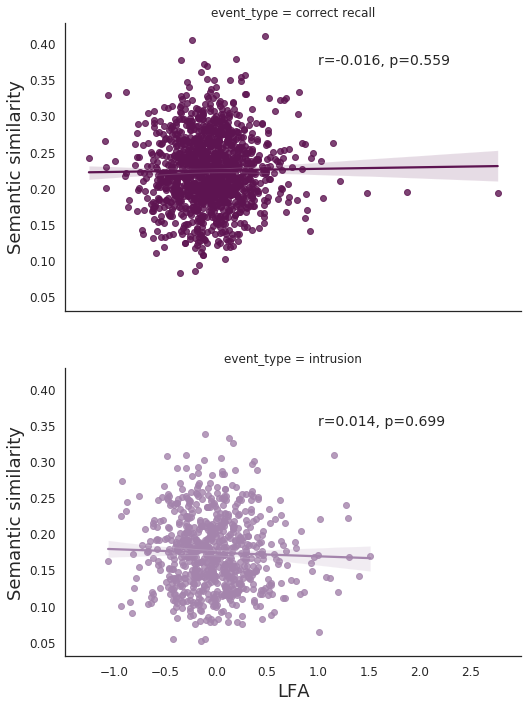

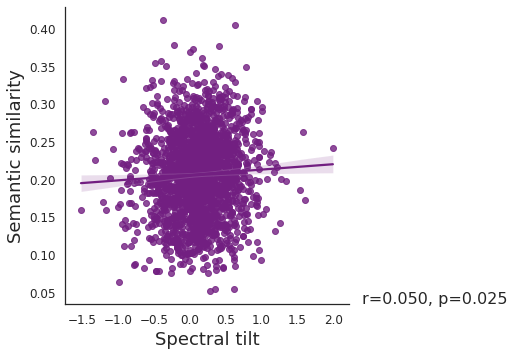

In [254]:


# events=(long_df_sem['event_type']=='intrusion') | (long_df['event_type']=='correct recall')
# use_data=long_df_sem[events]
# ax=sns.lmplot(x='LFA',y='semantic_similarity', hue='event_type',row='event_type',data=use_data,palette=['#5d1451','#a484ac'],sharex=True,legend_out=False,aspect=1.5) # remove deliberations

# ax.set_xlabels('LFA',fontsize=18)
# ax.set_ylabels('Semantic similarity',fontsize=18)
# ax.set_xticklabels(fontsize=12)
# ax.set_yticklabels(fontsize=12)

# r,p=stats.pearsonr(use_data[use_data['event_type']=='correct recall']['HFA_LFA_diff'],use_data[use_data['event_type']=='correct recall']['semantic_similarity'])
# plt.text(1.0,0.85,'r=%.3f, p=%.3f' %(r, p),fontsize=14)
# r,p=stats.pearsonr(use_data[use_data['event_type']=='intrusion']['HFA_LFA_diff'],use_data[use_data['event_type']=='intrusion']['semantic_similarity'])
# plt.text(1.0,0.35,'r=%.3f, p=%.3f' %(r, p),fontsize=14)

# # pearson across event type:
# r,p=stats.pearsonr(use_data['HFA_LFA_diff'],use_data['semantic_similarity'])
# # plt.text(2.4,0.035,'r=%.3f, p=%.3f' %(r, p),fontsize=16)
# plt.tight_layout()# title('r=%.3f, p=%.3f' %(r, p),fontsize=16)

# plt.subplots_adjust(hspace=0.2,wspace=0.1)
# print('Spectral tilt:',r,'p value:',p)
# savefig('corr_semantic_sim_spectral_tilt_event',transparent=True,bbox_inches='tight', pad_inches=0.08)

# # Plot all events together:

# sns.set_palette("magma",2) #("Paired")
# ax=sns.lmplot(x='HFA_LFA_diff',y='semantic_similarity',data=use_data,palette='pastel')#,color=['#5d1451']) # remove deliberations
# pal = sns.color_palette()

# plt.text(2.4,0.035,'r=%.3f, p=%.3f' %(r, p),fontsize=16)
# ax.set_xlabels('Spectral tilt',fontsize=18)
# ax.set_ylabels('Semantic similarity',fontsize=18)
# ax.set_xticklabels(fontsize=12)
# ax.set_yticklabels(fontsize=12)
# sns.set(style="white")

# # savefig('corr_semantic_sim_spectral_tilt',transparent=True,bbox_inches='tight', pad_inches=0.08)



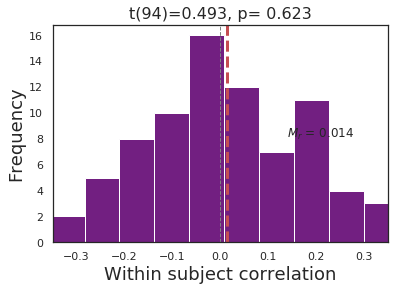

In [90]:
# pearson_r=[]
# pearson_p=[]
# for sub in use_data['subject'].unique():
#     subj_mean=use_data[use_data['subject']==sub] 
#     subj_mean_intrusion=subj_mean[subj_mean['event_type']=='intrusion']
#     if len(subj_mean_intrusion)>=7:
#         r,p=stats.pearsonr(subj_mean_intrusion['HFA_LFA_diff'],subj_mean_intrusion['semantic_similarity'])
#         pearson_r.append(r)
#         pearson_p.append(p)
# plt.hist(pearson_r,bins=20, color=pal[0])
# mean_r=np.mean(pearson_r)
# plt.axvline(x=mean_r,color='r',linestyle='--',linewidth=3)
# plt.xlim(xmin=-0.35, xmax=0.35)
# plt.xlabel('Within subject correlation',fontsize=18)
# plt.ylabel('Frequency',fontsize=18)
# plt.axvline(x=0,color='gray',linestyle='--',linewidth=1)
# # plt.hist(pearson_p,bins=20, color=None)
# plt.text(0.14,8.1,'$M_{r}$ = %.3f' %mean_r)


# # one sample t-test on correlation values
# from scipy.stats import ttest_1samp
# tscore, pvalue = ttest_1samp(pearson_r, popmean=0)
# df=len(pearson_r)-1
# # print("t Statistic: ", tscore)  
# # print("P Value: ", pvalue)
# plt.title('t(%1.f)=%.3f, p= %.3f' %(df,tscore,pvalue),fontsize=16) 


# savefig('hist_semantic_sim_spectral_tilt',transparent=True,bbox_inches='tight', pad_inches=0.08)


From here I compute means per event type and plot the results

In [20]:
# compute means
# column_string: 'HFA_LFA_diff'/'LFA'/'HFA'
# condition: 'all'/'related'/'nonrelated'
# exmaple: average_tilt(long_df,'all','HFA_LFA_diff'):
def average_tilt(long_df,condition,column_string):
    '''
    Compute average for each event type (correct recall/intrusion/deliberation) as well as the difference between correct recalls and intrusions.
    column_string can be: 'HFA_LFA_diff'/'LFA'/'HFA'
    condition can be: 'all'/'related'/'nonrelated'
    exmaple: average_tilt(long_df,'all','HFA_LFA_diff')
    '''
    
    import pandas as pd
    if condition == 'all':
        print('Mean over all intrusions is calculated')
        pass
    elif condition == 'related': 
        long_df = long_df[long_df['semantic_relatedness']==1]
    elif condition == 'nonrelated':        
        intrusions_index=long_df[long_df['event_type'].isin(['intrusion','PLI','ELI'])].index
        intrusions_only=long_df.loc[intrusions_index]
        intrusions_related=intrusions_only[intrusions_only['semantic_relatedness']==1].index
        long_df = long_df.drop(labels=list(intrusions_related))
    else:
        print('Wrong condition parameter. Options are: "all"/"related" or "nonrelated" ')
        
    diff=pd.DataFrame([])
    correct_recall_mean_tilt=[]
    intrusion_mean_tilt=[]
    deliberation_mean_tilt=[]
    ELI_mean_tilt=[]
    PLI_mean_tilt=[]
    for sub in long_df['subject'].unique():
#         print(sub)
        subj_mean=long_df[long_df['subject']==sub]
        try:
            assert 'correct recall' in subj_mean['event_type'].unique(),f'correct recall missing for subject {sub}'
            assert 'intrusion' in subj_mean['event_type'].unique(),f'intrusions missing for subject {sub}'
            assert 'deliberation' in subj_mean['event_type'].unique(),f'deliberations missing for subject {sub}'
            if 'PLI' in subj_mean['event_type'].unique():
                sub_num=subj_mean['subject'].unique()
                assert 'ELI' in subj_mean['event_type'].unique(), f'problem with subject {sub_num}'
            
            for event in subj_mean['event_type'].unique():
                mean_tilt=np.mean(subj_mean[subj_mean['event_type']==event][column_string])
                if event=='correct recall':
                    correct_recall_mean_tilt.append(mean_tilt)
                elif event=='intrusion':
                    intrusion_mean_tilt.append(mean_tilt)
                elif event=='deliberation':
                    deliberation_mean_tilt.append(mean_tilt)
                elif event=='PLI':
                    PLI_mean_tilt.append(mean_tilt)
                elif event=='ELI':
                    ELI_mean_tilt.append(mean_tilt) 

            for sess in subj_mean['sessions'].unique():
                sess_data=subj_mean[subj_mean['sessions']==sess]
                correct_rec=np.mean(sess_data[sess_data['event_type']=='correct recall'][column_string])
                intrusion=np.mean(sess_data[sess_data['event_type']=='intrusion'][column_string])
    #             tilt_diff.append(correct_r_tilt - intrusion_tilt)
                diff=diff.append({'subject': sub, 'session':sess,'correct_intrusion_diff': correct_rec - intrusion},ignore_index=True)
        except: 
            pass
    return diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt
       

In [21]:
# #choose between:
# 1.  < / > median semantic similarity:
# if exp=='catFR':
#     median_similarity=nanmedian(long_df['semantic_similarity'])

#     tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(long_df[long_df['semantic_similarity']>median_similarity])

# # Spectral-tilt (HFA-LFA):
# # 2. tilt of intrusions that are semanticaly related to encoded categories (1)
# tilt_diff_related,correct_recall_mean_tilt_related,intrusion_mean_tilt_related,deliberation_mean_tilt_related,PLI_mean_tilt_related,ELI_mean_tilt_related=average_tilt(long_df,'related','HFA_LFA_diff')

# # 3. tilt of intrusions that are semantivaly nomrelated to encoded categories (0)
# tilt_diff_nonrelated,correct_recall_mean_tilt_nonrelated,intrusion_mean_tilt_nonrelated,deliberation_mean_tilt_nonrelated,PLI_mean_tilt_nonrelated,ELI_mean_tilt_nonrelated=average_tilt(long_df,'nonrelated','HFA_LFA_diff')

# # 4. tilt of all data
# tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(long_df,'all','HFA_LFA_diff')

# #  -- HFA only:
# # 5. HFA of intrusions that are semanticaly related to encoded categories (1)
# HFA_diff_related,correct_recall_mean_HFA_related,intrusion_mean_HFA_related,deliberation_mean_HFA_related,PLI_mean_HFA_related,HFA_mean_HFA_related=average_tilt(long_df,'related','HFA')

# # 6. HFA of intrusions that are semanticaly nonrelated to encoded categories (0)
# HFA_diff_nonrelated,correct_recall_mean_HFA_nonrelated,intrusion_mean_HFA_nonrelated,deliberation_mean_HFA_nonrelated,PLI_mean_HFA_nonrelated,ELI_mean_HFA_nonrelated=average_tilt(long_df,'nonrelated','HFA')

# 7. HFA of all data
HFA_diff,correct_recall_mean_HFA,intrusion_mean_HFA,deliberation_mean_HFA,PLI_mean_HFA,ELI_mean_HFA=average_tilt(long_df,'all','HFA')


#  -- LFA only:
# # 5. LFA of intrusions that are semanticaly related to encoded categories (1)
# LFA_diff_related,correct_recall_mean_LFA_related,intrusion_mean_LFA_related,deliberation_mean_LFA_related,PLI_mean_LFA_related,ELI_mean_LFA_related=average_tilt(long_df,'related','LFA')

# # 6. LFA of intrusions that are semanticaly nonrelated to encoded categories (0)
# LFA_diff_nonrelated,correct_recall_mean_LFA_nonrelated,intrusion_mean_LFA_nonrelated,deliberation_mean_LFA_nonrelated,PLI_mean_LFA_nonrelated,ELI_mean_LFA_nonrelated=average_tilt(long_df,'nonrelated','LFA')

# 7. LFA of all data
LFA_diff,correct_recall_mean_LFA,intrusion_mean_LFA,deliberation_mean_LFA,PLI_mean_LFA,ELI_mean_LFA=average_tilt(long_df,'all','LFA')




Mean over all intrusions is calculated
Mean over all intrusions is calculated


In [22]:
correct_recall_mean_LFA

[-0.035246245415007794,
 -0.03752754023912466,
 0.0759603352268835,
 -0.07607683161615995,
 0.03811863144281619,
 -0.057586631439824607,
 -0.018821083928599755,
 -0.033293778623656116,
 0.024604244937810837,
 -0.02466403695806023,
 -0.08043715289844318,
 -0.07648918020663373,
 -0.08354394228236706,
 -0.10198578928266919,
 0.00048691933662694034,
 0.03791204802880635,
 -0.06972489086845911,
 -0.051313445983405835,
 -0.08839230259664797,
 -0.06098572476104328,
 -0.1878851915319421,
 -0.015590937006747541,
 -0.03651795753890248,
 -0.06346335808659372,
 0.4956339576694746,
 0.046277758980962085,
 -0.11258379615810359,
 -0.013189989275024159,
 -0.07538927728101852,
 -0.0808238752596743,
 -0.12672151110476773,
 -0.010700244492667764,
 0.021359568546624665,
 -0.17259369341384537,
 -0.014851128258390014,
 0.09567977946021432,
 0.05860970782648964,
 0.06208436435968568,
 -0.22654297123408904,
 0.003966079732452367,
 0.101201930754089,
 -0.07459729669680733,
 0.07255395727537635,
 -0.03099895817

In [23]:
def events_avg(event_type):
    avg_event=np.mean(event_type)
    ste_mean_event=np.std(event_type)/np.sqrt(len(event_type))
    return avg_event,ste_mean_event

In [142]:
# Compute mean and ste of ** spectral-tilt ** for each event type (and for both semantic related and nonrelated intrusions)
# Correct-recall:
avg_mean_correct_recall, ste_mean_correct_recall = events_avg(correct_recall_mean_tilt)
avg_mean_correct_recall_nonrelated, ste_mean_correct_recall_nonrelated = events_avg(correct_recall_mean_tilt_nonrelated)
avg_mean_correct_recall_related, ste_mean_correct_recall_related = events_avg(correct_recall_mean_tilt_related)
# Intrusion:
avg_mean_intrusion, ste_mean_intrusion = events_avg(intrusion_mean_tilt)
avg_mean_intrusion_nonrelated, ste_mean_intrusion_nonrelated = events_avg(intrusion_mean_tilt_nonrelated)
avg_mean_intrusion_related, ste_mean_intrusion_related = events_avg(intrusion_mean_tilt_related)
# Deliberation:
avg_mean_deliberation, ste_mean_deliberation = events_avg(deliberation_mean_tilt)
avg_mean_deliberation_nonrelated, ste_mean_deliberation_nonrelated = events_avg(deliberation_mean_tilt_nonrelated)
avg_mean_deliberation_related, ste_mean_deliberation_related = events_avg(deliberation_mean_tilt_related)
# PLI:
avg_mean_PLI, ste_mean_PLI = events_avg(PLI_mean_tilt)
avg_mean_PLI_nonrelated, ste_mean_PLI_nonrelated = events_avg(PLI_mean_tilt_nonrelated)
avg_mean_PLI_related, ste_mean_PLI_related = events_avg(PLI_mean_tilt_related)
# ELI:
avg_mean_ELI, ste_mean_ELI = events_avg(ELI_mean_tilt)
avg_mean_ELI_nonrelated, ste_mean_ELI_nonrelated = events_avg(ELI_mean_tilt_nonrelated)
avg_mean_ELI_related, ste_mean_ELI_related = events_avg(ELI_mean_tilt_related)



NameError: name 'correct_recall_mean_tilt' is not defined

In [24]:
# OR: Compute mean and ste of ** LFA **
# correct-recall
avg_mean_correct_recall, ste_mean_correct_recall = events_avg(correct_recall_mean_LFA) 
# avg_mean_correct_recall_nonrelated, ste_mean_correct_recall_nonrelated = events_avg(correct_recall_mean_LFA_nonrelated)
# avg_mean_correct_recall_related, ste_mean_correct_recall_related = events_avg(correct_recall_mean_LFA_related)
# Intrusion:
avg_mean_intrusion, ste_mean_intrusion = events_avg(intrusion_mean_LFA)
# avg_mean_intrusion_nonrelated, ste_mean_intrusion_nonrelated = events_avg(intrusion_mean_LFA_nonrelated)
# avg_mean_intrusion_related, ste_mean_intrusion_related = events_avg(intrusion_mean_LFA_related)
# Deliberation:
avg_mean_deliberation, ste_mean_deliberation = events_avg(deliberation_mean_LFA)
# avg_mean_deliberation_nonrelated, ste_mean_deliberation_nonrelated = events_avg(deliberation_mean_LFA_nonrelated)
# avg_mean_deliberation_related, ste_mean_deliberation_related = events_avg(deliberation_mean_LFA_related)
# PLI:
avg_mean_PLI, ste_mean_PLI = events_avg(PLI_mean_LFA)
# avg_mean_PLI_nonrelated, ste_mean_PLI_nonrelated = events_avg(PLI_mean_LFA_nonrelated)
# avg_mean_PLI_related, ste_mean_PLI_related = events_avg(PLI_mean_LFA_related)
# ELI:
avg_mean_ELI, ste_mean_ELI = events_avg(ELI_mean_LFA)
# avg_mean_ELI_nonrelated, ste_mean_ELI_nonrelated = events_avg(ELI_mean_LFA_nonrelated)
# avg_mean_ELI_related, ste_mean_ELI_related = events_avg(ELI_mean_LFA_related)



In [30]:
exp='FR1'

In [31]:

# #set color scheme
if exp=='catFR1':
#     colors=['#5d1451','#a484ac','#b1a1c0','thistle']#['#734a65','#a484ac','thistle']#['rebeccapurple','mediumpurple','thistle']
#     colors=['#351c75','#674ea7','#8e7cc3','#b4a7d6']#['#734a65','#a484ac','thistle']#['rebeccapurple','mediumpurple','thistle']
#     colors=['#240b3a','#775a90','#b1a1c0','#d8d0df']
#     colors=['#65365a','#775a90','#b1a1c0','#d8d0df']
#     colors=['#355c7d','#6c5b7b','#c06c84','#d8d0df']
    colors=['#5d1451','#a484ac','indianred','thistle']#['#734a65','#a484ac','thistle']#['rebeccapurple','mediumpurple','thistle']


#     colors=['#240b3a','#5d1451','#b1a1c0','thistle']#['#734a65','#a484ac','thistle']#['rebeccapurple','mediumpurple','thistle']
elif exp in ['FR1','pyFR']:
#     colors=['#1f6357','#65ab7c','#bcecac'] #mediumseagreen
    colors=['#1f6357','#65ab7c','#bcecac','mediumseagreen']
# plot

In [38]:
fig_path='/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization/figures'

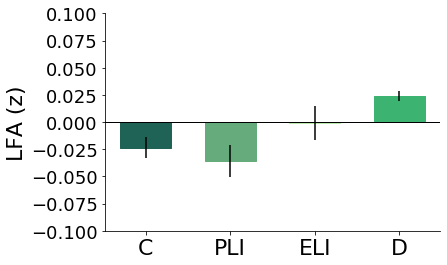

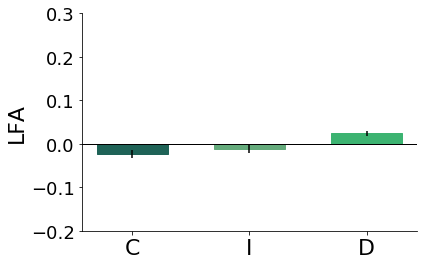

In [40]:
# plot all data

# error = [ste_mean_correct_recall,ste_mean_intrusion,ste_mean_PLI,ste_mean_ELI,ste_mean_deliberation]
error = [ste_mean_correct_recall,ste_mean_PLI,ste_mean_ELI,ste_mean_deliberation]

fig=plt.figure()
# h=plt.bar([0,1,2,3,4],[avg_mean_correct_recall,avg_mean_intrusion, avg_mean_PLI,avg_mean_ELI,avg_mean_deliberation],yerr=error,width=0.6,edgecolor='black')
h=plt.bar([0,1,2,3],[avg_mean_correct_recall, avg_mean_PLI,avg_mean_ELI,avg_mean_deliberation],yerr=error,width=0.6,edgecolor='black')

h[0].set_color(colors[0])
# h[1].set_color(colors[1])
h[1].set_color(colors[1])
h[2].set_color(colors[2])
h[3].set_color(colors[3])
h[0].set_edgecolor(colors[0])
# h[1].set_edgecolor(colors[1])
h[1].set_edgecolor(colors[1])
h[2].set_edgecolor(colors[2])
h[3].set_edgecolor(colors[3])
# plt.xticks([0,1,2,3,4],['C','I','PLI','ELI','D'],fontsize=22, rotation=0)
plt.xticks([0,1,2,3],['C','PLI','ELI','D'],fontsize=22, rotation=0)

plt.yticks(fontsize=18)
plt.ylim((-0.1,0.1))
#plt.xlabel('Event type',fontsize=18)
# plt.ylabel('Spectral tilt',fontsize=22); plt.ylim((-0.2, 0.3))
plt.ylabel('LFA (z)',fontsize=22); 

plt.axhline(y=0,color='black',linewidth=1)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')#plt.box(on=None)
plt.grid(False)

savefig(f"{fig_path}/average_spectral_tilt_strength_ELI_PLI",transparent=True,bbox_inches='tight', pad_inches=0.08)
# savefig('average_spectral_LFA2',transparent=True,bbox_inches='tight', pad_inches=0.08)


# without PLIs and ELIs
error = [ste_mean_correct_recall,ste_mean_intrusion,ste_mean_deliberation]
fig=plt.figure()
h=plt.bar([0,1,2],[avg_mean_correct_recall,avg_mean_intrusion,avg_mean_deliberation],yerr=error,width=0.6,edgecolor='black')
h[0].set_color(colors[0])#('k')
h[1].set_color(colors[1])#('grey')
h[2].set_color(colors[3])#('lightgrey')
h[0].set_edgecolor(colors[0])
h[1].set_edgecolor(colors[1])
h[2].set_edgecolor(colors[3])
plt.xticks([0,1,2],['C','I','D'],fontsize=22, rotation=0)
plt.yticks(fontsize=18)
#plt.xlabel('Event type',fontsize=18)
# plt.ylabel('Spectral tilt',fontsize=22); plt.ylim((-0.2, 0.3))
plt.ylabel('LFA',fontsize=22); plt.ylim((-0.2, 0.3))
plt.axhline(y=0,color='black',linewidth=1)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

# savefig('average_spectral_tilt_strength',transparent=True,bbox_inches='tight', pad_inches=0.08)
# savefig('average_spectral_LFA',transparent=True,bbox_inches='tight', pad_inches=0.08)

In [41]:
# Statistical test - paired t-tests on Spectral tilt
# print(' ** Spectral tilt (HFA-LFA) comparisons: **')
# C_Istatistic, C_Ipvalue= scipy.stats.ttest_rel(correct_recall_mean_tilt,intrusion_mean_tilt,nan_policy='omit')
# print('C-I t-value: %.1f' %C_Istatistic + ' p-value: %.5f' %C_Ipvalue)
# I_Dstatistic, I_Dpvalue= scipy.stats.ttest_rel(intrusion_mean_tilt,deliberation_mean_tilt,nan_policy='omit')
# print('I_D t-value: %.1f' %I_Dstatistic + ' p-value: %.12f' %I_Dpvalue)
# C_Dstatistic, C_Dpvalue= scipy.stats.ttest_rel(correct_recall_mean_tilt,deliberation_mean_tilt,nan_policy='omit')
# print('C_D t-value: %.1f' %C_Dstatistic + ' p-value: %.23f' %C_Dpvalue)
# print('df: %d' %int(len(correct_recall_mean_tilt)-1))
# ELI_PLIstatistic, ELI_PLI_Dpvalue= scipy.stats.ttest_rel(ELI_mean_tilt,PLI_mean_tilt,nan_policy='omit')
# print('ELI_PLI t-value: %.1f' %ELI_PLIstatistic + ' p-value: %.3f' %ELI_PLI_Dpvalue)
# print('df: %d' %int(len(ELI_mean_tilt)-1))

# Statistical test - paired t-tests on LFA
print(' ** LFA comparisons: **')
C_Istatistic, C_Ipvalue= scipy.stats.ttest_rel(correct_recall_mean_LFA,intrusion_mean_LFA,nan_policy='omit')
print('C-I t-value: %.1f' %C_Istatistic + ' p-value: %.5f' %C_Ipvalue)
I_Dstatistic, I_Dpvalue= scipy.stats.ttest_rel(intrusion_mean_LFA,deliberation_mean_LFA,nan_policy='omit')
print('I_D t-value: %.1f' %I_Dstatistic + ' p-value: %.12f' %I_Dpvalue)
C_Dstatistic, C_Dpvalue= scipy.stats.ttest_rel(correct_recall_mean_LFA,deliberation_mean_LFA,nan_policy='omit')
print('C_D t-value: %.1f' %C_Dstatistic + ' p-value: %.23f' %C_Dpvalue)
print('df: %d' %int(len(correct_recall_mean_LFA)-1))
ELI_PLIstatistic, ELI_PLI_Dpvalue= scipy.stats.ttest_rel(ELI_mean_LFA,PLI_mean_LFA,nan_policy='omit')
print('ELI_PLI t-value: %.1f' %ELI_PLIstatistic + ' p-value: %.3f' %ELI_PLI_Dpvalue)
print('df: %d' %int(len(ELI_mean_LFA)-1))


 ** LFA comparisons: **
C-I t-value: -0.8 p-value: 0.45378
I_D t-value: -3.5 p-value: 0.000783742784
C_D t-value: -3.9 p-value: 0.00015242661166319691974
df: 99
ELI_PLI t-value: 1.5 p-value: 0.143
df: 64


In [128]:
# With semantic related and nonrelated intrusions
if exp=='catFR1':
    error = [ste_mean_correct_recall_related,ste_mean_intrusion_related,ste_mean_intrusion_nonrelated,ste_mean_deliberation_related]
    fig=plt.figure()
    h=plt.bar([0,1,2,3],[avg_mean_correct_recall_related,avg_mean_intrusion_related,avg_mean_intrusion_nonrelated,avg_mean_deliberation_related],yerr=error,width=0.6,edgecolor='black')
    h[0].set_color(colors[0])#('k')
    h[1].set_color(colors[1])#('grey')
    h[2].set_color(colors[2])#('grey')
    h[3].set_color(colors[3])#('lightgrey')
    h[0].set_edgecolor(colors[0])
    h[1].set_edgecolor(colors[1])
    h[2].set_edgecolor(colors[2])
    h[3].set_edgecolor(colors[3])
    plt.xticks([0,1,2,3],['C','S-I','NonS-I','D'],fontsize=22, rotation=0)
    plt.yticks(fontsize=18)
    #plt.xlabel('Event type',fontsize=18)
    plt.ylabel('LFA',fontsize=22); plt.ylim((-0.2, 0.3))
    plt.axhline(y=0,color='black',linewidth=1)

    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['left'].set_color('k')
    plt.gca().spines['top'].set_color('none')
    plt.gca().spines['bottom'].set_color('k')
    plt.grid(False)

    savefig('average_LFA_strength',transparent=True,bbox_inches='tight', pad_inches=0.08)

In [129]:
# Statistical test - paired t-tests on LFA between semantic relatedness conditions:
if exp=='catFR1':
    print(' ** LFA comparisons: **')
    C_Istatistic, C_Ipvalue= scipy.stats.ttest_rel(correct_recall_mean_LFA_related,intrusion_mean_LFA_related,nan_policy='omit')
    print('C-SI t-value: %.1f' %C_Istatistic + ' p-value: %.5f' %C_Ipvalue)
    C_Istatistic, C_Ipvalue= scipy.stats.ttest_rel(intrusion_mean_LFA_related,intrusion_mean_LFA_nonrelated,nan_policy='omit')
    print('SI-NonSI t-value: %.1f' %C_Istatistic + ' p-value: %.5f' %C_Ipvalue)
    C_Istatistic, C_Ipvalue= scipy.stats.ttest_rel(correct_recall_mean_LFA_nonrelated,intrusion_mean_LFA_nonrelated,nan_policy='omit')
    print('C-NonSI t-value: %.1f' %C_Istatistic + ' p-value: %.5f' %C_Ipvalue)
    I_Dstatistic, I_Dpvalue= scipy.stats.ttest_rel(intrusion_mean_LFA_nonrelated,deliberation_mean_LFA_nonrelated,nan_policy='omit')
    print('NonSI-D t-value: %.1f' %I_Dstatistic + ' p-value: %.12f' %I_Dpvalue)
    I_Dstatistic, I_Dpvalue= scipy.stats.ttest_rel(intrusion_mean_LFA_related,deliberation_mean_LFA_related,nan_policy='omit')
    print('SI-D t-value: %.1f' %I_Dstatistic + ' p-value: %.12f' %I_Dpvalue)
    C_Dstatistic, C_Dpvalue= scipy.stats.ttest_rel(correct_recall_mean_LFA_related,deliberation_mean_LFA_related,nan_policy='omit')
    print('C_D t-value: %.1f' %C_Dstatistic + ' p-value: %.23f' %C_Dpvalue)

    print('df: %d' %int(len(correct_recall_mean_LFA_related)-1))

In [130]:
len(all_intrusions_hipp_pows)
# i

251

Here I take the full power spectrum

number of sessions: 256


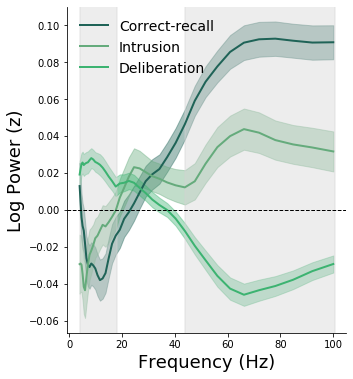

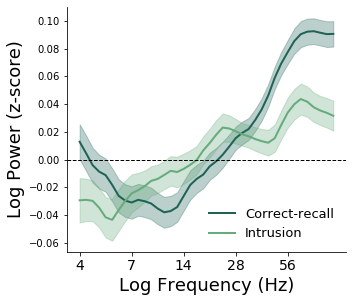

In [149]:
# Plot log (power) as a function of log frequency (similar to Nora's TICS 2020)
# choose time windows:
verbalization_start = convertMstoWindowNumber(0,-2500,-100,100,50)
pre_verbalization_end_window = convertMstoWindowNumber(-100,-2500,-100,100,50)
pre_verbalization_window = convertMstoWindowNumber(-600,-2500,-100,100,50)
deliberation_start_window = convertMstoWindowNumber(-2000,-2500,-100,100,50)
deliberation_end_window = convertMstoWindowNumber(-1500,-2500,-100,100,50)

myfreqs = np.logspace(np.log10(4), np.log10(100), 40)  #2-100 Hz, 46 frequencies

correct_recall_pow=[]
intrusion_pow=[]
deliberation_pow=[]
correct_recall_time_pow=[]
intrusion_time_pow=[]
deliberation_time_pow=[]
for i in range(0,len(correct_recall_hipp_pows)):
    correct=reshape(correct_recall_hipp_pows[i],(len(correct_recall_hipp_pows[i][0]),len(correct_recall_hipp_pows[i][0][0]),len(correct_recall_hipp_pows[i][0][0][0])))
    correct_recall_trial_avg=np.nanmean(correct,axis=1)
    correct_recall_time_avg = np.mean(correct_recall_trial_avg[:,pre_verbalization_window:pre_verbalization_end_window],axis=1)
    correct_recall_time_pow.append(correct_recall_trial_avg)
    correct_recall_pow.append(correct_recall_time_avg)
for i in range(0,len(all_intrusions_hipp_pows)):        
    intrusion=reshape(all_intrusions_hipp_pows[i],(len(all_intrusions_hipp_pows[i][0]),len(all_intrusions_hipp_pows[i][0][0]),len(all_intrusions_hipp_pows[i][0][0][0])))
    intrusion_trial_avg=np.nanmean(intrusion,axis=1)
    intrusion_time_avg = np.mean(intrusion_trial_avg[:,pre_verbalization_window:pre_verbalization_end_window],axis=1)
    intrusion_time_pow.append(intrusion_trial_avg)
    #assert any(np.isnan(intrusion_pow))==False,('subject %d has nan values') %i
    intrusion_pow.append(intrusion_time_avg)
for i in range(0,len(deliberation_hipp_pows)):      
    deliberation=reshape(deliberation_hipp_pows[i],(len(deliberation_hipp_pows[i][0]),len(deliberation_hipp_pows[i][0][0]),len(deliberation_hipp_pows[i][0][0][0])))  
    deliberation_trial_avg=np.nanmean(deliberation,axis=1)
    deliberation_time_avg = np.mean(deliberation_trial_avg[:,deliberation_start_window:deliberation_end_window],axis=1)
    deliberation_time_pow.append(deliberation_trial_avg)
    deliberation_pow.append(deliberation_time_avg)
correct_recall_group_sem=scipy.stats.sem(correct_recall_pow,axis=0,ddof=1,nan_policy='omit')
intrusions_group_sem=scipy.stats.sem(intrusion_pow,axis=0,ddof=1,nan_policy='omit')
deliberation_group_sem=scipy.stats.sem(deliberation_pow,axis=0,ddof=1,nan_policy='omit')
correct_recall_group_avg=np.nanmean(correct_recall_pow,axis=0)
intrusions_group_avg=np.nanmean(intrusion_pow,axis=0)
deliberation_group_avg=np.nanmean(deliberation_pow,axis=0)

print('number of sessions:', len(deliberation_pow))
fig=plt.figure(figsize=(6.5,5));#ax=plt.subplot(121)
plt.plot(myfreqs,correct_recall_group_avg,linewidth=2,color=colors[0])
plt.fill_between(myfreqs,correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.4)
plt.plot(myfreqs,intrusions_group_avg,linewidth=2,color=colors[1])
plt.fill_between(myfreqs,intrusions_group_avg-intrusions_group_sem,intrusions_group_avg+intrusions_group_sem,color=colors[1],alpha=0.4)
plt.plot(myfreqs,deliberation_group_avg,linewidth=2,color=colors[3])
plt.fill_between(myfreqs,deliberation_group_avg-deliberation_group_sem,deliberation_group_avg+deliberation_group_sem,color=colors[3],alpha=0.4)
#plt.title('Avergae PSD')
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('Log Power (z)',fontsize=18)
plt.axhline(y=0,color='black',linewidth=1,linestyle='--')
plt.legend(['Correct-recall','Intrusion','Deliberation'],fontsize=14,frameon=False)#loc='upper left')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

rect = plt.Rectangle((4,-0.15),18-4,0.14+0.141,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')
rect2 = plt.Rectangle((44,-0.15),100.5-44,0.141+0.14,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')

# Add the patch to the Axes
plt.gca().add_patch(rect)
plt.gca().add_patch(rect2)

savefig('/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization/figures/spectral_tilt',transparent=True,bbox_inches='tight', pad_inches=0.08)


fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(122)
plt.plot(np.log10(myfreqs),correct_recall_group_avg,linewidth=2,color=colors[0])
plt.fill_between(np.log10(myfreqs),correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.3)
plt.plot(np.log10(myfreqs),intrusions_group_avg,linewidth=2,color=colors[1])
plt.fill_between(np.log10(myfreqs),intrusions_group_avg-intrusions_group_sem,intrusions_group_avg+intrusions_group_sem,color=colors[1],alpha=0.3)

frequencies= [int(freq) for freq in myfreqs[0:-1:8]]
plt.xticks(np.log10(myfreqs[0:-1:8]),frequencies,fontsize=14)
#plt.xticks([],np.round(myfreqs),fontsize=14)#
#plt.title('Avergae PSD')
plt.xlabel('Log Frequency (Hz)',fontsize=18)
plt.ylabel('Log Power (z)',fontsize=18)
plt.axhline(y=0,color='black',linewidth=1,linestyle='--')
plt.legend(['Correct-recall','Intrusion'],fontsize=13,frameon=False,loc='lower right')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

# savefig('/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization/figures/spectral_tilt_log_sme',transparent=True,bbox_inches='tight', pad_inches=0.08)
rect3 = plt.Rectangle((4,-0.15),18-4,0.14+0.141,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')
rect4 = plt.Rectangle((44,-0.15),100.5-44,0.141+0.14,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')

# Add the patch to the Axes
plt.gca().add_patch(rect3)
plt.gca().add_patch(rect4)

# ax = plt.gca()
# # plt.imshow(im)
# # Create a Rectangle patch
# # plt.axvline(x=8,color='r',linewidth=1,linestyle='--')
# # rect = plt.Rectangle((8,-0.075),18-4,1,linewidth=3,fill=True,edgecolor='k')

# # # Add the patch to the Axes
# ax.add_patch(rect)
# ax.add_patch(rect2)


# ax.add_patch(rect)
# plt.gca().add_patch(rect)
# plt.show()

In [102]:
# len(PLI_hipp_pows)
# len(ELI_hipp_pows)
# i=0
# PLI=reshape(PLI_hipp_pows[i],(len(PLI_hipp_pows[i][0]),len(PLI_hipp_pows[i][0][0]),len(PLI_hipp_pows[i][0][0][0])))
# PLI.shape
PLI_group_sem.shape
PLI_group_avg.shape
len(PLI_pow)
PLI_group_avg=np.nanmean(PLI_hipp_pows,axis=1)
PLI_group_avg.shape
# correct_recall_group_avg.shape
# np.nanmean(PLI_pow,axis=2).shape


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [105]:
np.nanmean(ELI_hipp_pows,axis=0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

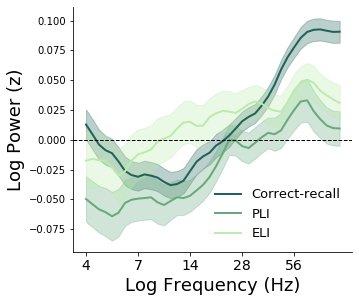

In [108]:
# plot log as a function of intrusions' temporal context (ELI/PLI)

# # Plot log (power) as a function of log frequency (similar to Nora's TICS 2020)
# # choose time windows:
# verbalization_start = convertMstoWindowNumber(0,-2500,-100,100,50)
# pre_verbalization_end_window = convertMstoWindowNumber(-100,-2500,-100,100,50)
# pre_verbalization_window = convertMstoWindowNumber(-600,-2500,-100,100,50)
# deliberation_start_window = convertMstoWindowNumber(-2000,-2500,-100,100,50)
# deliberation_end_window = convertMstoWindowNumber(-1500,-2500,-100,100,50)

# myfreqs = np.logspace(np.log10(4), np.log10(100), 40)  #2-100 Hz, 46 frequencies

# correct_recall_pow=[]
# ELI_pow=[]
# PLI_pow=[]
# deliberation_pow=[]
# correct_recall_time_pow=[]
# PLI_time_pow=[]
# ELI_time_pow=[]
# deliberation_time_pow=[]
# for i in range(0,len(correct_recall_hipp_pows)):
#     correct=reshape(correct_recall_hipp_pows[i],(len(correct_recall_hipp_pows[i][0]),len(correct_recall_hipp_pows[i][0][0]),len(correct_recall_hipp_pows[i][0][0][0])))
#     correct_recall_trial_avg=np.nanmean(correct,axis=1)
#     correct_recall_time_avg = np.mean(correct_recall_trial_avg[:,pre_verbalization_window:pre_verbalization_end_window],axis=1)
#     correct_recall_time_pow.append(correct_recall_trial_avg)
#     correct_recall_pow.append(correct_recall_time_avg)
# for i in range(0,len(PLI_hipp_pows)):        
#     PLI=reshape(PLI_hipp_pows[i],(len(PLI_hipp_pows[i][0]),len(PLI_hipp_pows[i][0][0]),len(PLI_hipp_pows[i][0][0][0])))
#     PLI_trial_avg=np.nanmean(PLI,axis=1)
#     PLI_time_avg = np.mean(PLI_trial_avg[:,pre_verbalization_window:pre_verbalization_end_window],axis=1)
#     PLI_time_pow.append(PLI_trial_avg)
#     PLI_pow.append(PLI_time_avg)
# for i in range(0,len(ELI_hipp_pows)):        
#     ELI=reshape(ELI_hipp_pows[i],(len(ELI_hipp_pows[i][0]),len(ELI_hipp_pows[i][0][0]),len(ELI_hipp_pows[i][0][0][0])))
#     ELI_trial_avg=np.nanmean(ELI,axis=1)
#     ELI_time_avg = np.mean(ELI_trial_avg[:,pre_verbalization_window:pre_verbalization_end_window],axis=1)
#     ELI_time_pow.append(ELI_trial_avg)
#     ELI_pow.append(ELI_time_avg)
# for i in range(0,len(deliberation_hipp_pows)):      
#     deliberation=reshape(deliberation_hipp_pows[i],(len(deliberation_hipp_pows[i][0]),len(deliberation_hipp_pows[i][0][0]),len(deliberation_hipp_pows[i][0][0][0])))  
#     deliberation_trial_avg=np.nanmean(deliberation,axis=1)
#     deliberation_time_avg = np.mean(deliberation_trial_avg[:,deliberation_start_window:deliberation_end_window],axis=1)
#     deliberation_time_pow.append(deliberation_trial_avg)
#     deliberation_pow.append(deliberation_time_avg)
# correct_recall_group_sem=scipy.stats.sem(correct_recall_pow,axis=0,ddof=1,nan_policy='omit')
# PLI_group_sem=scipy.stats.sem(PLI_pow,axis=0,ddof=1,nan_policy='omit')
# ELI_group_sem=scipy.stats.sem(ELI_pow,axis=0,ddof=1,nan_policy='omit')
# deliberation_group_sem=scipy.stats.sem(deliberation_pow,axis=0,ddof=1,nan_policy='omit')

# correct_recall_group_avg=np.nanmean(correct_recall_pow,axis=0)
# PLI_group_avg=np.nanmean(PLI_pow,axis=0)
# ELI_group_avg=np.nanmean(ELI_pow,axis=0)
# deliberation_group_avg=np.nanmean(deliberation_pow,axis=0)

# print('number of sessions:', len(deliberation_pow))
# fig=plt.figure(figsize=(6.5,5));#ax=plt.subplot(121)
# plt.plot(myfreqs,correct_recall_group_avg,linewidth=2,color=colors[0])
# plt.fill_between(myfreqs,correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.4)
# plt.plot(myfreqs,PLI_group_avg,linewidth=2,color=colors[1])
# plt.fill_between(myfreqs,PLI_group_avg-PLI_group_sem,PLI_group_avg+PLI_group_sem,color=colors[1],alpha=0.4)
# plt.plot(myfreqs,ELI_group_avg,linewidth=2,color=colors[2])
# plt.fill_between(myfreqs,ELI_group_avg-ELI_group_sem,ELI_group_avg+ELI_group_sem,color=colors[2],alpha=0.4)

# plt.plot(myfreqs,deliberation_group_avg,linewidth=2,color=colors[3])
# plt.fill_between(myfreqs,deliberation_group_avg-deliberation_group_sem,deliberation_group_avg+deliberation_group_sem,color=colors[3],alpha=0.4)
# #plt.title('Avergae PSD')
# plt.xlabel('Frequency (Hz)',fontsize=18)
# plt.ylabel('Log Power (z)',fontsize=18)
# plt.axhline(y=0,color='black',linewidth=1,linestyle='--')
# plt.legend(['Correct-recall','Intrusion','Deliberation'],fontsize=14,frameon=False)#loc='upper left')
# plt.gca().spines['right'].set_color('none')
# plt.gca().spines['left'].set_color('k')
# plt.gca().spines['top'].set_color('none')
# plt.gca().spines['bottom'].set_color('k')
# plt.grid(False)

# rect = plt.Rectangle((4,-0.15),18-4,0.14+0.141,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')
# rect2 = plt.Rectangle((44,-0.15),100.5-44,0.141+0.14,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')

# # Add the patch to the Axes
# plt.gca().add_patch(rect)
# plt.gca().add_patch(rect2)

# savefig(f"{fig_path}/spectral_tilt_ELI_PLI",transparent=True,bbox_inches='tight', pad_inches=0.08)


fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(122)
plt.plot(np.log10(myfreqs),correct_recall_group_avg,linewidth=2,color=colors[0])
plt.fill_between(np.log10(myfreqs),correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.3)
plt.plot(np.log10(myfreqs),PLI_group_avg,linewidth=2,color=colors[1])
plt.fill_between(np.log10(myfreqs),PLI_group_avg-PLI_group_sem,PLI_group_avg+PLI_group_sem,color=colors[1],alpha=0.3)
plt.plot(np.log10(myfreqs),ELI_group_avg,linewidth=2,color=colors[2])
plt.fill_between(np.log10(myfreqs),ELI_group_avg-ELI_group_sem,ELI_group_avg+ELI_group_sem,color=colors[2],alpha=0.3)


frequencies= [int(freq) for freq in myfreqs[0:-1:8]]
plt.xticks(np.log10(myfreqs[0:-1:8]),frequencies,fontsize=14)
#plt.xticks([],np.round(myfreqs),fontsize=14)#
#plt.title('Avergae PSD')
plt.xlabel('Log Frequency (Hz)',fontsize=18)
plt.ylabel('Log Power (z)',fontsize=18)
plt.axhline(y=0,color='black',linewidth=1,linestyle='--')
plt.legend(['Correct-recall','PLI','ELI'],fontsize=13,frameon=False,loc='lower right')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

# savefig('/home1/noaherz/Long2017/FR1_replication_results/mirrored_buffer/FR1/hipp_pre_vocalization/figures/spectral_tilt_log_sme',transparent=True,bbox_inches='tight', pad_inches=0.08)
# rect3 = plt.Rectangle((4,-0.15),18-4,0.14+0.141,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')
# rect4 = plt.Rectangle((44,-0.15),100.5-44,0.141+0.14,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')

# # Add the patch to the Axes
# plt.gca().add_patch(rect3)
# plt.gca().add_patch(rect4)

savefig(f"{fig_path}/spectral_tilt_ELI_PLI_log",transparent=True,bbox_inches='tight', pad_inches=0.08)



In [60]:
# Plot log (power) as a function of log frequency for semantically related vs. non-related events

# colors=['#240b3a','#775a90','#b1a1c0','#d8d0df']

correct_recall_pow=[]
nonrelated_intrusion_pow=[]
related_intrusion_pow=[]
deliberation_pow=[]
correct_recall_time_pow=[]
nonrelated_intrusion_time_pow=[]
related_intrusion_time_pow=[]
deliberation_time_pow=[]

for i in range(0,len(correct_recall_hipp_pows)):
    correct_recall_trial_avg=np.nanmean(correct_recall_hipp_pows[i],axis=1)
    correct_recall_time_avg = np.mean(correct_recall_trial_avg[:,pre_verbalization_window:verbalization_start],axis=1)
    correct_recall_time_pow.append(correct_recall_trial_avg)
    correct_recall_pow.append(correct_recall_time_avg)

    nonrelated_intrusion_trial_avg=np.nanmean(nonrelated_intrusions_pows[i],axis=1)
    nonrelated_intrusion_time_avg = np.nanmean(nonrelated_intrusion_trial_avg[:,pre_verbalization_window:verbalization_start],axis=1)
    nonrelated_intrusion_time_pow.append(nonrelated_intrusion_trial_avg)
    #assert any(np.isnan(intrusion_pow))==False,('subject %d has nan values') %i
    nonrelated_intrusion_pow.append(nonrelated_intrusion_time_avg)

    related_intrusion_trial_avg=np.nanmean(related_intrusions_pows[i],axis=1)
    related_intrusion_time_avg = np.nanmean(related_intrusion_trial_avg[:,pre_verbalization_window:verbalization_start],axis=1)
    related_intrusion_time_pow.append(related_intrusion_time_avg)
    #assert any(np.isnan(intrusion_pow))==False,('subject %d has nan values') %i
    related_intrusion_pow.append(related_intrusion_time_avg)

    deliberation_trial_avg=np.nanmean(deliberation_hipp_pows[i],axis=1)
    deliberation_time_avg = np.mean(deliberation_trial_avg[:,deliberation_start_window:deliberation_end_window],axis=1)
    deliberation_time_pow.append(deliberation_trial_avg)
    deliberation_pow.append(deliberation_time_avg)
#standard errors:
correct_recall_group_sem=scipy.stats.sem(correct_recall_pow,axis=0,ddof=1,nan_policy='omit')
nonrelated_intrusions_group_sem=scipy.stats.sem(nonrelated_intrusion_pow,axis=0,ddof=1,nan_policy='omit')
related_intrusions_group_sem=scipy.stats.sem(related_intrusion_pow,axis=0,ddof=1,nan_policy='omit')
deliberation_group_sem=scipy.stats.sem(deliberation_pow,axis=0,ddof=1,nan_policy='omit')
# means:
correct_recall_group_avg=np.nanmean(correct_recall_pow,axis=0)
nonrelated_intrusions_group_avg=np.nanmean(nonrelated_intrusion_pow,axis=0)
related_intrusions_group_avg=np.nanmean(related_intrusion_pow,axis=0)
deliberation_group_avg=np.mean(deliberation_pow,axis=0)

print('number of sessions:', len(deliberation_pow))
fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(121)
plt.plot(myfreqs,correct_recall_group_avg,linewidth=2,color=colors[0])
plt.fill_between(myfreqs,correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.4)
plt.plot(myfreqs,related_intrusions_group_avg,linewidth=2,color=colors[1])
plt.fill_between(myfreqs,related_intrusions_group_avg-related_intrusions_group_sem,related_intrusions_group_avg+related_intrusions_group_sem,color=colors[1],alpha=0.4)
plt.plot(myfreqs,nonrelated_intrusions_group_avg,linewidth=2,color=colors[2])
plt.fill_between(myfreqs,nonrelated_intrusions_group_avg-nonrelated_intrusions_group_sem,nonrelated_intrusions_group_avg+nonrelated_intrusions_group_sem,color=colors[2],alpha=0.4)
plt.plot(myfreqs,deliberation_group_avg,linewidth=2,color=colors[3])
plt.fill_between(myfreqs,deliberation_group_avg-deliberation_group_sem,deliberation_group_avg+deliberation_group_sem,color=colors[3],alpha=0.4)

#plt.title('Avergae PSD')
plt.xlabel('Frequency (Hz)',fontsize=18)
plt.ylabel('Log Power (z-score)',fontsize=18)
plt.axhline(y=0,color='black',linewidth=1,linestyle='--')
plt.legend(['C','S-I','NonS-I','D'],fontsize=14,frameon=False)#loc='upper left')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

rect = plt.Rectangle((4,-0.15),18-4,0.14+0.141,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')
rect2 = plt.Rectangle((44,-0.15),100.5-44,0.141+0.14,linewidth=1.5,fill=True,alpha=0.4,facecolor='lightgrey', edgecolor='lightgrey')

# # Add the patch to the Axes
# plt.gca().add_patch(rect)
# plt.gca().add_patch(rect2)

# savefig('spectral_tilt',transparent=True,bbox_inches='tight', pad_inches=0.08)


fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(122)
plt.plot(np.log10(myfreqs),correct_recall_group_avg,linewidth=2,color=colors[0])
plt.fill_between(np.log10(myfreqs),correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.4)
plt.plot(np.log10(myfreqs),related_intrusions_group_avg,linewidth=2,color=colors[1])
plt.fill_between(np.log10(myfreqs),related_intrusions_group_avg-related_intrusions_group_sem,related_intrusions_group_avg+related_intrusions_group_sem,color=colors[1],alpha=0.4)
plt.plot(np.log10(myfreqs),nonrelated_intrusions_group_avg,linewidth=2,color=colors[2])
plt.fill_between(np.log10(myfreqs),nonrelated_intrusions_group_avg-nonrelated_intrusions_group_sem,nonrelated_intrusions_group_avg+nonrelated_intrusions_group_sem,color=colors[2],alpha=0.4)


frequencies= [int(freq) for freq in myfreqs[0:-1:8]]
plt.xticks(np.log10(myfreqs[0:-1:8]),frequencies,fontsize=14)
#plt.xticks([],np.round(myfreqs),fontsize=14)#
#plt.title('Avergae PSD')
plt.xlabel('Log Frequency (Hz)',fontsize=18)
plt.ylabel('Log Power (z-score)',fontsize=18)
plt.axhline(y=0,color='black',linewidth=1,linestyle='--')
plt.legend(['C','S-I','NonS-I'],fontsize=13,frameon=False,loc='best')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

savefig('spectral_tilt_log_sme_semantic_legend',transparent=True,bbox_inches='tight', pad_inches=0.08)

# # ax = plt.gca()
# # plt.imshow(im)
# # Create a Rectangle patch
# plt.axvline(x=8,color='r',linewidth=1,linestyle='--')
# rect = plt.Rectangle((8,-0.075),18-4,1,linewidth=3,fill=True,edgecolor='k')

# # # Add the patch to the Axes
#ax.add_patch(rect)
# plt.gca().add_patch(rect)
# plt.show()





NameError: name 'nonrelated_intrusions_pows' is not defined

In [30]:

for i in range(0,len(correct_recall_hipp_pows)):
    try:
        correct_recall_trial_avg=np.nanmean(correct_recall_hipp_pows[i],axis=1)
        correct_recall_time_avg = np.mean(correct_recall_trial_avg[:,pre_verbalization_window:verbalization_start],axis=1)
        correct_recall_time_pow.append(correct_recall_trial_avg)
        correct_recall_pow.append(correct_recall_time_avg)
    except:
        pass
    try:
        nonrelated_intrusion_trial_avg=np.nanmean(nonrelated_intrusions_pows[i],axis=1)
        nonrelated_intrusion_time_avg = np.nanmean(nonrelated_intrusion_trial_avg[:,pre_verbalization_window:verbalization_start],axis=1)
        nonrelated_intrusion_time_pow.append(nonrelated_intrusion_trial_avg)
        #assert any(np.isnan(intrusion_pow))==False,('subject %d has nan values') %i
        nonrelated_intrusion_pow.append(nonrelated_intrusion_time_avg)
    except:
        pass
#         print(i)
    try:
        related_intrusion_trial_avg=np.nanmean(related_intrusions_pows[i],axis=1)
        related_intrusion_time_avg = np.nanmean(related_intrusion_trial_avg[:,pre_verbalization_window:verbalization_start],axis=1)
        related_intrusion_time_pow.append(related_intrusion_time_avg)
        #assert any(np.isnan(intrusion_pow))==False,('subject %d has nan values') %i
        related_intrusion_pow.append(related_intrusion_time_pow)
    except:
        pass
    
    deliberation_trial_avg=np.nanmean(deliberation_hipp_pows[i],axis=1)
    deliberation_time_avg = np.mean(deliberation_trial_avg[:,deliberation_start_window:deliberation_end_window],axis=1)
    deliberation_time_pow.append(deliberation_trial_avg)
    deliberation_pow.append(deliberation_time_avg)

NameError: name 'deliberation_time_pow' is not defined

In [31]:
# plot time frequency of each event
%matplotlib inline

myfreqs = np.logspace(np.log10(4), np.log10(100), 40)  #2-100 Hz, 46 frequencies
data = [correct_recall_time_pow, intrusion_time_pow, deliberation_time_pow]
data_names=['Correct recall', 'Intrusions','Deliberation']
for i in range(0,len(data)):
    fig=figure(figsize=(15, 11)); ax1=subplot(3,2,i+1)
    matshow(np.nanmean(np.array(data[i]),axis=0),fignum=0, aspect='auto',cmap='RdBu_r',vmin=-0.2,vmax=0.15)#,vmin=-0.15,vmax=1.15)
    ax1.invert_yaxis()
    ax1.xaxis.set_ticks_position('bottom')
    yticks(np.arange(0, len(myfreqs),4),np.round(myfreqs[::4]),fontsize=12)
    xticks(np.arange(0, len(correct_recall_hipp_pows[0][0][0]),10),range(-4500,1000,500),fontsize=12,rotation='45')
    xlabel('Time (ms)', fontsize=16); ylabel('Frequency (Hz)', fontsize=16)
    ax1.xaxis.labelpad=10;ax1.yaxis.labelpad=10
    cb = colorbar(); cb.set_label('Log power (z-score)',fontsize=16)
    plt.title(data_names[i],fontsize=20,pad=5)
    verbalization_start = convertMstoWindowNumber(0,-4500,1000,100,50)
    pre_verbalization_window = convertMstoWindowNumber(-500,-4500,1000,100,50)
    plt.axvline(x=verbalization_start,color='black') #time_window_number
    if i<2:
        plt.axvline(x=pre_verbalization_window,color='grey') #time_window_number
    elif i==2:
        deliberation_start_window = convertMstoWindowNumber(-3000,-4500,1000,100,50)
        deliberation_end_window = convertMstoWindowNumber(-2500,-4500,1000,100,50)
        plt.axvline(x=deliberation_start_window,color='grey') #time_window_number
        plt.axvline(x=deliberation_end_window,color='grey') #time_window_number
    tight_layout()
#     savefig(data_names[i],transparent=True,bbox_inches='tight', pad_inches=0.08)


NameError: name 'correct_recall_time_pow' is not defined

In [32]:
# time line of spectral tilt
myfreqs = np.logspace(np.log10(2), np.log10(100), 46)  #2-100 Hz, 46 frequencies

# average over frequencies:
HFA_index=np.where((myfreqs>=44) & (myfreqs<=100))[0] # similar to Long et al.
LFA_index=np.where((myfreqs>=4) & (myfreqs<=18))[0]# I combined the theta 4–8 Hz, alpha 8–12 Hz and beta 12-18 Hz ranges. 

correct_recall_tilt_pow=[]
intrusion_tilt_pow=[]
deliberation_tilt_pow=[]

correct_recall_HFA_pow=[]
correct_recall_LFA_pow=[]
intrusion_HFA_pow=[]
intrusion_LFA_pow=[]

for i in range(0,len(correct_recall_hipp_pows)):
    correct_recall_trial_avg=np.nanmean(correct_recall_hipp_pows[i],axis=1)
    correct_recall_HFA_avg = np.mean(correct_recall_trial_avg[HFA_index,:],axis=0)
    correct_recall_LFA_avg = np.mean(correct_recall_trial_avg[LFA_index,:],axis=0)
    correct_recall_tilt_avg = correct_recall_HFA_avg - correct_recall_LFA_avg
    correct_recall_tilt_pow.append(correct_recall_tilt_avg)  
    correct_recall_HFA_pow.append(correct_recall_HFA_avg)  
    correct_recall_LFA_pow.append(correct_recall_LFA_avg)  
    
    intrusion_trial_avg=np.nanmean(all_intrusions_hipp_pows[i],axis=1)
    intrusion_HFA_avg = np.mean(intrusion_trial_avg[HFA_index,:],axis=0)
    intrusion_LFA_avg = np.mean(intrusion_trial_avg[LFA_index,:],axis=0)
    intrusion_tilt_avg = intrusion_HFA_avg - intrusion_LFA_avg
    intrusion_tilt_pow.append(intrusion_tilt_avg)
    intrusion_HFA_pow.append(intrusion_HFA_avg)
    intrusion_LFA_pow.append(intrusion_LFA_avg)

#  # tilt:   
# correct_recall_group_sem=scipy.stats.sem(correct_recall_tilt_pow,axis=0,ddof=1,nan_policy='omit')
# intrusions_group_sem=scipy.stats.sem(intrusion_tilt_pow,axis=0,ddof=1,nan_policy='omit')
# correct_recall_group_avg=np.nanmean(correct_recall_tilt_pow,axis=0)
# intrusions_group_avg=np.nanmean(intrusion_tilt_pow,axis=0)

# LFA:   
# correct_recall_group_sem=scipy.stats.sem(correct_recall_LFA_pow,axis=0,ddof=1,nan_policy='omit')
# intrusions_group_sem=scipy.stats.sem(intrusion_LFA_pow,axis=0,ddof=1,nan_policy='omit')
# correct_recall_group_avg=np.nanmean(correct_recall_LFA_pow,axis=0)
# intrusions_group_avg=np.nanmean(intrusion_LFA_pow,axis=0)

# # HFA:   
correct_recall_group_sem=scipy.stats.sem(correct_recall_HFA_pow,axis=0,ddof=1,nan_policy='omit')
intrusions_group_sem=scipy.stats.sem(intrusion_HFA_pow,axis=0,ddof=1,nan_policy='omit')
correct_recall_group_avg=np.nanmean(correct_recall_HFA_pow,axis=0)
intrusions_group_avg=np.nanmean(intrusion_HFA_pow,axis=0)

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [33]:
# statistics

# limit the time window (# compare correct recalls and intrusions at each time bin after -2500)
# time_start_window = convertMstoWindowNumber(-2500,-4500,1000,100,50)
time_end_window = convertMstoWindowNumber(1000,-4500,1000,100,50)
# Or use the whole time window
time_start_window = convertMstoWindowNumber(-4500,-4500,1000,100,50)

correct_recall_tilt_pow_new=[]
intrusion_tilt_pow_new=[]
for sub in range(0,len(correct_recall_tilt_pow)):
    correct_recall_tilt_pow_new.append(correct_recall_tilt_pow[sub][time_start_window:]) # time_end_window
    intrusion_tilt_pow_new.append(intrusion_tilt_pow[sub][time_start_window:]) # time_end_window

statistic, pvalue = stats.ttest_rel(correct_recall_tilt_pow_new, intrusion_tilt_pow_new, nan_policy='omit')
len(pvalue)
# pvalue<0.05

109

In [34]:
#plot
print('number of sessions:', len(intrusion_tilt_pow))
fig=plt.figure(figsize=(5,4.5));#ax=plt.subplot(121)
plt.plot(range(0,correct_recall_hipp_pows[0].shape[2]),correct_recall_group_avg,linewidth=2,color=colors[0])
plt.fill_between(range(0,correct_recall_hipp_pows[0].shape[2]),correct_recall_group_avg-correct_recall_group_sem,correct_recall_group_avg+correct_recall_group_sem,color=colors[0],alpha=0.2)
plt.plot(range(0,correct_recall_hipp_pows[0].shape[2]),intrusions_group_avg,linewidth=2,color=colors[1])
plt.fill_between(range(0,correct_recall_hipp_pows[0].shape[2]),intrusions_group_avg-intrusions_group_sem,intrusions_group_avg+intrusions_group_sem,color=colors[1],alpha=0.2)
#plt.title('Avergae PSD')
#plt.xlabel('time (bins)',fontsize=18)
#plt.axvline(y=0,color='black',linewidth=1,linestyle='--')
plt.legend(['Correct-recall','Intrusion'],fontsize=14,frameon=False,loc='upper left')
plt.axvline(x=verbalization_start,color='black')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(b=None)

#time_window_number
#plt.axhline(y=0,color='black',linewidth=1,linestyle='--') #time_window_number

# t-stats
x_vals=np.array(pvalue<0.05)*1*range(0,correct_recall_tilt_pow_new[0].shape[0])
x_vals=x_vals[x_vals!=0]
x_vals=x_vals+time_start_window # added to remove initial 2500ms
# plt.plot(x_vals,-0.10*ones(len(x_vals)), 'r.')

# FDR correction
# see also https://matthew-brett.github.io/teaching/fdr.html for a good example (adapted here)
pvalue_sorted = np.sort(pvalue)
q = 0.05
N = len(pvalue_sorted)
i = np.arange(1, N+1)
below = pvalue_sorted < (q * i / N) # True where p(i)<qi/N
if any(any(pvalue_sorted < (q * i / N))):
    max_below = np.max(np.where(below)[0]) # Max Python array index where p(i)<qi/N
    fdr_p = pvalue_sorted[max_below]

    print('p_i (FDR corrected threshold):', fdr_p)

    x_vals=np.array(pvalue<fdr_p)*1*range(0,correct_recall_tilt_pow_new[0].shape[0])
    x_vals=x_vals[x_vals!=0]
    x_vals=x_vals+time_start_window # added to remove initial 2500ms
#     plt.plot(x_vals,-0.11*ones(len(x_vals)), 'b.')

    ms_to_windows_df=ms2WindowNumber(-4500,1000,100,50)
    for p in x_vals:
        time=ms_to_windows_df[ms_to_windows_df['time window number']==p]['ms (start,end)']
        print('significant time points after FDR correction: window, time(ms)',time)

xticks(np.arange(0, len(correct_recall_hipp_pows[0][0][0]),10),range(-4500,1000,500),fontsize=12,rotation='45')
xlabel('Time (ms)', fontsize=16); 
# ylabel('Spectral tilt (power)', fontsize=16)
ylabel('HFA', fontsize=16)

plt.grid(False)
# savefig('time_line_spectral_tilt',transparent=True,bbox_inches='tight', pad_inches=0.08)



number of sessions: 255


NameError: name 'colors' is not defined

<Figure size 360x324 with 0 Axes>

In [38]:
# # Cluster permutation test
# https://benediktehinger.de/blog/science/statistics-cluster-permutation-test/

# the output is the sum of the t-values in each cluster of significant t-values.
# The real cluster mass should be compared to the distribution of permuted cluster mass values.
def cluster_mass(statistic,t_critic):
    # mask=np.logical_or(t_statistic>t_critic,t_statistic<(-1*t_critic))
    mask_positive=statistic>t_critic
    mask_negative=statistic<(-1*t_critic)

    # As a statistic we could use the number of samples the cluster extends, the summed t-value etc. 
    # I use cluster-mass, which is the sum of the t-values.
    sum_t=0
    cluster_mass=[]
    mask=[mask_positive,mask_negative]
    for i in range(0,len(mask)):
        for ind,value in enumerate(mask[i]):
            if value==True:
                sum_t=sum_t+statistic[ind]
            elif value==False:
                cluster_mass.extend([sum_t])
                sum_t=0
    cluster_mass=np.array(cluster_mass)[np.array(cluster_mass)!=0]
    return cluster_mass,mask_positive,mask_negative  

In [39]:
# Real cluster mass:

# diff=np.array(correct_recall_HFA_pow) - np.array(intrusion_HFA_pow)
df=len(correct_recall_HFA_pow)-1
alpha=0.05
t_critic=abs(scipy.stats.t.ppf(alpha/2, df)) # two-tailed (extract the positive critic t-value)
statistic, pvalue = stats.ttest_rel(correct_recall_HFA_pow, intrusion_HFA_pow, nan_policy='omit')

real_cluster_mass,mask_positive,mask_negative =cluster_mass(statistic,t_critic)
real_cluster_mass

array([ 4.32284113,  2.05683962,  7.59711735,  2.15864415,  2.05149141,
        2.03202873,  7.13205487,  2.0591548 ,  2.32052535,  2.16308782,
       -7.53717627, -1.9834969 , -2.04142857])

In [40]:
# permutation test (randomize labels)
perm_cluster_mass_positive = []
perm_cluster_mass_nagative = []

for iterations in range(0,1000): # set number of iterations
    rand_labels=np.random.randint(2, size=len(statistic)) # randomize conditions' label
    shuffled_stats=np.empty(len(statistic))
    shuffled_stats.fill(np.nan)
    shuffled_stats[rand_labels==0]=statistic[rand_labels==0]*-1
    shuffled_stats[rand_labels==1]=statistic[rand_labels==1]
    shuffled_stats

    perm_cluster_mass =cluster_mass(shuffled_stats,t_critic)
    perm_cluster_mass_positive.append(perm_cluster_mass[perm_cluster_mass>0])
    perm_cluster_mass_nagative.append(perm_cluster_mass[perm_cluster_mass<0])

 # plot a histogram of permutations results
neg_cluster_mass = []
pos_cluster_mass = []
for permutation_num in range(0,len(perm_cluster_mass_nagative)):
    neg_cluster_mass.append(np.min(perm_cluster_mass_nagative[permutation_num]))
    pos_cluster_mass.append(np.max(perm_cluster_mass_positive[permutation_num]))

a=plt.hist(neg_cluster_mass,bins=50, histtype='stepfilled')
a=plt.hist(pos_cluster_mass,bins=50, histtype='stepfilled')

# Check whether our real cluster mass is greater than 95% of what we would expect by chance:
percentile_neg=np.percentile(neg_cluster_mass,5)
percentile_pos=np.percentile(pos_cluster_mass,95)

plt.axvline(percentile_neg,color='k',linestyle='--')
plt.axvline(percentile_pos,color='k',linestyle='--')

real_cluster_mass[real_cluster_mass>=percentile_pos]
real_cluster_mass[real_cluster_mass<=percentile_neg]

TypeError: '>' not supported between instances of 'tuple' and 'int'

In [42]:
perm_cluster_mass =cluster_mass(shuffled_stats,t_critic)
perm_cluster_mass

(array([ 2.29861213,  7.53717627,  1.9834969 ,  2.15864415,  2.06034933,
         2.32052535, -4.32284113, -2.05683962, -5.29850522, -2.04142857,
        -2.05149141, -2.03202873, -5.07170554, -2.0591548 , -2.16308782]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False,  True,  True,  True, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False

In [ ]:
def significant_clusters(statistic,t_critic,percentile_neg,percentile_pos,):
    # mask=np.logical_or(t_statistic>t_critic,t_statistic<(-1*t_critic))
    mask_positive=statistic>t_critic
    mask_negative=statistic<(-1*t_critic)

    # As a statistic we could use the number of samples the cluster extends, the summed t-value etc. 
    # I use cluster-mass, which is the sum of the t-values.
    sum_t=0
    cluster_mass=[]
    mask=[mask_positive,mask_negative]
    sig_pos_index=[]
    sig_neg_index=[]
    for i in range(0,len(mask)):
        for ind,value in enumerate(mask[i]):
            if value==True:
                sum_t=sum_t+statistic[ind]
                if i==0 and sum_t>=percentile_pos:
                    sig_pos_index.append(ind)
                elif i==1 and sum_t<=percentile_neg:
                    sig_neg_index.append(ind)
            elif value==False:
                cluster_mass.extend([sum_t])
                sum_t=0
    return sig_pos_index,sig_neg_index

In [1]:
assert mask_positive[np.array(sig_pos_index)+1]==False
sig_ind=[]
for ind in range(np.array(int(sig_pos_index[0])),0,-1):
#     print(ind)
    while mask_positive[ind]==True:
        sig_ind.append(ind)
        if ind ==0:
            break
sig_ind

NameError: name 'mask_positive' is not defined

Compare spectral tilt strength between regions


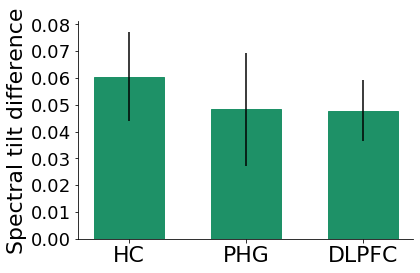

In [44]:

# choose path:
# path= '/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/'
path= '/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/'

# load ROI data
ROI_list=['hippocampus_john','phg_john','dlpfc'] # choose ROIs
roi_avg_spectral_tilt_diff =[]
roi_ste_spectral_tilt_diff =[]
trial_level_tilt=[]
for roi in ROI_list:
    os.chdir(path+roi)
    with open('long_df','rb') as pickle_file:
        long_df=pickle.load(pickle_file)

    tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(long_df)

    temp_tilt_diff=[]
    for sub in tilt_diff['subject'].unique():
        sub_data=tilt_diff[tilt_diff['subject']==sub]
        temp_tilt_diff.append(np.mean(sub_data['tilt_strength']))
    roi_avg_spectral_tilt_diff.append(np.mean(temp_tilt_diff))
    roi_ste_spectral_tilt_diff.append(np.std(temp_tilt_diff)/sqrt(len(temp_tilt_diff)-sum(np.isnan(temp_tilt_diff))))
    trial_level_tilt.append(temp_tilt_diff)

# plot
error = [roi_ste_spectral_tilt_diff[0],roi_ste_spectral_tilt_diff[1],roi_ste_spectral_tilt_diff[2]]
fig=plt.figure()
h=plt.bar([0,1,2],[roi_avg_spectral_tilt_diff[0],roi_avg_spectral_tilt_diff[1],roi_avg_spectral_tilt_diff[2]],yerr=error,width=0.6,edgecolor='black')
# if
colors=['#1e9167', (0.445163, 0.122724, 0.506901)]
if path=='/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/':
    chosen_color=colors[0]
elif path=='/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/':
    chosen_color=colors[1]
h[0].set_color(chosen_color)#('k')
h[1].set_color(chosen_color)#('grey')
h[2].set_color(chosen_color)#('grey')
h[0].set_edgecolor(chosen_color)
h[1].set_edgecolor(chosen_color)
h[2].set_edgecolor(chosen_color)
plt.xticks([0,1,2],['HC','PHG','DLPFC'],fontsize=22, rotation=0)
plt.yticks(fontsize=18)
plt.ylabel('Spectral tilt difference',fontsize=22); #plt.ylim((-0.2, 0.3))
plt.axhline(y=0,color='gray',linewidth=1)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('k')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['bottom'].set_color('k')
plt.grid(False)

savefig('average_spectral_tilt_strength',transparent=True,bbox_inches='tight', pad_inches=0.08)

In [41]:
hipp_df=pd.DataFrame(trial_level_tilt[0],columns=['HC'])
phg_df=pd.DataFrame(trial_level_tilt[1],columns=['PHG'])
dlpfc_df=pd.DataFrame(trial_level_tilt[2],columns=['DLPFC'])

combined_df=pd.concat([hipp_df,phg_df,dlpfc_df])
combined_df

,HC,PHG,DLPFC
0,-0.052774,NaN,NaN
1,0.287670,NaN,NaN
2,-0.226276,NaN,NaN
3,0.014034,NaN,NaN
4,0.206111,NaN,NaN
...,...,...,...
190,NaN,NaN,0.012267
191,NaN,NaN,0.254277
192,NaN,NaN,0.147533
193,NaN,NaN,0.330993


NameError: name 'hipp_tilt_diff' is not defined

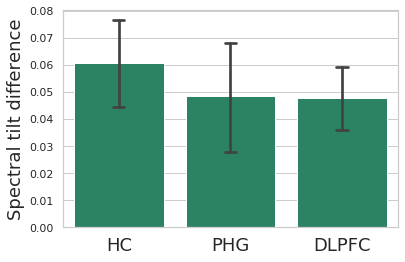

In [45]:
# 
sns.set(style="whitegrid")
ax=sns.barplot(data=combined_df,color=chosen_color,ci=68,capsize=0.1)

# sns.swarmplot(data=combined_df,color="0",alpha=.4)
plt.ylabel('Spectral tilt difference',fontsize=18)
plt.xticks(fontsize=18)

# independent t-test between regions:
tstatistic, pvalue= scipy.stats.ttest_ind(hipp_tilt_diff,phg_tilt_diff,nan_policy='omit')
df=(len(hipp_tilt_diff)+len(phg_tilt_diff))-2
print('t-value: %.3f' %tstatistic + ' df: %1.f' %df +' p-value: %.5f' %pvalue)
plt.title('t(%.f)' %df + '=%.3f' %tstatistic +', p= %.3f' %pvalue,fontsize=14)

os.chdir(path)

# savefig('regions_spectral_tilt_difference1',transparent=True,bbox_inches='tight', pad_inches=0.08)
# savefig('regions_spectral_tilt_difference_swarm',transparent=True,bbox_inches='tight', pad_inches=0.08)

In [1080]:
# # independent t-test between regions:
# tstatistic, pvalue= scipy.stats.ttest_ind(hipp_tilt_diff,phg_tilt_diff,nan_policy='omit')
# df=(len(hipp_spectral_tilt_diff)+len(phg_spectral_tilt_diff))-2
# print('t-value: %.3f' %tstatistic + ' df: %1.f' %df +' p-value: %.5f' %pvalue)



t-value: 0.437 df: 220 p-value: 0.66285


In [46]:
# One way ANOVA between regions:
from scipy.stats import f_oneway

f_oneway(trial_level_tilt[0],trial_level_tilt[1],trial_level_tilt[2])

F_onewayResult(statistic=0.17353367520710156, pvalue=0.8407499592273255)

In [9]:
# Region and experiement as independent variables

# fr
path= '/home1/noaherz/Long2017/FR1_replication_results/trial_level/FR/'

# load hippocampus data
os.chdir(path+'hippocampus_john')
with open('long_df','rb') as pickle_file:
    hipp_long_df=pickle.load(pickle_file)

HC_tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(hipp_long_df)
HC_tilt_diff['region']='HC'

# load PHG data
os.chdir(path+'phg_john')
with open('long_df','rb') as pickle_file:
    phg_long_df=pickle.load(pickle_file)

PHG_tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(phg_long_df)
PHG_tilt_diff['region']='PHG'

# load DLPFC data
os.chdir(path+'dlpfc')
with open('long_df','rb') as pickle_file:
    dlpfc_long_df=pickle.load(pickle_file)

dlpfc_tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(dlpfc_long_df)
dlpfc_tilt_diff['region']='dlpfc'


# FR_combined=pd.merge(left=HC_tilt_diff,right=PHG_tilt_diff,how='outer',left_on=['subject','session'],right_on=['subject','session'],suffixes=('_HC', '_PHG'))
FR_combined=pd.concat([HC_tilt_diff,PHG_tilt_diff,dlpfc_tilt_diff])
FR_combined['experiment']='FR'


path= '/home1/noaherz/Long2017/FR1_replication_results/trial_level/catFR1/'

# load hippocampus data
os.chdir(path+'hippocampus_john')
with open('long_df','rb') as pickle_file:
    hipp_long_df=pickle.load(pickle_file)
HC_tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(hipp_long_df)
HC_tilt_diff['region']='HC'


# load PHG data
os.chdir(path+'phg_john')
with open('long_df','rb') as pickle_file:
    phg_long_df=pickle.load(pickle_file)
PHG_tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(phg_long_df)
PHG_tilt_diff['region']='PHG'

# load DLPFC data
os.chdir(path+'dlpfc')
with open('long_df','rb') as pickle_file:
    dlpfc_long_df=pickle.load(pickle_file)

dlpfc_tilt_diff,correct_recall_mean_tilt,intrusion_mean_tilt,deliberation_mean_tilt,PLI_mean_tilt,ELI_mean_tilt=average_tilt(dlpfc_long_df)
dlpfc_tilt_diff['region']='dlpfc'


catFR_combined=pd.concat([HC_tilt_diff,PHG_tilt_diff])
catFR_combined['experiment']='catFR'

combined_data=pd.concat([FR_combined,catFR_combined])#,suffixes=('_catFR_HC', '_catFR_PHG'))
combined_data

,session,subject,tilt_strength,region,experiment
0,0.0,R1001P,0.024692,HC,FR
1,1.0,R1001P,-0.130241,HC,FR
2,0.0,R1002P,0.133414,HC,FR
3,1.0,R1002P,0.441927,HC,FR
4,0.0,R1003P,-0.169905,HC,FR
...,...,...,...,...,...
235,1.0,R1536J,0.181438,PHG,catFR
236,2.0,R1536J,0.115040,PHG,catFR
237,3.0,R1536J,-0.597495,PHG,catFR
238,0.0,R1542J,0.169815,PHG,catFR


In [16]:
# Optional: Drop rows without semantic similarity values
combined_data_new=combined_data.dropna(axis=0,subset=['tilt_strength'])
len(combined_data_new)


1279

Check if brain region predicts spectral-tilt

In [28]:
# Set up model with main effects only; look at summary table to assess direction of effects; 
# get likelihood for likelihood ratio tests
# from sklearn import linear_model
# df are the number of rows that were added to the new model (e.g. if 2 rows were added, the df=2)

# independent variables: region (HC/PHG), experiment(catFR/FR)
# dependent variable: tilt strength (diff between correct recalls-intrusions)
df_region = len(combined_data_new['region'].unique())-1

# region main effect
model = sm.MixedLM.from_formula('tilt_strength ~ 1', groups='subject', data=combined_data_new) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('tilt_strength ~ C(region)', groups='subject', data=combined_data_new) 
result=model.fit(reml=False, method='nm')
llf_region =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of region')
lr, p = lrtest(llf_empty, llf_region, df = df_region) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))

# experiment 
model = sm.MixedLM.from_formula('tilt_strength ~ C(experiment)', groups='subject', data=combined_data_new) 
result=model.fit(reml=False, method='nm')
llf_experiment =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of experiment')
lr, p = lrtest(llf_empty, llf_experiment, df = 1) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))

# add both region and experiment
model = sm.MixedLM.from_formula('tilt_strength ~ C(region)+ C(experiment)', groups='subject', data=combined_data_new) 
result=model.fit(reml=False, method='nm')
llf_full =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('region x experiment')
lr, p = lrtest(llf_experiment, llf_full, df = df_region) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tilt_strength
No. Observations: 1279    Method:             ML           
No. Groups:       279     Scale:              0.0577       
Min. group size:  1       Log-Likelihood:     -31.2516     
Max. group size:  24      Converged:          Yes          
Mean group size:  4.6                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.054     0.008  6.500  0.000   0.037   0.070
subject Var    0.005     0.008                              



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: tilt_strength
No. Observations:   1279    Method:             ML           
No. Groups:         279     Scale:              0.0575       
Min. group size:    1       Log-Likelihood:     -29.9547     
Max. group size:    24      Converged:          Yes          
Mean group size:    4.6                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.073    0.015  4.968 0.000  0.044  0.101
C(region)[T.PHG]   -0.027    0.018 -1.551 0.121 -0.062  0.007
C(region)[T.dlpfc] -0.023    0.018 -1.254 0.210 -0.058  0.013
subject Var         0.005    0.008                           

Main effect of region
LR test, p value: 2.5936, 0.27340253


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  tilt_strength
No. Observations:   1279     Method:              ML           
No. Groups:         279      Scale:               0.0577       
Min. group size:    1        Log-Likelihood:      -31.0036     
Max. group size:    24       Converged:           Yes          
Mean group size:    4.6                                        
---------------------------------------------------------------
                       Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.051    0.009 5.428 0.000  0.032  0.069
C(experiment)[T.catFR] 0.012    0.017 0.705 0.481 -0.022  0.046
subject Var            0.005    0.008                          

Main effect of experiment
LR test, p value: 0.4959, 0.48132269
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tilt_strength

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [31]:
# model for a single experiment (catFR/FR)
# dependent variable: tilt strength (diff between correct recalls-intrusions)

# region main effect
model = sm.MixedLM.from_formula('tilt_strength ~ 1', groups='subject', data=combined_data_new[combined_data_new['experiment']=='FR']) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('tilt_strength ~ C(region)', groups='subject', data=combined_data_new[combined_data_new['experiment']=='FR']) 
result=model.fit(reml=False, method='nm')
llf_region =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of region for FR experiment')
lr, p = lrtest(llf_empty, llf_region, df = df_region) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))

# region main effect
model = sm.MixedLM.from_formula('tilt_strength ~ 1', groups='subject', data=combined_data_new[combined_data_new['experiment']=='catFR']) 
result=model.fit(reml=False, method='nm')
llf_empty =result.llf #log likelihood
print(result.summary())

model = sm.MixedLM.from_formula('tilt_strength ~ C(region)', groups='subject', data=combined_data_new[combined_data_new['experiment']=='catFR']) 
result=model.fit(reml=False, method='nm')
llf_region =result.llf #log likelihood
print(result.summary())

# Likelihood ratio tests for main effects
print('Main effect of region for catFR experiment')
lr, p = lrtest(llf_empty, llf_region, df = df_region) # Degrees of freedom = number of regressors (i.e. columns in summary table) added when including the effect of interest, for categorical variable with two groups this is df = 1
print('LR test, p value: {:.4f}, {:.8f}'.format(lr, p))

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tilt_strength
No. Observations: 968     Method:             ML           
No. Groups:       226     Scale:              0.0593       
Min. group size:  1       Log-Likelihood:     -34.7148     
Max. group size:  24      Converged:          Yes          
Mean group size:  4.3                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.050     0.009  5.390  0.000   0.032   0.069
subject Var    0.004     0.008                              



/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: tilt_strength
No. Observations:   968     Method:             ML           
No. Groups:         226     Scale:              0.0592       
Min. group size:    1       Log-Likelihood:     -34.0300     
Max. group size:    24      Converged:          Yes          
Mean group size:    4.3                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.065    0.017  3.854 0.000  0.032  0.098
C(region)[T.PHG]   -0.025    0.022 -1.158 0.247 -0.068  0.017
C(region)[T.dlpfc] -0.016    0.020 -0.808 0.419 -0.055  0.023
subject Var         0.004    0.008                           

Main effect of region for FR experiment
LR test, p value: 1.3695, 0.50421148


/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tilt_strength
No. Observations: 311     Method:             ML           
No. Groups:       101     Scale:              0.0513       
Min. group size:  1       Log-Likelihood:     4.8220       
Max. group size:  8       Converged:          Yes          
Mean group size:  3.1                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.065     0.016  4.152  0.000   0.034   0.095
subject Var    0.006     0.017                              

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: tilt_strength
No. Observations: 311     Method:             ML           
No. Groups:       101     Scale:              0.0506       
Min. group size:  1       Log-Likelihood:     5.9159    

/home1/noaherz/.conda/envs/cml3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
